In [1]:
%matplotlib inline

import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import pickle
import pandas as pd
import scipy.io
import time
import h5py
import bz2
import multiprocessing as mp


from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from numpy import linalg as LA
from scipy.spatial import Delaunay
from sklearn.neighbors import NearestNeighbors, KDTree

from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef
from sklearn.metrics import auc

#sys.path.insert(0, "../")
from info3d import *
from nn_matchers import *

# Extracting the point collection and the descriptors

In [2]:
with open('point_collection/new_contiguous_point_collection.pickle','rb') as f: 
    new_contiguous_point_collection = pickle.load(f)
    
with open('descriptors/new_complete_res5_4by5_descriptors.pickle','rb') as f:
    descriptors = pickle.load(f)
    
with open('descriptors/new_complete_RANSAC_res5_4by5_descriptors.pickle','rb') as f:
    ransac_descriptors = pickle.load(f)
    
results_path = 'testing_results'

if not os.path.exists(results_path): os.mkdir(results_path)
    
obj_names = []

for obj_name, pointCloud, triangles in new_contiguous_point_collection:
    obj_names.append(obj_name)
    
contiguous_names_short = [
    'Recpt\'n',
    'Drvway',
    'Aprtmnt',
    'Wrkst\'n',
    'Kitchen',
    'Hallway',
    'Strwell',
]

contiguous_names = [
    'Reception',
    'Driveway',
    'Apartment',
    'Workstation',
    'Kitchen',
    'Hallway',
    'Stairwell',
]

colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:cyan",
    "tab:olive",
    "tab:gray",
    "tab:pink",
    "tab:brown"
]

obj_names

['Reception-Data61-L5.obj',
 'Driveway.obj',
 'Apartment.obj',
 'Workstations-Data61-L4.obj',
 'Kitchen-Data61-L4.obj',
 'HallWayToKitchen-Data61-L4.obj',
 'StairWell-Data61-L4.obj']

# The Normal Similarity CDF with varying neighborhood size

In [11]:
"""
For the computation of normal vector similarity:
1. For every keypoint, we get the K nearest neighboring points of and 
2. compute the average cosine similarity of their normals with that of the keypoint.
3. We vary the neighbor size K to see how the normal similarity varies accordingly.
"""

raw_norm_cdf_values = []

neighbor_sizes = 50*2**np.arange(0,6)

for obj_name, pointCloud, triangles in new_contiguous_point_collection:

    #pointCloud = getQuantizedPointCloudOnlyTEST(t_pointCloud,scale = 100)
    #print("{}: from {} to {}.".format(obj_name, t_pointCloud.shape, pointCloud.shape))

    per_space_values = []

    for i, neighbor_size in enumerate(neighbor_sizes):

        t0 = time.time()

        nbrs = NearestNeighbors(n_neighbors=neighbor_size, algorithm='kd_tree').fit(pointCloud[:,:3])
        distances, indices = nbrs.kneighbors(pointCloud[:,:3])
        
        #print("  Max dist of {} = {:.3f} m (± {:.3f} m)".format(
        #    neighbor_size,
        #    np.mean(np.amax(distances,axis =1)),
        #    np.std(np.amax(distances,axis =1))
        #))
        
        try:
            nearby_normals = pointCloud[indices,3:6]
            refrnc_normals = np.reshape(np.repeat(pointCloud[:,3:6],neighbor_size,axis=0),nearby_normals.shape)

            normal_product = np.sum(np.multiply(refrnc_normals,nearby_normals),axis=2)
            
            #print(nearby_normals.shape, refrnc_normals.shape, normal_product.shape)
        except Exception as e1:
            print("Error while getting normals,", e1)

        color = np.mean(np.abs(normal_product))
        hist, values = np.histogram(np.mean(np.abs(normal_product),axis = 1), bins = np.arange(0,1.01,0.01))
        CY = np.cumsum(hist/np.sum(hist))
        
        per_space_values.append([
            hist,
            CY,
            values,
            np.trapz(CY, values[1:]),
            neighbor_size
        ])

    print("Done with {} in {:.3f} seconds".format(obj_name,time.time()-t0))
    
    raw_norm_cdf_values.append([
        obj_name,
        per_space_values
    ])
    
with open("properties/raw_cdf_values_2.pickle",'wb') as f:
    pickle.dump(raw_norm_cdf_values,f)

Done with Reception-Data61-L5.obj in 16.576 seconds
Done with Driveway.obj in 24.679 seconds
Done with Apartment.obj in 31.069 seconds
Done with Workstations-Data61-L4.obj in 30.957 seconds
Done with Kitchen-Data61-L4.obj in 44.351 seconds
Done with HallWayToKitchen-Data61-L4.obj in 10.457 seconds
Done with StairWell-Data61-L4.obj in 33.907 seconds


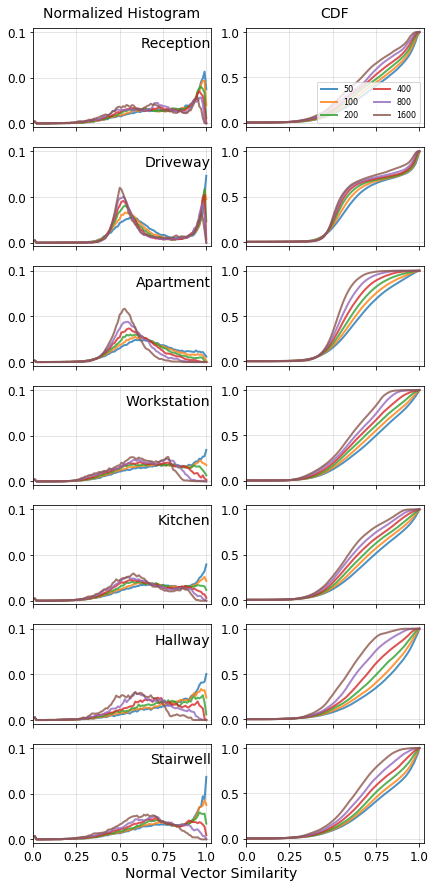

In [83]:
"""
Plotting the (estimate) PDF, i.e. normalized histogram, and CDF
"""

with open("properties/raw_cdf_values_2.pickle",'rb') as f:
    raw_norm_cdf_values = pickle.load(f)

fig=plt.figure(figsize=(7, 15)) ##fig=plt.figure(figsize=(80, 80))

linewidth = 5

figures_list = []

for n in np.arange(7):    
    figures_list.append([
        fig.add_subplot(7,2,n*2+1), # normalized histogram (estimate PDF)
        fig.add_subplot(7,2,n*2+2) # estimate CDF
    ])
    
raw_sim_dist_values = [] # auc and sim dist ratio

for i, [obj_name, per_space_values] in enumerate(raw_norm_cdf_values):
    
    ax1, ax2 = figures_list[i]

    per_space_dist_values = []
    
    ax1.text(
        1.0,.8,contiguous_names[i],
        horizontalalignment='right',
        fontsize = 14,
        transform=ax1.transAxes
    )
    
    ax1.set_ylim(-0.004,0.105)
    ax1.set_xlim(0.375,1.025)
    ax2.set_xlim(0.375,1.025)
    
    if i == 0:
        ax1.text(
            0.5,1.1,
            "Normalized Histogram",
            horizontalalignment='center',
            fontsize = 14,
            transform=ax1.transAxes                
        )
        ax2.text(
            0.5,1.1,                
            "CDF",
            horizontalalignment='center',
            fontsize = 14,
            transform=ax2.transAxes
        )

    ax1.set_xticks(np.arange(0,1.1,0.25))
    ax2.set_xticks(np.arange(0,1.1,0.25))
    ax1.set_yticks(np.arange(0.0,0.11,0.05))
    ax2.set_yticks(np.arange(0.0,1.1,0.5))

    if i!= 6:# and i_n != 0: 
        ax1.set_xticklabels([])
        ax2.set_xticklabels([])   
    else:
        ax1.set_xticklabels(np.around(np.arange(0,1.1,0.25), decimals = 2), fontsize = 12)
        ax2.set_xticklabels(np.around(np.arange(0,1.1,0.25), decimals = 2), fontsize = 12)
        ax1.text(
            1.0,-0.35,"Normal Vector Similarity",
            horizontalalignment='center',
            fontsize = 14,
            transform=ax1.transAxes
        )

    ax1.set_yticklabels(np.around(np.arange(0.0,0.11,0.05),decimals = 1), fontsize = 12)
    ax2.set_yticklabels(np.around(np.arange(0.0,1.1,0.5),decimals = 1), fontsize = 12)

    ax1.grid(alpha=0.4)
    ax2.grid(alpha=0.4)
    
    for hist, cum_y, values, auc, radius in per_space_values:
        
        #color = np.mean(np.abs(normal_product))
        ax1.plot(
            values[1:], 
            hist/np.sum(hist), 
            alpha = 0.8, 
            #color = colors[i_n], #mpl.cm.viridis(color), 
            linewidth = 2,
            label = str(radius)
        )
            
        ax2.plot(
            values[1:], 
            cum_y, 
            alpha = 0.8, 
            #color = colors[i_n], #mpl.cm.viridis(color), 
            linewidth = 2,
            label = str(radius)
        )
        
        per_space_dist_values.append([
            np.sum(hist[90:])/np.sum(hist[:90]),
            np.sum(hist[95:])/np.sum(hist[:95]),
            auc
        ])
        
    if i == 0:
        ax2.legend(loc = "lower right", 
            ncol = 2, fontsize = 8)#bbox_to_anchor=(0.6, 1.03))

    #print("Done with {} in {:.3f} seconds".format(neighbor_size,time.time()-t0))
    
    raw_sim_dist_values.append(per_space_dist_values)
    
#plt.show()
plt.savefig('properties/raw-norm-sim-hist-cdf.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/raw-norm-sim-hist-cdf.png', format='png', dpi=300,bbox_inches = 'tight')


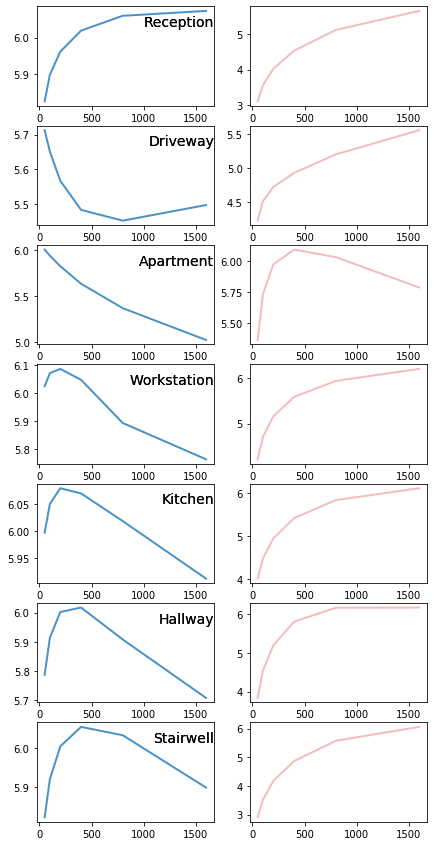

In [138]:
"""
Plotting the (estimate) PDF, i.e. normalized histogram, and CDF
"""

with open("properties/raw_cdf_values_sampled.pickle",'rb') as f:
    raw_cdf_values_sampled = pickle.load(f)

fig=plt.figure(figsize=(7, 15)) ##fig=plt.figure(figsize=(80, 80))

linewidth = 5

figures_list = []

for n in np.arange(7):    
    figures_list.append([
        fig.add_subplot(7,2,n*2+1), # normalized histogram (estimate PDF)
        fig.add_subplot(7,2,n*2+2) # estimate CDF
    ])
    
raw_sim_dist_values = [] # auc and sim dist ratio

for i, [obj_name, per_space_values] in enumerate(raw_cdf_values_sampled):
    
    ax1, ax2 = figures_list[i]

    per_space_dist_values = []
    
    ax1.text(
        1.0,.8,contiguous_names[i],
        horizontalalignment='right',
        fontsize = 14,
        transform=ax1.transAxes
    )
    
    per_space_entropy = []
    
    for hist, cum_y, values, auc, radius in per_space_values:
        
        probability = hist/np.sum(hist)
        
        probability = probability[probability != 0]
        
        entropy = -np.sum(probability*np.log2(probability))
        
        per_space_entropy.append([
            radius,
            entropy
        ])
        
        #color = np.mean(np.abs(normal_product))
        
    per_space_entropy = np.asarray(per_space_entropy)
    
    ax1.plot(
        per_space_entropy[:,0], 
        per_space_entropy[:,1], 
        alpha = 0.8, 
        #color = colors[i_n], #mpl.cm.viridis(color), 
        linewidth = 2
    )
    
for i, [obj_name, per_space_values] in enumerate(ransac_norm_cdf_values[0]):
    
    ax1, ax2 = figures_list[i]

    per_space_dist_values = []
    
    ax1.text(
        1.0,.8,contiguous_names[i],
        horizontalalignment='right',
        fontsize = 14,
        transform=ax1.transAxes
    )
    
    #per_space_values = per_space_samples[ind_at_max]
    
    ransac_per_space_entropy = []
    
    for hist, cum_y, values, auc, radius in per_space_values:
        
        probability = hist/np.sum(hist)
        
        probability = probability[probability != 0]
        
        entropy = -np.sum(probability*np.log2(probability))
        
        ransac_per_space_entropy.append([
            radius,
            entropy
        ])
              
    ransac_per_space_entropy = np.asarray(ransac_per_space_entropy)
    #overall_ransac_entropy.append(ransac_per_space_entropy)
    
    ax2.plot(
        ransac_per_space_entropy[:,0], 
        ransac_per_space_entropy[:,1], 
        alpha = 0.3, 
        color = colors[3], #mpl.cm.viridis(color), 
        linewidth = 2,
        label = "Hololens (Generalized)"
    )


(3, 6, 3)
AUC 6.998979823169349 2.0700335541598553
Ratio 0.35266243282852955 0.0


NameError: name 'neighbor_sizes' is not defined

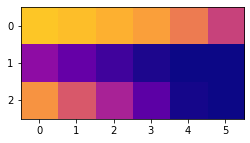

In [31]:
fig=plt.figure(figsize=(4,3.5))

raw_sim_dist_values = np.asarray(raw_sim_dist_values)
print(raw_sim_dist_values.shape)
print("AUC",np.max(raw_sim_dist_values[:,:,1]),np.min(raw_sim_dist_values[:,:,1]))
print("Ratio",np.max(raw_sim_dist_values[:,:,0]),np.min(raw_sim_dist_values[:,:,0]))

#fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
ax1 = fig.add_subplot(111)
#fig.figsize(8,3.5)

im1 = ax1.imshow(
    raw_sim_dist_values[:,:,0], 
    cmap=mpl.cm.plasma,
    vmin=0.0, vmax=np.around(np.max(raw_sim_dist_values[:,:,0]),decimals = 1)
);
ax1.set_xticks(np.arange(len(neighbor_sizes)))
ax1.set_xticklabels(neighbor_sizes, rotation=45, fontsize = 12)
ax1.set_yticks(np.arange(len(contiguous_names)))
ax1.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);
ax1.set_xlabel("Neighbor size (points)",fontsize = 12)
ax1.set_title("Ratio of high-over-low\n Normal similarity", fontsize = 14)

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(im1, cax = cax1, format="%.1f")
cbar1.ax.set_yticklabels(np.arange(0,np.around(np.max(raw_sim_dist_values[:,:,0]),decimals = 1)+0.1,0.1, dtype = np.float32),fontsize = 12);

"""
ax2.set_xticks(np.arange(0,6))
ax2.set_xticklabels(np.arange(0.25, 3.0, 0.5),fontsize = 14)
ax2.set_xlabel('Partial radius', fontsize = 14)
ax2.set_yticks(np.arange(0,7,1))
#plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)
ax2.set_yticklabels(contiguous_names_short,fontsize = 12)
#plt.yticklabels(
"""
#plt.xlabel('Partial radius', fontsize = 14)
#plt.xticks(np.arange(0,6),np.arange(0.25, 1.6, 0.25),fontsize = 14)
#plt.show()
plt.savefig('properties/ratio-norm-sim-90.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/ratio-norm-sim-90.png', format='png', dpi=300,bbox_inches = 'tight')


In [7]:
"""
For the computation of normal vector similarity:
1. For every keypoint, we get the K nearest neighboring points of and 
2. compute the average cosine similarity of their normals with that of the keypoint.
3. We vary the neighbor size K to see how the normal similarity varies accordingly.
"""

raw_norm_cdf_values = []

neighbor_sizes = 50*2**np.arange(0,6)

for obj_name, t_pointCloud, triangles in new_contiguous_point_collection:

    pointCloud = getQuantizedPointCloudOnlyTEST(t_pointCloud,scale = 100)
    print("{}: from {} to {}.".format(obj_name, t_pointCloud.shape, pointCloud.shape))

    per_space_values = []

    for i, neighbor_size in enumerate(neighbor_sizes):

        t0 = time.time()

        nbrs = NearestNeighbors(n_neighbors=neighbor_size, algorithm='kd_tree').fit(pointCloud[:,:3])
        distances, indices = nbrs.kneighbors(pointCloud[:,:3])
        
        print("  Max dist of {} = {:.3f} m (± {:.3f} m)".format(
            neighbor_size,
            np.mean(np.amax(distances,axis =1)),
            np.std(np.amax(distances,axis =1))
        ))
        
        try:
            nearby_normals = pointCloud[indices,3:6]
            refrnc_normals = np.reshape(np.repeat(pointCloud[:,3:6],neighbor_size,axis=0),nearby_normals.shape)

            normal_product = np.sum(np.multiply(refrnc_normals,nearby_normals),axis=2)
            
            #print(nearby_normals.shape, refrnc_normals.shape, normal_product.shape)
        except Exception as e1:
            print("Error while getting normals,", e1)

        color = np.mean(np.abs(normal_product))
        hist, values = np.histogram(np.mean(np.abs(normal_product),axis = 1), bins = np.arange(0,1.01,0.01))
        CY = np.cumsum(hist/np.sum(hist))
        
        per_space_values.append([
            hist,
            CY,
            values,
            np.trapz(CY, values[1:]),
            neighbor_size
        ])

    print("Done with {} in {:.3f} seconds".format(obj_name,time.time()-t0))
    
    raw_norm_cdf_values.append([
        obj_name,
        per_space_values
    ])
    
with open("properties/raw_cdf_values_sampled.pickle",'wb') as f:
    pickle.dump(raw_norm_cdf_values,f)

Reception-Data61-L5.obj: from (40491, 6) to (39848, 6).
  Max dist of 50 = 0.219 m (± 0.094 m)
  Max dist of 100 = 0.314 m (± 0.120 m)
  Max dist of 200 = 0.451 m (± 0.157 m)
  Max dist of 400 = 0.648 m (± 0.204 m)
  Max dist of 800 = 0.927 m (± 0.257 m)
  Max dist of 1600 = 1.316 m (± 0.300 m)
Done with Reception-Data61-L5.obj in 16.839 seconds
Driveway.obj: from (56926, 6) to (55378, 6).
  Max dist of 50 = 0.193 m (± 0.074 m)
  Max dist of 100 = 0.274 m (± 0.105 m)
  Max dist of 200 = 0.388 m (± 0.150 m)
  Max dist of 400 = 0.551 m (± 0.218 m)
  Max dist of 800 = 0.772 m (± 0.297 m)
  Max dist of 1600 = 1.089 m (± 0.400 m)
Done with Driveway.obj in 23.735 seconds
Apartment.obj: from (72859, 6) to (71366, 6).
  Max dist of 50 = 0.184 m (± 0.062 m)
  Max dist of 100 = 0.258 m (± 0.079 m)
  Max dist of 200 = 0.357 m (± 0.101 m)
  Max dist of 400 = 0.491 m (± 0.134 m)
  Max dist of 800 = 0.675 m (± 0.162 m)
  Max dist of 1600 = 0.934 m (± 0.209 m)
Done with Apartment.obj in 33.080 second

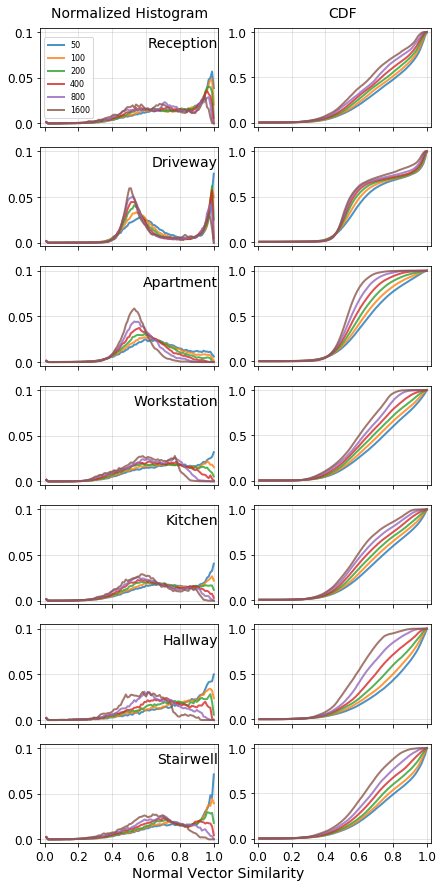

In [274]:
"""
Plotting the (estimate) PDF, i.e. normalized histogram, and CDF
"""

with open("properties/raw_cdf_values_sampled.pickle",'rb') as f:
    raw_norm_cdf_values_sampled = pickle.load(f)

fig=plt.figure(figsize=(7, 15)) ##fig=plt.figure(figsize=(80, 80))

linewidth = 5

figures_list = []

for n in np.arange(7):    
    figures_list.append([
        fig.add_subplot(7,2,n*2+1), # normalized histogram (estimate PDF)
        fig.add_subplot(7,2,n*2+2) # estimate CDF
    ])
    
raw_sim_dist_values = [] # auc and sim dist ratio

for i, [obj_name, per_space_values] in enumerate(raw_norm_cdf_values_sampled):
    
    ax1, ax2 = figures_list[i]

    per_space_dist_values = []
    
    ax1.text(
        1.0,.8,contiguous_names[i],
        horizontalalignment='right',
        fontsize = 14,
        transform=ax1.transAxes
    )
    
    ax1.set_ylim(-0.004,0.105)
    ax1.set_xlim(-0.025,1.025)
    ax2.set_xlim(-0.025,1.025)
    
    if i == 0:
        ax1.text(
            0.5,1.1,
            "Normalized Histogram",
            horizontalalignment='center',
            fontsize = 14,
            transform=ax1.transAxes                
        )
        ax2.text(
            0.5,1.1,                
            "CDF",
            horizontalalignment='center',
            fontsize = 14,
            transform=ax2.transAxes
        )

    ax1.set_xticks(np.arange(0,1.1,0.2))
    ax2.set_xticks(np.arange(0,1.1,0.2))
    ax1.set_yticks(np.arange(0.0,0.11,0.05))
    ax2.set_yticks(np.arange(0.0,1.1,0.5))

    if i!= 6:# and i_n != 0: 
        ax1.set_xticklabels([])
        ax2.set_xticklabels([])   
    else:
        ax1.set_xticklabels(np.around(np.arange(0,1.1,0.2), decimals = 2), fontsize = 12)
        ax2.set_xticklabels(np.around(np.arange(0,1.1,0.2), decimals = 2), fontsize = 12)
        ax1.text(
            1.0,-0.35,"Normal Vector Similarity",
            horizontalalignment='center',
            fontsize = 14,
            transform=ax1.transAxes
        )

    ax1.set_yticklabels(np.around(np.arange(0.0,0.11,0.05),decimals = 2), fontsize = 12)
    ax2.set_yticklabels(np.around(np.arange(0.0,1.1,0.5),decimals = 2), fontsize = 12)

    ax1.grid(alpha=0.4)
    ax2.grid(alpha=0.4)
    
    for hist, cum_y, values, auc, radius in per_space_values:
        
        #color = np.mean(np.abs(normal_product))
        ax1.plot(
            values[1:], 
            hist/np.sum(hist), 
            alpha = 0.8, 
            #color = colors[i_n], #mpl.cm.viridis(color), 
            linewidth = 2,
            label = str(radius)
        )
            
        ax2.plot(
            values[1:], 
            cum_y, 
            alpha = 0.8, 
            #color = colors[i_n], #mpl.cm.viridis(color), 
            linewidth = 2,
            label = str(radius)
        )
        
        per_space_dist_values.append([
            np.sum(hist[90:])/np.sum(hist[:90]),
            np.sum(hist[50:])/np.sum(hist[:50]),
            np.sum(hist[95:])/np.sum(hist)
        ])
        
    if i == 0:
        ax1.legend(loc = "center left", 
            ncol = 1, fontsize = 8)#bbox_to_anchor=(0.6, 1.03))

    #print("Done with {} in {:.3f} seconds".format(neighbor_size,time.time()-t0))
    
    raw_sim_dist_values.append(per_space_dist_values)
    
#plt.show()
plt.savefig('properties/raw-norm-sim-hist-cdf-sampled.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/raw-norm-sim-hist-cdf-sampled.png', format='png', dpi=300,bbox_inches = 'tight')


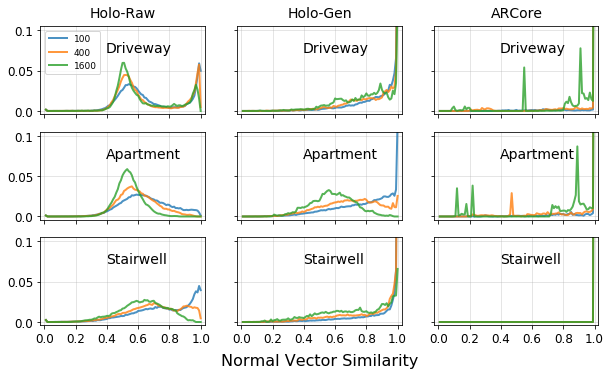

In [191]:
"""
Plotting the (estimate) PDF, i.e. normalized histogram, and CDF
"""

with open("properties/raw_cdf_values_sampled.pickle",'rb') as f:
    raw_norm_cdf_values_sampled = pickle.load(f)

fig=plt.figure(figsize=(10, 5.5)) ##fig=plt.figure(figsize=(80, 80))

linewidth = 5

count = 0

for i, [obj_name, per_space_values] in enumerate(raw_norm_cdf_values_sampled):
    
    if i not in [1,2,6]: continue
    
    ax1 = fig.add_subplot(3,3,count*3+1) # normalized histogram (estimate PDF)
    #ax2 = fig.add_subplot(3,2,count*2+2) #figures_list[i]

    count += 1
    
    per_space_dist_values = []
    
    ax1.text(
        0.4,.7,contiguous_names[i],
        horizontalalignment='left',
        fontsize = 14,
        transform=ax1.transAxes
    )
    
    ax1.set_ylim(-0.004,0.105)
    ax1.set_xlim(-0.025,1.025)
    #ax2.set_xlim(-0.025,1.025)
    
    if count == 1:
        ax1.text(
            0.5,1.1,
            "Holo-Raw",#"Normalized Histogram",
            horizontalalignment='center',
            fontsize = 14,
            transform=ax1.transAxes                
        )

    ax1.set_xticks(np.arange(0,1.1,0.2))
    #ax2.set_xticks(np.arange(0,1.1,0.2))
    ax1.set_yticks(np.arange(0.0,0.11,0.05))
    #ax2.set_yticks(np.arange(0.0,1.1,0.5))

    if i!= 6:# and i_n != 0: 
        ax1.set_xticklabels([])
        #ax2.set_xticklabels([])   
    else:
        ax1.set_xticklabels(np.around(np.arange(0,1.1,0.2), decimals = 2), fontsize = 12)
        #ax2.set_xticklabels(np.around(np.arange(0,1.1,0.2), decimals = 2), fontsize = 12)

    ax1.set_yticklabels(np.around(np.arange(0.0,0.11,0.05),decimals = 2), fontsize = 12)
    #ax2.set_yticklabels(np.around(np.arange(0.0,1.1,0.5),decimals = 1), fontsize = 12)

    ax1.grid(alpha=0.4)
    #ax2.grid(alpha=0.4)
    
    for hist, cum_y, values, auc, radius in per_space_values[1::2]:
        
        #color = np.mean(np.abs(normal_product))
        ax1.plot(
            values[1:], 
            hist/np.sum(hist), 
            alpha = 0.8, 
            #color = colors[i_n], #mpl.cm.viridis(color), 
            linewidth = 2,
            label = str(radius)
        )
        
    if count == 1:
        ax1.legend(loc = "upper left", 
            ncol = 1, fontsize = 9)#bbox_to_anchor=(0.6, 1.03))

    #print("Done with {} in {:.3f} seconds".format(neighbor_size,time.time()-t0))
    
"""
Plotting the (estimate) PDF, i.e. normalized histogram, and CDF
"""

with open("properties/arcore_cdf_values_sampled.pickle",'rb') as f:
    arcore_norm_cdf_values = pickle.load(f)

count = 0

for i, [[obj_num, obj_name], per_space_samples, ind_at_max] in enumerate(arcore_norm_cdf_values):
    
    if i not in [1,2,6]: continue
    
    ax1 = fig.add_subplot(3,3,count*3+3) # normalized histogram (estimate PDF)
    
    count += 1

    per_space_values = per_space_samples[ind_at_max]
    
    ax1.set_ylim(-0.004,0.105)
    ax1.set_xlim(-0.025,1.025)
    
    ax1.text(
        0.4,.7,contiguous_names[i],
        horizontalalignment='left',
        fontsize = 14,
        transform=ax1.transAxes
    )
    
    if i == 1:
        ax1.text(
            0.5,1.1,
            "ARCore",
            horizontalalignment='center',
            fontsize = 14,
            transform=ax1.transAxes                
        )

    ax1.set_xticks(np.arange(0,1.1,0.2))
    #ax2.set_xticks(np.arange(0,1.1,0.25))
    ax1.set_yticks(np.arange(0.0,0.11,0.05))
    #ax2.set_yticks(np.arange(0.0,1.1,0.5))

    if i!= 6:# and i_n != 0: 
        ax1.set_xticklabels([])
        #ax2.set_xticklabels([])   
    else:
        ax1.set_xticklabels(np.around(np.arange(0,1.1,0.2), decimals = 2), fontsize = 12)
        #ax2.set_xticklabels(np.around(np.arange(0,1.1,0.25), decimals = 2), fontsize = 12)

    ax1.set_yticklabels([])#ax1.set_yticklabels(np.around(np.arange(0.0,0.21,0.05),decimals = 2), fontsize = 12)
    #ax2.set_yticklabels(np.around(np.arange(0.0,1.1,0.5),decimals = 2), fontsize = 12)

    ax1.grid(alpha=0.4)
    #ax2.grid(alpha=0.4)
    
    for hist, cum_y, values, auc, radius in per_space_values[1::2]:
        
        #color = np.mean(np.abs(normal_product))
        ax1.plot(
            values[1:], 
            hist/np.sum(hist), 
            alpha = 0.8, 
            #color = colors[i_n], #mpl.cm.viridis(color), 
            linewidth = 2,
            label = str(radius)
        )
        
with open("properties/ransac_cdf_values.pickle",'rb') as f:
    ransac_norm_cdf_values = pickle.load(f)
    
count = 0
        
for i, [obj_name, per_space_values] in enumerate(ransac_norm_cdf_values[0]):
    
    if i not in [1,2,6]: continue
    
    ax1 = fig.add_subplot(3,3,count*3+2) # normalized histogram (estimate PDF)
    #ax2 = fig.add_subplot(3,2,count*2+2) #figures_list[i]

    count += 1
    
    per_space_dist_values = []
    
    ax1.text(
        0.4,.7,contiguous_names[i],
        horizontalalignment='left',
        fontsize = 14,
        transform=ax1.transAxes
    )
    
    ax1.set_ylim(-0.004,0.105)
    ax1.set_xlim(-0.025,1.025)
    #ax2.set_xlim(-0.025,1.025)
    
    if count == 1:
        ax1.text(
            0.5,1.1,
            "Holo-Gen",#"Normalized Histogram",
            horizontalalignment='center',
            fontsize = 14,
            transform=ax1.transAxes                
        )

    ax1.set_xticks(np.arange(0,1.1,0.2))
    #ax2.set_xticks(np.arange(0,1.1,0.2))
    ax1.set_yticks(np.arange(0.0,0.11,0.05))
    #ax2.set_yticks(np.arange(0.0,1.1,0.5))

    if i!= 6:# and i_n != 0: 
        ax1.set_xticklabels([])
        #ax1.set_xticklabels([])
        #ax2.set_xticklabels([])   
    else:
        ax1.set_xticklabels(np.around(np.arange(0,1.1,0.2), decimals = 2), fontsize = 12)
        #ax2.set_xticklabels(np.around(np.arange(0,1.1,0.2), decimals = 2), fontsize = 12)
        ax1.text(
            0.5,-0.45,"Normal Vector Similarity",
            horizontalalignment='center',
            fontsize = 16,
            transform=ax1.transAxes
        )

    ax1.set_yticklabels([])#np.around(np.arange(0.0,0.21,0.05),decimals = 2), fontsize = 12)
    #ax2.set_yticklabels(np.around(np.arange(0.0,1.1,0.5),decimals = 1), fontsize = 12)

    ax1.grid(alpha=0.4)
    #ax2.grid(alpha=0.4)
    
    for hist, cum_y, values, auc, radius in per_space_values[1::2]:
        
        #color = np.mean(np.abs(normal_product))
        ax1.plot(
            values[1:], 
            hist/np.sum(hist), 
            alpha = 0.8, 
            #color = colors[i_n], #mpl.cm.viridis(color), 
            linewidth = 2,
            label = str(radius)
        )
    

#plt.show()
plt.savefig('properties/raw-norm-sim-hist-pdf_only-example.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/raw-norm-sim-hist-pdf_only-example.png', format='png', dpi=300,bbox_inches = 'tight')


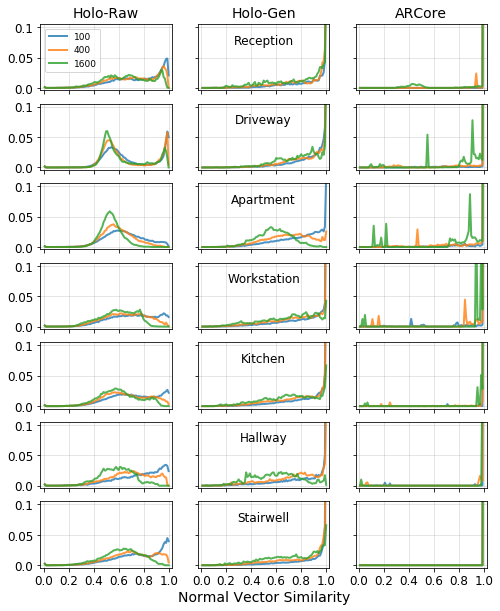

In [288]:
"""
Plotting the (estimate) PDF, i.e. normalized histogram, and CDF
"""

with open("properties/raw_cdf_values_sampled.pickle",'rb') as f:
    raw_norm_cdf_values_sampled = pickle.load(f)

fig=plt.figure(figsize=(8, 10)) ##fig=plt.figure(figsize=(80, 80))

linewidth = 5

count = 0

for i, [obj_name, per_space_values] in enumerate(raw_norm_cdf_values_sampled):
    
    #if i not in [1,2,6]: continue
    
    ax1 = fig.add_subplot(7,3,i*3+1) # normalized histogram (estimate PDF)
    #ax2 = fig.add_subplot(3,2,count*2+2) #figures_list[i]

    #count += 1
    
    per_space_dist_values = []
    """
    ax1.text(
        0.4,.7,contiguous_names[i],
        horizontalalignment='left',
        fontsize = 14,
        transform=ax1.transAxes
    )
    """
    ax1.set_ylim(-0.004,0.105)
    ax1.set_xlim(-0.025,1.025)
    #ax2.set_xlim(-0.025,1.025)
    
    if i == 0:
        ax1.text(
            0.5,1.1,
            "Holo-Raw",#"Normalized Histogram",
            horizontalalignment='center',
            fontsize = 14,
            transform=ax1.transAxes                
        )

    ax1.set_xticks(np.arange(0,1.1,0.2))
    #ax2.set_xticks(np.arange(0,1.1,0.2))
    ax1.set_yticks(np.arange(0.0,0.11,0.05))
    #ax2.set_yticks(np.arange(0.0,1.1,0.5))

    if i!= 6:# and i_n != 0: 
        ax1.set_xticklabels([])
        #ax2.set_xticklabels([])   
    else:
        ax1.set_xticklabels(np.around(np.arange(0,1.1,0.2), decimals = 2), fontsize = 12)
        #ax2.set_xticklabels(np.around(np.arange(0,1.1,0.2), decimals = 2), fontsize = 12)

    ax1.set_yticklabels(np.around(np.arange(0.0,0.11,0.05),decimals = 2), fontsize = 12)
    #ax2.set_yticklabels(np.around(np.arange(0.0,1.1,0.5),decimals = 1), fontsize = 12)

    ax1.grid(alpha=0.4)
    #ax2.grid(alpha=0.4)
    
    for hist, cum_y, values, auc, radius in per_space_values[1::2]:
        
        #color = np.mean(np.abs(normal_product))
        ax1.plot(
            values[1:], 
            hist/np.sum(hist), 
            alpha = 0.8, 
            #color = colors[i_n], #mpl.cm.viridis(color), 
            linewidth = 2,
            label = str(radius)
        )
        
    if i == 0:
        ax1.legend(loc = "upper left", 
            ncol = 1, fontsize = 9)#bbox_to_anchor=(0.6, 1.03))

    #print("Done with {} in {:.3f} seconds".format(neighbor_size,time.time()-t0))
    
"""
Plotting the (estimate) PDF, i.e. normalized histogram, and CDF
"""

with open("properties/arcore_cdf_values_sampled.pickle",'rb') as f:
    arcore_norm_cdf_values = pickle.load(f)

count = 0

for i, [[obj_num, obj_name], per_space_samples, ind_at_max] in enumerate(arcore_norm_cdf_values):
    
    #if i not in [1,2,6]: continue
    
    ax1 = fig.add_subplot(7,3,i*3+3) # normalized histogram (estimate PDF)
    
    #count += 1

    per_space_values = per_space_samples[ind_at_max]
    
    ax1.set_ylim(-0.004,0.105)
    ax1.set_xlim(-0.025,1.025)
    
    """
    ax1.text(
        0.4,.7,contiguous_names[i],
        horizontalalignment='left',
        fontsize = 14,
        transform=ax1.transAxes
    )
    """
    
    if i == 0:
        ax1.text(
            0.5,1.1,
            "ARCore",
            horizontalalignment='center',
            fontsize = 14,
            transform=ax1.transAxes                
        )

    ax1.set_xticks(np.arange(0,1.1,0.2))
    #ax2.set_xticks(np.arange(0,1.1,0.25))
    ax1.set_yticks(np.arange(0.0,0.11,0.05))
    #ax2.set_yticks(np.arange(0.0,1.1,0.5))

    if i!= 6:# and i_n != 0: 
        ax1.set_xticklabels([])
        #ax2.set_xticklabels([])   
    else:
        ax1.set_xticklabels(np.around(np.arange(0,1.1,0.2), decimals = 2), fontsize = 12)
        #ax2.set_xticklabels(np.around(np.arange(0,1.1,0.25), decimals = 2), fontsize = 12)

    ax1.set_yticklabels([])#ax1.set_yticklabels(np.around(np.arange(0.0,0.21,0.05),decimals = 2), fontsize = 12)
    #ax2.set_yticklabels(np.around(np.arange(0.0,1.1,0.5),decimals = 2), fontsize = 12)

    ax1.grid(alpha=0.4)
    #ax2.grid(alpha=0.4)
    
    for hist, cum_y, values, auc, radius in per_space_values[1::2]:
        
        #color = np.mean(np.abs(normal_product))
        ax1.plot(
            values[1:], 
            hist/np.sum(hist), 
            alpha = 0.8, 
            #color = colors[i_n], #mpl.cm.viridis(color), 
            linewidth = 2,
            label = str(radius)
        )
        
with open("properties/ransac_cdf_values.pickle",'rb') as f:
    ransac_norm_cdf_values = pickle.load(f)
    
count = 0
        
for i, [obj_name, per_space_values] in enumerate(ransac_norm_cdf_values[0]):
    
    #if i not in [1,2,6]: continue
    
    ax1 = fig.add_subplot(7,3,i*3+2) # normalized histogram (estimate PDF)
    #ax2 = fig.add_subplot(3,2,count*2+2) #figures_list[i]

    #count += 1
    
    per_space_dist_values = []
    
    ax1.text(
        0.5,.7,contiguous_names[i],
        horizontalalignment='center',
        fontsize = 12,
        transform=ax1.transAxes
    )
    
    ax1.set_ylim(-0.004,0.105)
    ax1.set_xlim(-0.025,1.025)
    #ax2.set_xlim(-0.025,1.025)
    
    if i == 0:
        ax1.text(
            0.5,1.1,
            "Holo-Gen",#"Normalized Histogram",
            horizontalalignment='center',
            fontsize = 14,
            transform=ax1.transAxes                
        )

    ax1.set_xticks(np.arange(0,1.1,0.2))
    #ax2.set_xticks(np.arange(0,1.1,0.2))
    ax1.set_yticks(np.arange(0.0,0.11,0.05))
    #ax2.set_yticks(np.arange(0.0,1.1,0.5))

    if i!= 6:# and i_n != 0: 
        ax1.set_xticklabels([])
        #ax1.set_xticklabels([])
        #ax2.set_xticklabels([])   
    else:
        ax1.set_xticklabels(np.around(np.arange(0,1.1,0.2), decimals = 2), fontsize = 12)
        #ax2.set_xticklabels(np.around(np.arange(0,1.1,0.2), decimals = 2), fontsize = 12)
        ax1.text(
            0.5,-0.5,"Normal Vector Similarity",
            horizontalalignment='center',
            fontsize = 14,
            transform=ax1.transAxes
        )

    ax1.set_yticklabels([])#np.around(np.arange(0.0,0.21,0.05),decimals = 2), fontsize = 12)
    #ax2.set_yticklabels(np.around(np.arange(0.0,1.1,0.5),decimals = 1), fontsize = 12)

    ax1.grid(alpha=0.4)
    #ax2.grid(alpha=0.4)
    
    for hist, cum_y, values, auc, radius in per_space_values[1::2]:
        
        #color = np.mean(np.abs(normal_product))
        ax1.plot(
            values[1:], 
            hist/np.sum(hist), 
            alpha = 0.8, 
            #color = colors[i_n], #mpl.cm.viridis(color), 
            linewidth = 2,
            label = str(radius)
        )
    

#plt.show()
plt.savefig('properties/norm-sim-hist-pdf_only-all.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/norm-sim-hist-pdf_only-all.png', format='png', dpi=300,bbox_inches = 'tight')


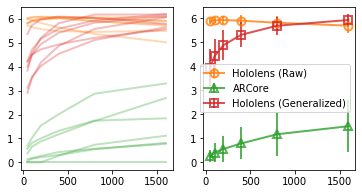

In [175]:
"""
Plotting the entripoy from the (estimate) PDF, i.e. normalized histogram
"""

with open("properties/raw_cdf_values_sampled.pickle",'rb') as f:
    raw_norm_cdf_values_sampled = pickle.load(f)

fig=plt.figure(figsize=(6, 3)) ##fig=plt.figure(figsize=(80, 80))

linewidth = 5

count = 0

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

overall_raw_entropy = []

for i, [obj_name, per_space_values] in enumerate(raw_norm_cdf_values_sampled):
    
    raw_per_space_entropy = []
    
    for hist, cum_y, values, auc, radius in per_space_values:
        
        probability = hist/np.sum(hist)
        
        probability = probability[probability != 0]
        
        entropy = -np.sum(probability*np.log2(probability))
        
        raw_per_space_entropy.append([
            radius,
            entropy
        ])
                
    raw_per_space_entropy = np.asarray(raw_per_space_entropy)
    overall_raw_entropy.append(raw_per_space_entropy)
    
    ax1.plot(
        raw_per_space_entropy[:,0], 
        raw_per_space_entropy[:,1], 
        alpha = 0.3, 
        color = colors[1], #mpl.cm.viridis(color), 
        linewidth = 2,
        label = "Hololens (Raw)"
    )
    
"""
Plotting the (estimate) PDF, i.e. normalized histogram, and CDF
"""

with open("properties/arcore_cdf_values_sampled.pickle",'rb') as f:
    arcore_norm_cdf_values = pickle.load(f)

overall_arcore_entropy = []

for i, [[obj_num, obj_name], per_space_samples, ind_at_max] in enumerate(arcore_norm_cdf_values):

    per_space_values = per_space_samples[ind_at_max]
    
    arcore_per_space_entropy = []
    
    for hist, cum_y, values, auc, radius in per_space_values:
        
        probability = hist/np.sum(hist)
        
        probability = probability[probability != 0]
        
        entropy = -np.sum(probability*np.log2(probability))
        
        arcore_per_space_entropy.append([
            radius,
            entropy
        ])
              
    arcore_per_space_entropy = np.asarray(arcore_per_space_entropy)
    overall_arcore_entropy.append(arcore_per_space_entropy)

    ax1.plot(
        arcore_per_space_entropy[:,0], 
        arcore_per_space_entropy[:,1], 
        alpha = 0.3, 
        color = colors[2], #mpl.cm.viridis(color), 
        linewidth = 2,
        label = "ARCore"
    )
    
with open("properties/ransac_cdf_values.pickle",'rb') as f:
    ransac_norm_cdf_values = pickle.load(f)
    
overall_ransac_entropy = []
            
for i, [obj_name, per_space_values] in enumerate(ransac_norm_cdf_values[0]):
    
    #per_space_values = per_space_samples[ind_at_max]
    
    ransac_per_space_entropy = []
    
    for hist, cum_y, values, auc, radius in per_space_values:
        
        probability = hist/np.sum(hist)
        
        probability = probability[probability != 0]
        
        entropy = -np.sum(probability*np.log2(probability))
        
        ransac_per_space_entropy.append([
            radius,
            entropy
        ])
              
    ransac_per_space_entropy = np.asarray(ransac_per_space_entropy)
    overall_ransac_entropy.append(ransac_per_space_entropy)
    
    ax1.plot(
        ransac_per_space_entropy[:,0], 
        ransac_per_space_entropy[:,1], 
        alpha = 0.3, 
        color = colors[3], #mpl.cm.viridis(color), 
        linewidth = 2,
        label = "Hololens (Generalized)"
    )
    
#ax1.legend()

overall_raw_entropy = np.asarray(overall_raw_entropy)
overall_ransac_entropy = np.asarray(overall_ransac_entropy)
overall_arcore_entropy = np.asarray(overall_arcore_entropy)

ax2.errorbar(
    raw_per_space_entropy[:,0], 
    np.mean(overall_raw_entropy[:,:,1], axis = 0), 
    np.std(overall_raw_entropy[:,:,1], axis = 0),
    marker = 'o', fillstyle = 'none', mew = 2,
    alpha = 0.8, 
    color = colors[1], #mpl.cm.viridis(color), 
    linewidth = 2, markersize = 8,
    label = "Hololens (Raw)"
)
ax2.errorbar(
    raw_per_space_entropy[:,0], 
    np.mean(overall_arcore_entropy[:,:,1], axis = 0), 
    np.std(overall_arcore_entropy[:,:,1], axis = 0), 
    marker = '^', fillstyle = 'none', mew = 2,
    alpha = 0.8, 
    color = colors[2], #mpl.cm.viridis(color), 
    linewidth = 2, markersize = 8,
    label = "ARCore"
)
ax2.errorbar(
    raw_per_space_entropy[:,0], 
    np.mean(overall_ransac_entropy[:,:,1], axis = 0), 
    np.std(overall_ransac_entropy[:,:,1], axis = 0), 
    marker = 's', fillstyle = 'none', mew = 2,
    alpha = 0.8, 
    color = colors[3], #mpl.cm.viridis(color), 
    linewidth = 2, markersize = 8,
    label = "Hololens (Generalized)"
)

ax2.legend()
#plt.show()
#plt.savefig('properties/raw-norm-sim-hist-pdf_only-example.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
#plt.savefig('properties/raw-norm-sim-hist-pdf_only-example.png', format='png', dpi=300,bbox_inches = 'tight')


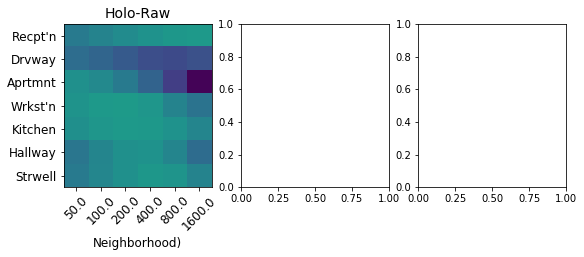

In [186]:
"""
Plotting the entripoy from the (estimate) PDF, i.e. normalized histogram
"""

with open("properties/raw_cdf_values_sampled.pickle",'rb') as f:
    raw_norm_cdf_values_sampled = pickle.load(f)

fig=plt.figure(figsize=(9, 3)) ##fig=plt.figure(figsize=(80, 80))

linewidth = 5

count = 0

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax2 = fig.add_subplot(1,3,3)

overall_raw_entropy = []

for i, [obj_name, per_space_values] in enumerate(raw_norm_cdf_values_sampled):
    
    raw_per_space_entropy = []
    
    for hist, cum_y, values, auc, radius in per_space_values:
        
        probability = hist/np.sum(hist)
        
        probability = probability[probability != 0]
        
        entropy = -np.sum(probability*np.log2(probability))
        
        raw_per_space_entropy.append([
            int(radius),
            entropy
        ])
        
        
    #print(raw_per_space_entropy)
                
    raw_per_space_entropy = np.asarray(raw_per_space_entropy)
    overall_raw_entropy.append(raw_per_space_entropy)
    
overall_raw_entropy = np.asarray(overall_raw_entropy)

ax1.imshow(
    overall_raw_entropy[:,:,1],
    vmin=5.0, vmax=7.0, 
    aspect='auto',
    cmap = plt.cm.viridis
)

ax1.set_title("Holo-Raw", fontsize = 14)
ax1.set_xticks(np.arange(6))
ax1.set_xticklabels(overall_raw_entropy[1,:,0], rotation=45, fontsize = 12)
ax1.set_xlabel("Neighborhood)",fontsize = 12)
ax1.set_yticks(np.arange(len(contiguous_names)))
ax1.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);

In [ ]:
# Create divider for existing axes instance
divider3 = make_axes_locatable(ax3)
# Append axes to the right of ax3, with 20% width of ax3
cax3 = divider3.append_axes("right", size="5%", pad=0.05)

# Create colorbar in the appended axes
# Tick locations can be set with the kwarg `ticks`
# and the format of the ticklabels with kwarg `format`
cbar3 = plt.colorbar(im3, cax=cax3, ticks=np.arange(0.0,1.1,0.2), format="%.1f")
#cbar1.ax.set_ylabel("F1-score", fontsize = 14)

cbar3.ax.set_yticklabels(
    np.around(np.arange(0.0,1.1,0.2),decimals = 2),
#    np.concatenate((['≤ 0.4'],np.around(np.arange(0.5,1.1,0.1), decimals = 2))),
    fontsize = 12);
cbar3.ax.set_ylabel("F1-score", fontsize = 14)

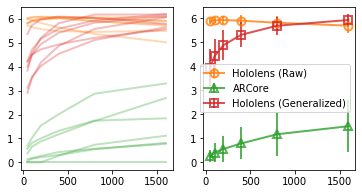

In [63]:
    
"""
Plotting the (estimate) PDF, i.e. normalized histogram, and CDF
"""

with open("properties/arcore_cdf_values_sampled.pickle",'rb') as f:
    arcore_norm_cdf_values = pickle.load(f)

overall_arcore_entropy = []

for i, [[obj_num, obj_name], per_space_samples, ind_at_max] in enumerate(arcore_norm_cdf_values):

    per_space_values = per_space_samples[ind_at_max]
    
    arcore_per_space_entropy = []
    
    for hist, cum_y, values, auc, radius in per_space_values:
        
        probability = hist/np.sum(hist)
        
        probability = probability[probability != 0]
        
        entropy = -np.sum(probability*np.log2(probability))
        
        arcore_per_space_entropy.append([
            radius,
            entropy
        ])
              
    arcore_per_space_entropy = np.asarray(arcore_per_space_entropy)
    overall_arcore_entropy.append(arcore_per_space_entropy)

    ax1.plot(
        arcore_per_space_entropy[:,0], 
        arcore_per_space_entropy[:,1], 
        alpha = 0.3, 
        color = colors[2], #mpl.cm.viridis(color), 
        linewidth = 2,
        label = "ARCore"
    )
    
with open("properties/ransac_cdf_values.pickle",'rb') as f:
    ransac_norm_cdf_values = pickle.load(f)
    
overall_ransac_entropy = []
            
for i, [obj_name, per_space_values] in enumerate(ransac_norm_cdf_values[0]):
    
    #per_space_values = per_space_samples[ind_at_max]
    
    ransac_per_space_entropy = []
    
    for hist, cum_y, values, auc, radius in per_space_values:
        
        probability = hist/np.sum(hist)
        
        probability = probability[probability != 0]
        
        entropy = -np.sum(probability*np.log2(probability))
        
        ransac_per_space_entropy.append([
            radius,
            entropy
        ])
              
    ransac_per_space_entropy = np.asarray(ransac_per_space_entropy)
    overall_ransac_entropy.append(ransac_per_space_entropy)
    
    ax1.plot(
        ransac_per_space_entropy[:,0], 
        ransac_per_space_entropy[:,1], 
        alpha = 0.3, 
        color = colors[3], #mpl.cm.viridis(color), 
        linewidth = 2,
        label = "Hololens (Generalized)"
    )
    
#ax1.legend()

overall_raw_entropy = np.asarray(overall_raw_entropy)
overall_ransac_entropy = np.asarray(overall_ransac_entropy)
overall_arcore_entropy = np.asarray(overall_arcore_entropy)

ax2.errorbar(
    raw_per_space_entropy[:,0], 
    np.mean(overall_raw_entropy[:,:,1], axis = 0), 
    np.std(overall_raw_entropy[:,:,1], axis = 0),
    marker = 'o', fillstyle = 'none', mew = 2,
    alpha = 0.8, 
    color = colors[1], #mpl.cm.viridis(color), 
    linewidth = 2, markersize = 8,
    label = "Hololens (Raw)"
)
ax2.errorbar(
    raw_per_space_entropy[:,0], 
    np.mean(overall_arcore_entropy[:,:,1], axis = 0), 
    np.std(overall_arcore_entropy[:,:,1], axis = 0), 
    marker = '^', fillstyle = 'none', mew = 2,
    alpha = 0.8, 
    color = colors[2], #mpl.cm.viridis(color), 
    linewidth = 2, markersize = 8,
    label = "ARCore"
)
ax2.errorbar(
    raw_per_space_entropy[:,0], 
    np.mean(overall_ransac_entropy[:,:,1], axis = 0), 
    np.std(overall_ransac_entropy[:,:,1], axis = 0), 
    marker = 's', fillstyle = 'none', mew = 2,
    alpha = 0.8, 
    color = colors[3], #mpl.cm.viridis(color), 
    linewidth = 2, markersize = 8,
    label = "Hololens (Generalized)"
)

ax2.legend()
#plt.show()
#plt.savefig('properties/raw-norm-sim-hist-pdf_only-example.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
#plt.savefig('properties/raw-norm-sim-hist-pdf_only-example.png', format='png', dpi=300,bbox_inches = 'tight')

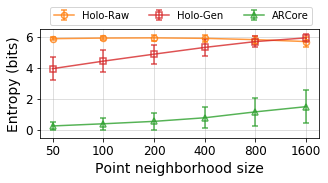

In [158]:
"""
Plotting the entripoy from the (estimate) PDF, i.e. normalized histogram
"""

with open("properties/raw_cdf_values_sampled.pickle",'rb') as f:
    raw_norm_cdf_values_sampled = pickle.load(f)

fig=plt.figure(figsize=(5, 2)) ##fig=plt.figure(figsize=(80, 80))

linewidth = 1.5
markersize = 6
capsize = 3
mew = 1.5
#ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,1,1)

overall_raw_entropy = []

for i, [obj_name, per_space_values] in enumerate(raw_norm_cdf_values_sampled):
    
    raw_per_space_entropy = []
    
    for hist, cum_y, values, auc, radius in per_space_values:
        
        probability = hist/np.sum(hist)
        
        probability = probability[probability != 0]
        
        entropy = -np.sum(probability*np.log2(probability))
        
        raw_per_space_entropy.append([
            radius,
            entropy
        ])
                
    raw_per_space_entropy = np.asarray(raw_per_space_entropy)
    overall_raw_entropy.append(raw_per_space_entropy)


overall_arcore_entropy = []

for i, [[obj_num, obj_name], per_space_samples, ind_at_max] in enumerate(arcore_norm_cdf_values):

    per_space_values = per_space_samples[ind_at_max]
    
    arcore_per_space_entropy = []
    
    for hist, cum_y, values, auc, radius in per_space_values:
        
        probability = hist/np.sum(hist)
        
        probability = probability[probability != 0]
        
        entropy = -np.sum(probability*np.log2(probability))
        
        arcore_per_space_entropy.append([
            radius,
            entropy
        ])
              
    arcore_per_space_entropy = np.asarray(arcore_per_space_entropy)
    overall_arcore_entropy.append(arcore_per_space_entropy)
    
overall_ransac_entropy = []
            
for i, [obj_name, per_space_values] in enumerate(ransac_norm_cdf_values[0]):
    
    #per_space_values = per_space_samples[ind_at_max]
    
    ransac_per_space_entropy = []
    
    for hist, cum_y, values, auc, radius in per_space_values:
        
        probability = hist/np.sum(hist)
        
        probability = probability[probability != 0]
        
        entropy = -np.sum(probability*np.log2(probability))
        
        ransac_per_space_entropy.append([
            radius,
            entropy
        ])
              
    ransac_per_space_entropy = np.asarray(ransac_per_space_entropy)
    overall_ransac_entropy.append(ransac_per_space_entropy)

overall_raw_entropy = np.asarray(overall_raw_entropy)
overall_ransac_entropy = np.asarray(overall_ransac_entropy)
overall_arcore_entropy = np.asarray(overall_arcore_entropy)

ax2.errorbar(
    np.log10(raw_per_space_entropy[:,0]), 
    np.mean(overall_raw_entropy[:,:,1], axis = 0), 
    np.std(overall_raw_entropy[:,:,1], axis = 0),
    marker = 'o', fillstyle = 'none',  mew = mew,
    alpha = 0.8, capsize = capsize,
    color = colors[1], #mpl.cm.viridis(color), 
    linewidth = linewidth, markersize = markersize,
    label = "Holo-Raw"
)
ax2.errorbar(
    np.log10(raw_per_space_entropy[:,0]), 
    np.mean(overall_ransac_entropy[:,:,1], axis = 0), 
    np.std(overall_ransac_entropy[:,:,1], axis = 0), 
    marker = 's', fillstyle = 'none', mew = mew,
    capsize = capsize,
    alpha = 0.8, 
    color = colors[3], #mpl.cm.viridis(color), 
    linewidth = linewidth, markersize = markersize,
    label = "Holo-Gen"
)
ax2.errorbar(
    np.log10(raw_per_space_entropy[:,0]), 
    np.mean(overall_arcore_entropy[:,:,1], axis = 0), 
    np.std(overall_arcore_entropy[:,:,1], axis = 0), 
    marker = '^', fillstyle = 'none',  mew = mew,
    alpha = 0.8, 
    capsize = capsize,
    color = colors[2], #mpl.cm.viridis(color), 
    linewidth = linewidth, markersize = markersize,
    label = "ARCore"
)

ax2.legend(
    ncol = 3,
    #loc = "upper right", 
    fontsize = 10, 
    bbox_to_anchor=(0.995, 1.25)
);

ax2.set_ylim(-0.5,6.5)
ax2.grid(alpha = 0.5)
ax2.set_xticks(np.log10(raw_per_space_entropy[:,0]))
ax2.set_xticklabels(neighbor_sizes, fontsize = 12)

ax2.set_yticks(np.arange(0,7,2))
ax2.set_yticklabels(np.arange(0,7,2), fontsize = 12)

ax2.set_xlabel("Point neighborhood size", fontsize = 14)
ax2.set_ylabel("Entropy (bits)", fontsize =14)

plt.savefig('properties/sim-hist-entropy.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/sim-hist-entropy.png', format='png', dpi=300,bbox_inches = 'tight')


In [136]:

np.mean(overall_raw_entropy[:,:,1], axis = 0), np.mean(overall_ransac_entropy[:,:,1], axis = 0), np.mean(overall_arcore_entropy[:,:,1], axis = 0)


(array([5.88187398, 5.92055772, 5.93261074, 5.90408774, 5.81931256,
        5.69616646]),
 array([3.95248007, 4.43512901, 4.88519306, 5.31939063, 5.6949048 ,
        5.9343299 ]),
 array([0.26221475, 0.40273805, 0.55764356, 0.78938325, 1.17019333,
        1.50491073]))

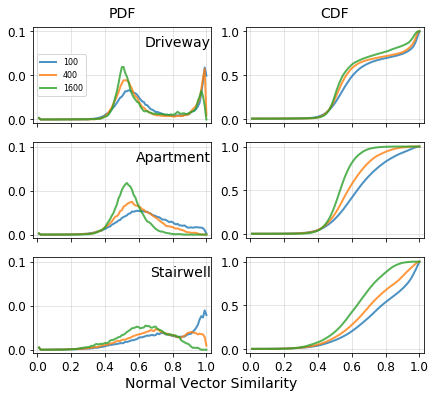

In [5]:
"""
Plotting the (estimate) PDF, i.e. normalized histogram, and CDF
"""

with open("properties/raw_cdf_values_sampled.pickle",'rb') as f:
    raw_norm_cdf_values_sampled = pickle.load(f)

fig=plt.figure(figsize=(7, 6)) ##fig=plt.figure(figsize=(80, 80))

linewidth = 5

figures_list = []

"""
for n in np.arange(7):    
    figures_list.append([
        fig.add_subplot(7,2,n*2+1), # normalized histogram (estimate PDF)
        fig.add_subplot(7,2,n*2+2) # estimate CDF
    ])
"""

raw_sim_dist_values = [] # auc and sim dist ratio

count = 0

for i, [obj_name, per_space_values] in enumerate(raw_norm_cdf_values_sampled):
    
    if i not in [1,2,6]: continue
    
    ax1 = fig.add_subplot(3,2,count*2+1) # normalized histogram (estimate PDF)
    ax2 = fig.add_subplot(3,2,count*2+2) #figures_list[i]

    count += 1
    
    per_space_dist_values = []
    
    ax1.text(
        1.0,.8,contiguous_names[i],
        horizontalalignment='right',
        fontsize = 14,
        transform=ax1.transAxes
    )
    
    ax1.set_ylim(-0.004,0.105)
    ax1.set_xlim(-0.025,1.025)
    ax2.set_xlim(-0.025,1.025)
    
    if count == 1:
        ax1.text(
            0.5,1.1,
            "PDF",#"Normalized Histogram",
            horizontalalignment='center',
            fontsize = 14,
            transform=ax1.transAxes                
        )
        ax2.text(
            0.5,1.1,                
            "CDF",
            horizontalalignment='center',
            fontsize = 14,
            transform=ax2.transAxes
        )

    ax1.set_xticks(np.arange(0,1.1,0.2))
    ax2.set_xticks(np.arange(0,1.1,0.2))
    ax1.set_yticks(np.arange(0.0,0.11,0.05))
    ax2.set_yticks(np.arange(0.0,1.1,0.5))

    if i!= 6:# and i_n != 0: 
        ax1.set_xticklabels([])
        ax2.set_xticklabels([])   
    else:
        ax1.set_xticklabels(np.around(np.arange(0,1.1,0.2), decimals = 2), fontsize = 12)
        ax2.set_xticklabels(np.around(np.arange(0,1.1,0.2), decimals = 2), fontsize = 12)
        ax1.text(
            1.0,-0.35,"Normal Vector Similarity",
            horizontalalignment='center',
            fontsize = 14,
            transform=ax1.transAxes
        )

    ax1.set_yticklabels(np.around(np.arange(0.0,0.11,0.05),decimals = 1), fontsize = 12)
    ax2.set_yticklabels(np.around(np.arange(0.0,1.1,0.5),decimals = 1), fontsize = 12)

    ax1.grid(alpha=0.4)
    ax2.grid(alpha=0.4)
    
    for hist, cum_y, values, auc, radius in per_space_values[1::2]:
        
        #color = np.mean(np.abs(normal_product))
        ax1.plot(
            values[1:], 
            hist/np.sum(hist), 
            alpha = 0.8, 
            #color = colors[i_n], #mpl.cm.viridis(color), 
            linewidth = 2,
            label = str(radius)
        )
            
        ax2.plot(
            values[1:], 
            cum_y, 
            alpha = 0.8, 
            #color = colors[i_n], #mpl.cm.viridis(color), 
            linewidth = 2,
            label = str(radius)
        )
        
        per_space_dist_values.append([
            np.sum(hist[90:])/np.sum(hist[:90]),
            np.sum(hist[50:])/np.sum(hist[:50]),
            auc
        ])
        
    if count == 1:
        ax1.legend(loc = "center left", 
            ncol = 1, fontsize = 8)#bbox_to_anchor=(0.6, 1.03))

    #print("Done with {} in {:.3f} seconds".format(neighbor_size,time.time()-t0))
    
    raw_sim_dist_values.append(per_space_dist_values)
    
#plt.show()
plt.savefig('properties/raw-norm-sim-hist-cdf-sampled-example.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/raw-norm-sim-hist-cdf-sampled-example.png', format='png', dpi=300,bbox_inches = 'tight')


(7, 6, 3)
AUC 11.761999010390896 2.0700335541598553
Ratio 0.562237817069824 0.0


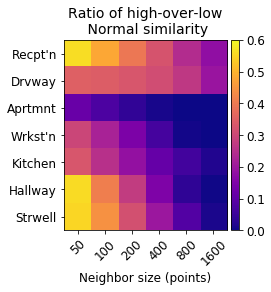

In [240]:
fig=plt.figure(figsize=(4,3.5))

neighbor_sizes = 50*2**np.arange(0,6)

raw_sim_dist_values = np.asarray(raw_sim_dist_values)
print(raw_sim_dist_values.shape)
print("AUC",np.max(raw_sim_dist_values[:,:,1]),np.min(raw_sim_dist_values[:,:,1]))
print("Ratio",np.max(raw_sim_dist_values[:,:,0]),np.min(raw_sim_dist_values[:,:,0]))

#fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
ax1 = fig.add_subplot(111)
#fig.figsize(8,3.5)

im1 = ax1.imshow(
    raw_sim_dist_values[:,:,0], 
    cmap=mpl.cm.plasma,
    vmin=0.0, vmax=np.around(np.max(raw_sim_dist_values[:,:,0]),decimals = 1)
);
ax1.set_xticks(np.arange(len(neighbor_sizes)))
ax1.set_xticklabels(neighbor_sizes, rotation=45, fontsize = 12)
ax1.set_yticks(np.arange(len(contiguous_names)))
ax1.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);
ax1.set_xlabel("Neighbor size (points)",fontsize = 12)
ax1.set_title("Ratio of high-over-low\n Normal similarity", fontsize = 14)

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(im1, cax = cax1, format="%.1f")
cbar1.ax.set_yticklabels(np.arange(0,np.around(np.max(raw_sim_dist_values[:,:,0]),decimals = 1)+0.1,0.1, dtype = np.float32),fontsize = 12);

"""
ax2.set_xticks(np.arange(0,6))
ax2.set_xticklabels(np.arange(0.25, 3.0, 0.5),fontsize = 14)
ax2.set_xlabel('Partial radius', fontsize = 14)
ax2.set_yticks(np.arange(0,7,1))
#plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)
ax2.set_yticklabels(contiguous_names_short,fontsize = 12)
#plt.yticklabels(
"""
#plt.xlabel('Partial radius', fontsize = 14)
#plt.xticks(np.arange(0,6),np.arange(0.25, 1.6, 0.25),fontsize = 14)
#plt.show()
plt.savefig('properties/ratio-norm-sim-90-sampled.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/ratio-norm-sim-90-sampled.png', format='png', dpi=300,bbox_inches = 'tight')


(7, 6, 3)
P($\zeta > 0.95$) 0.23535447883914593 0.0
Ratio 0.562237817069824 0.0


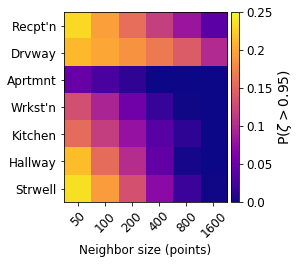

In [247]:
fig=plt.figure(figsize=(4,3.5))

neighbor_sizes = 50*2**np.arange(0,6)

raw_sim_dist_values = np.asarray(raw_sim_dist_values)
print(raw_sim_dist_values.shape)
print("P($\zeta > 0.95$)",np.max(raw_sim_dist_values[:,:,-1]),np.min(raw_sim_dist_values[:,:,-1]))
print("Ratio",np.max(raw_sim_dist_values[:,:,0]),np.min(raw_sim_dist_values[:,:,0]))

#fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
ax1 = fig.add_subplot(111)
#fig.figsize(8,3.5)

im1 = ax1.imshow(
    raw_sim_dist_values[:,:,-1], 
    cmap=mpl.cm.plasma,
    vmin=0.0, vmax=0.25
);
ax1.set_xticks(np.arange(len(neighbor_sizes)))
ax1.set_xticklabels(neighbor_sizes, rotation=45, fontsize = 12)
ax1.set_yticks(np.arange(len(contiguous_names)))
ax1.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);
ax1.set_xlabel("Neighbor size (points)",fontsize = 12)
#ax1.set_title()

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(im1, cax = cax1, format="%.2f")
cbar1.ax.set_yticklabels(
    np.around(np.arange(0,0.26,0.05), decimals = 2),
    fontsize = 12);
cbar1.ax.set_ylabel("P($\zeta > 0.95$)", fontsize = 14)

"""
ax2.set_xticks(np.arange(0,6))
ax2.set_xticklabels(np.arange(0.25, 3.0, 0.5),fontsize = 14)
ax2.set_xlabel('Partial radius', fontsize = 14)
ax2.set_yticks(np.arange(0,7,1))
#plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)
ax2.set_yticklabels(contiguous_names_short,fontsize = 12)
#plt.yticklabels(
"""
#plt.xlabel('Partial radius', fontsize = 14)
#plt.xticks(np.arange(0,6),np.arange(0.25, 1.6, 0.25),fontsize = 14)
#plt.show()
plt.savefig('properties/high-norm-sim.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/high-norm-sim.png', format='png', dpi=300,bbox_inches = 'tight')


In [4]:
"""
For the computation of normal vector similarity:
1. For every keypoint, we get the K nearest neighboring points of and 
2. compute the average cosine similarity of their normals with that of the keypoint.
3. We vary the neighbor size K to see how the normal similarity varies accordingly.
"""

linewidth = 5

raw_cdf_values_by_size = []

radii_range = np.arange(0.2,1.1,0.2)#0.25*1.5**np.arange(5)

for obj_name, pointCloud, triangles in new_contiguous_point_collection:
    
    t00 = time.time()
    
    r_pointCloud = getQuantizedPointCloudOnlyTEST(pointCloud,scale = 10)
    
    print("{}: from {} to {} in {:.3f} seconds".format(obj_name, pointCloud.shape, r_pointCloud.shape, time.time() - t00))

    nbrs = NearestNeighbors(n_neighbors=2000, algorithm='kd_tree').fit(pointCloud[:,:3])
    
    per_space_values = []
    
    t0 = time.time()
    t1 = t0
    
    for radius in radii_range:
                
        normal_products = []
        #max_distances = []

        for point in r_pointCloud:
        
            distances, indices = nbrs.kneighbors([point[:3]])
            #max_distances.append(np.amax(distances))
            
            try:
                nearby_normals = pointCloud[np.where(distances[0]<radius)[0],3:]
                #print(nearby_normals.shape)
                refrnc_normals = np.reshape(np.repeat(point[3:],len(nearby_normals),axis=0),nearby_normals.shape)

                normal_products.append(
                    np.mean(np.abs(np.sum(np.multiply(refrnc_normals,nearby_normals),axis=1)))
                )
            except Exception as e1:
                print("Error while getting normals,", e1)
                continue

        normal_products = np.asarray(normal_products)

        #color = np.mean(np.abs(normal_product))
        hist, values = np.histogram(normal_products, bins = np.arange(0,1.01,0.01))
        CY = np.cumsum(hist/np.sum(hist))
        
        per_space_values.append([
            hist,
            CY,
            values,
            np.trapz(CY, values[1:]),
            radius,
            #[np.mean(np.asarray(max_distances)),np.std(np.asarray(max_distances))]
        ])
        
        print("--> radius {} in {:.3f} seconds".format(radius,time.time()-t1))
        t1 = time.time()
        #print("-->",np.mean(np.asarray(max_distances)),np.std(np.asarray(max_distances)))
        
    print("Done with object {} in {:.3f} seconds".format(obj_name,time.time()-t0))
    
    raw_cdf_values_by_size.append([
        obj_name,
        per_space_values
    ])
    
with open("properties/raw_cdf_values_by_size.pickle",'wb') as f:
    pickle.dump(raw_cdf_values_by_size,f)

Reception-Data61-L5.obj: from (40491, 6) to (13416, 6) in 0.063 seconds
--> radius 0.2 in 10.291 seconds
--> radius 0.4 in 10.487 seconds
--> radius 0.6000000000000001 in 10.686 seconds
--> radius 0.8 in 10.975 seconds
--> radius 1.0 in 10.935 seconds
Done with object Reception-Data61-L5.obj in 53.375 seconds
Driveway.obj: from (56926, 6) to (15925, 6) in 0.121 seconds
--> radius 0.2 in 12.446 seconds
--> radius 0.4 in 12.662 seconds
--> radius 0.6000000000000001 in 13.006 seconds
--> radius 0.8 in 13.306 seconds
--> radius 1.0 in 13.166 seconds
Done with object Driveway.obj in 64.587 seconds
Apartment.obj: from (72859, 6) to (20344, 6) in 0.139 seconds
--> radius 0.2 in 16.446 seconds
--> radius 0.4 in 17.127 seconds
--> radius 0.6000000000000001 in 16.863 seconds
--> radius 0.8 in 17.230 seconds
--> radius 1.0 in 18.014 seconds
Done with object Apartment.obj in 85.680 seconds
Workstations-Data61-L4.obj: from (73215, 6) to (22660, 6) in 0.108 seconds
--> radius 0.2 in 17.456 seconds
-

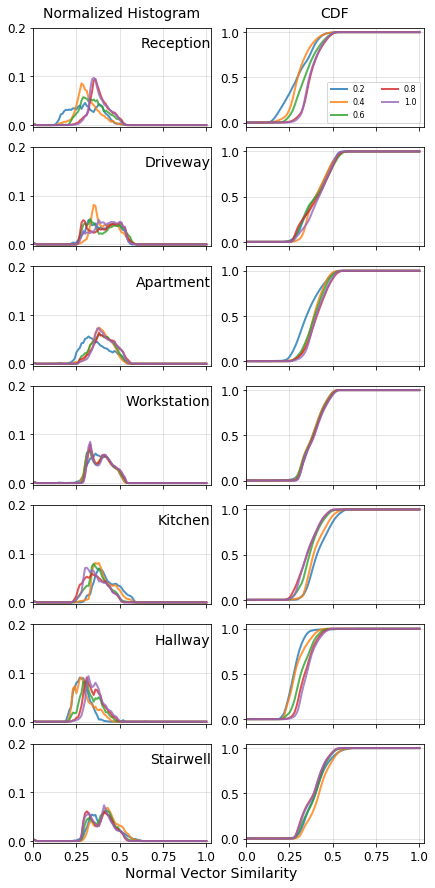

In [51]:
"""
Plotting the (estimate) PDF, i.e. normalized histogram, and CDF
"""

with open("properties/raw_cdf_values_by_size.pickle",'rb') as f:
    raw_cdf_values_by_size = pickle.load(f)

fig=plt.figure(figsize=(7, 15)) ##fig=plt.figure(figsize=(80, 80))

linewidth = 5

figures_list = []

for n in np.arange(7):    
    figures_list.append([
        fig.add_subplot(7,2,n*2+1), # normalized histogram (estimate PDF)
        fig.add_subplot(7,2,n*2+2) # estimate CDF
    ])
    
raw_sim_dist_values = [] # auc and sim dist ratio

for i, [obj_name, per_space_values] in enumerate(raw_cdf_values_by_size):
    
    ax1, ax2 = figures_list[i]

    per_space_dist_values = []
    
    ax1.text(
        1.0,.8,contiguous_names[i],
        horizontalalignment='right',
        fontsize = 14,
        transform=ax1.transAxes
    )
    
    ax1.set_ylim(-0.004,0.105)
    ax1.set_xlim(0.375,1.025)
    ax2.set_xlim(0.375,1.025)
    
    if i == 0:
        ax1.text(
            0.5,1.1,
            "Normalized Histogram",
            horizontalalignment='center',
            fontsize = 14,
            transform=ax1.transAxes                
        )
        ax2.text(
            0.5,1.1,                
            "CDF",
            horizontalalignment='center',
            fontsize = 14,
            transform=ax2.transAxes
        )

    ax1.set_xticks(np.arange(0,1.1,0.25))
    ax2.set_xticks(np.arange(0,1.1,0.25))
    ax1.set_yticks(np.arange(0.0,0.21,0.1))
    ax2.set_yticks(np.arange(0.0,1.1,0.5))

    if i!= 6:# and i_n != 0: 
        ax1.set_xticklabels([])
        ax2.set_xticklabels([])   
    else:
        ax1.set_xticklabels(np.around(np.arange(0,1.1,0.25), decimals = 2), fontsize = 12)
        ax2.set_xticklabels(np.around(np.arange(0,1.1,0.25), decimals = 2), fontsize = 12)
        ax1.text(
            1.0,-0.35,"Normal Vector Similarity",
            horizontalalignment='center',
            fontsize = 14,
            transform=ax1.transAxes
        )

    ax1.set_yticklabels(np.around(np.arange(0.0,0.21,0.1),decimals = 1), fontsize = 12)
    ax2.set_yticklabels(np.around(np.arange(0.0,1.1,0.5),decimals = 1), fontsize = 12)

    ax1.grid(alpha=0.4)
    ax2.grid(alpha=0.4)
    
    for hist, cum_y, values, auc, radius in per_space_values:
        
        #color = np.mean(np.abs(normal_product))
        ax1.plot(
            values[1:], 
            hist/np.sum(hist), 
            alpha = 0.8, 
            #color = colors[i_n], #mpl.cm.viridis(color), 
            linewidth = 2,
            label = str(np.around(radius, decimals = 2))
        )
            
        ax2.plot(
            values[1:], 
            cum_y, 
            alpha = 0.8, 
            #color = colors[i_n], #mpl.cm.viridis(color), 
            linewidth = 2,
            label = str(np.around(radius, decimals = 2))
        )
        
        per_space_dist_values.append([
            np.sum(hist[90:])/np.sum(hist[:90]),
            np.sum(hist[50:])/np.sum(hist[:50]),
            auc
        ])
        
    if i == 0:
        ax2.legend(loc = "lower right", 
            ncol = 2, fontsize = 8)#bbox_to_anchor=(0.6, 1.03))

    #print("Done with {} in {:.3f} seconds".format(neighbor_size,time.time()-t0))
    
    raw_sim_dist_values.append(per_space_dist_values)
    
#plt.show()
#plt.savefig('properties/raw-norm-sim-hist-cdf.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
#plt.savefig('properties/raw-norm-sim-hist-cdf.png', format='png', dpi=300,bbox_inches = 'tight')


(7, 5, 3)
at 50 0.20243128964059195 0.0
at 90 3.045994517209869e-05 0.0


"\nax2.set_xticks(np.arange(0,6))\nax2.set_xticklabels(np.arange(0.25, 3.0, 0.5),fontsize = 14)\nax2.set_xlabel('Partial radius', fontsize = 14)\nax2.set_yticks(np.arange(0,7,1))\n#plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)\nax2.set_yticklabels(contiguous_names_short,fontsize = 12)\n#plt.yticklabels(\n"

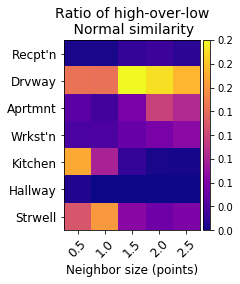

In [53]:
fig=plt.figure(figsize=(4,3.5))

raw_sim_dist_values = np.asarray(raw_sim_dist_values)
print(raw_sim_dist_values.shape)
print("at 50",np.max(raw_sim_dist_values[:,:,1]),np.min(raw_sim_dist_values[:,:,1]))
print("at 90",np.max(raw_sim_dist_values[:,:,0]),np.min(raw_sim_dist_values[:,:,0]))

#fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
ax1 = fig.add_subplot(111)
#fig.figsize(8,3.5)

im1 = ax1.imshow(
    raw_sim_dist_values[:,:,1], 
    cmap=mpl.cm.plasma,
    vmin=0.0, vmax=np.around(np.max(raw_sim_dist_values[:,:,1]),decimals = 1)
);
ax1.set_xticks(np.arange(raw_sim_dist_values.shape[1]))
ax1.set_xticklabels(np.arange(0.5,3.1,0.5), rotation=45, fontsize = 12)
ax1.set_yticks(np.arange(len(contiguous_names)))
ax1.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);
ax1.set_xlabel("Neighbor size (points)",fontsize = 12)
ax1.set_title("Ratio of high-over-low\n Normal similarity", fontsize = 14)

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(im1, cax = cax1, format="%.1f")
#cbar1.ax.set_yticklabels(np.arange(0,np.around(np.max(raw_sim_dist_values[:,:,0]),decimals = 1)+0.1,0.1, dtype = np.float32),fontsize = 12);

"""
ax2.set_xticks(np.arange(0,6))
ax2.set_xticklabels(np.arange(0.25, 3.0, 0.5),fontsize = 14)
ax2.set_xlabel('Partial radius', fontsize = 14)
ax2.set_yticks(np.arange(0,7,1))
#plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)
ax2.set_yticklabels(contiguous_names_short,fontsize = 12)
#plt.yticklabels(
"""
#plt.xlabel('Partial radius', fontsize = 14)
#plt.xticks(np.arange(0,6),np.arange(0.25, 1.6, 0.25),fontsize = 14)
#plt.show()
#plt.savefig('properties/ratio-norm-sim-90.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
#plt.savefig('properties/ratio-norm-sim-90.png', format='png', dpi=300,bbox_inches = 'tight')


(6, 7, 3)
AUC 0.29985650403790964 0.0
Ratio 0.5566694185635098 0.0


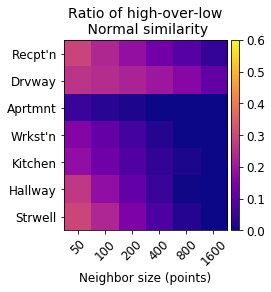

In [562]:
fig=plt.figure(figsize=(4,3.5))

raw_sim_dist_values = np.asarray(raw_sim_dist_values)
print(raw_sim_dist_values.shape)
print("AUC",np.max(raw_sim_dist_values[:,:,1]),np.min(raw_sim_dist_values[:,:,1]))
print("Ratio",np.max(raw_sim_dist_values[:,:,0]),np.min(raw_sim_dist_values[:,:,0]))

#fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
ax1 = fig.add_subplot(111)
#fig.figsize(8,3.5)

im1 = ax1.imshow(
    raw_sim_dist_values[:,:,1].T, 
    cmap=mpl.cm.plasma,
    vmin=0.0, vmax=np.around(np.max(raw_sim_dist_values[:,:,0]),decimals = 1)
);
ax1.set_xticks(np.arange(len(neighbor_sizes)))
ax1.set_xticklabels(neighbor_sizes, rotation=45, fontsize = 12)
ax1.set_yticks(np.arange(len(contiguous_names)))
ax1.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);
ax1.set_xlabel("Neighbor size (points)",fontsize = 12)
ax1.set_title("Ratio of high-over-low\n Normal similarity", fontsize = 14)

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(im1, cax = cax1, format="%.1f")
cbar1.ax.set_yticklabels(np.arange(0,np.around(np.max(raw_sim_dist_values[:,:,0]),decimals = 1)+0.1,0.1, dtype = np.float32),fontsize = 12);

"""
ax2.set_xticks(np.arange(0,6))
ax2.set_xticklabels(np.arange(0.25, 3.0, 0.5),fontsize = 14)
ax2.set_xlabel('Partial radius', fontsize = 14)
ax2.set_yticks(np.arange(0,7,1))
#plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)
ax2.set_yticklabels(contiguous_names_short,fontsize = 12)
#plt.yticklabels(
"""
#plt.xlabel('Partial radius', fontsize = 14)
#plt.xticks(np.arange(0,6),np.arange(0.25, 1.6, 0.25),fontsize = 14)
#plt.show()
plt.savefig('properties/ratio-norm-sim-95.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/ratio-norm-sim-95.png', format='png', dpi=300,bbox_inches = 'tight')


(6, 7, 2)
AUC 0.46490392401762304 0.21104894310175018
Ratio 0.5566694185635098 0.0


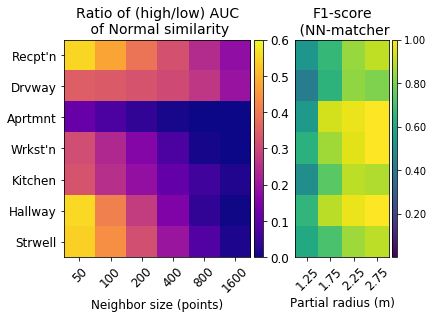

In [517]:
fig=plt.figure(figsize=(4,3.5))

raw_sim_dist_values = np.asarray(raw_sim_dist_values)
print(raw_sim_dist_values.shape)
print("AUC",np.max(raw_sim_dist_values[:,:,1]),np.min(raw_sim_dist_values[:,:,1]))
print("Ratio",np.max(raw_sim_dist_values[:,:,0]),np.min(raw_sim_dist_values[:,:,0]))

#fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
ax1 = 
#fig.figsize(8,3.5)

im1 = ax1.imshow(
    raw_sim_dist_values[:,:,0].T, 
    cmap=mpl.cm.plasma,
    vmin=0.0, vmax=np.around(np.max(raw_sim_dist_values[:,:,0]),decimals = 1)
);
ax1.set_xticks(np.arange(len(neighbor_sizes)))
ax1.set_xticklabels(neighbor_sizes, rotation=45, fontsize = 12)
ax1.set_yticks(np.arange(len(contiguous_names)))
ax1.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);
ax1.set_xlabel("Neighbor size (points)",fontsize = 12)
ax1.set_title("Ratio of (high/low) AUC\n of Normal similarity", fontsize = 14)

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(im1, cax = cax1, format="%.1f")
cbar1.ax.set_yticklabels(np.arange(0,np.around(np.max(raw_sim_dist_values[:,:,0]),decimals = 1)+0.1,0.1, dtype = np.float32),fontsize = 12);

im2 = ax2.imshow(
    per_space_score[2:,0].T,
    vmin=0.0, vmax=1.0, aspect='auto',
    cmap = plt.cm.viridis
)

ax2.set_title("F1-score\n (NN-matcher", fontsize = 14)
ax2.set_xticks(np.arange(4))
ax2.set_xticklabels(np.arange(0.25, 3.0, 0.5)[2:], rotation=45, fontsize = 12)
ax2.set_xlabel("Partial radius (m)",fontsize = 12)
ax2.set_yticks([])
ax2.set_yticklabels([])
#ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);

# Create divider for existing axes instance
divider2 = make_axes_locatable(ax2)
# Append axes to the right of ax3, with 20% width of ax3
cax2 = divider2.append_axes("right", size="5%", pad=0.05)

# Create colorbar in the appended axes
# Tick locations can be set with the kwarg `ticks`
# and the format of the ticklabels with kwarg `format`
cbar2 = plt.colorbar(im2, cax=cax2, ticks=np.arange(0.2,1.1,0.2), format="%.2f")
#cbar1.ax.set_ylabel("F1-score", fontsize = 14)
#cbar2.ax.set_yticklabels(np.arange(0,1.1,0.2, dtype = np.float32),fontsize = 12)

"""
ax2.set_xticks(np.arange(0,6))
ax2.set_xticklabels(np.arange(0.25, 3.0, 0.5),fontsize = 14)
ax2.set_xlabel('Partial radius', fontsize = 14)
ax2.set_yticks(np.arange(0,7,1))
#plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)
ax2.set_yticklabels(contiguous_names_short,fontsize = 12)
#plt.yticklabels(
"""
#plt.xlabel('Partial radius', fontsize = 14)
#plt.xticks(np.arange(0,6),np.arange(0.25, 1.6, 0.25),fontsize = 14)
#plt.show()
plt.savefig('properties/ratio-norm-sim.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/ratio-norm-sim.png', format='png', dpi=300,bbox_inches = 'tight')


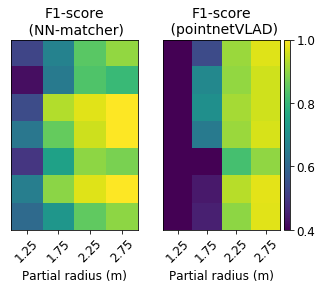

In [568]:
fig = plt.figure(figsize=(5,3.5))

#fig, (ax2, ax3) = #plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1.2]})

#fig3 = plt.figure(constrained_layout=True)
#gs = fig3.add_gridspec(3, 3)
ax2 = fig.add_subplot(121)
ax3 = fig.add_subplot(122)
#fig.figsize(8,3.5)

im2 = ax2.imshow(
    per_space_score[2:,0].T,
    vmin=0.4, vmax=1.0, aspect='auto',
    cmap = plt.cm.viridis
)

ax2.set_title("F1-score\n (NN-matcher)", fontsize = 14)
ax2.set_xticks(np.arange(4))
ax2.set_xticklabels(np.arange(0.25, 3.0, 0.5)[2:], rotation=45, fontsize = 12)
ax2.set_xlabel("Partial radius (m)",fontsize = 12)
#ax2.set_yticks(np.arange(len(contiguous_names)))
#ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);
ax2.set_yticks([])
ax2.set_yticklabels([])
#ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);

im3 = ax3.imshow(
    pointnetvlad_per_space_score[4::2,0].T,
    vmin=0.4, vmax=1.0, aspect='auto',
    cmap = plt.cm.viridis
)

ax3.set_title("F1-score\n (pointnetVLAD)", fontsize = 14)
ax3.set_xticks(np.arange(4))
ax3.set_xticklabels(np.arange(1.25, 3.1, 0.5), rotation=45, fontsize = 12)
ax3.set_xlabel("Partial radius (m)",fontsize = 12)
ax3.set_yticks([])
ax3.set_yticklabels([])
#ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);

# Create divider for existing axes instance
divider3 = make_axes_locatable(ax3)
# Append axes to the right of ax3, with 20% width of ax3
cax3 = divider3.append_axes("right", size="5%", pad=0.05)

# Create colorbar in the appended axes
# Tick locations can be set with the kwarg `ticks`
# and the format of the ticklabels with kwarg `format`
cbar3 = plt.colorbar(im3, cax=cax3, ticks=np.arange(0.4,1.1,0.2), format="%.2f")
#cbar1.ax.set_ylabel("F1-score", fontsize = 14)
cbar3.ax.set_yticklabels(np.around(np.arange(0.4,1.1,0.2), decimals = 2),fontsize = 12);

"""
ax2.set_xticks(np.arange(0,6))
ax2.set_xticklabels(np.arange(0.25, 3.0, 0.5),fontsize = 14)
ax2.set_xlabel('Partial radius', fontsize = 14)
ax2.set_yticks(np.arange(0,7,1))
#plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)
ax2.set_yticklabels(contiguous_names_short,fontsize = 12)
#plt.yticklabels(
"""
#plt.xlabel('Partial radius', fontsize = 14)
#plt.xticks(np.arange(0,6),np.arange(0.25, 1.6, 0.25),fontsize = 14)
#plt.show()
plt.savefig('properties/f1-scores-no-label-0.4.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/f1-scores-no-label-0.4.png', format='png', dpi=300,bbox_inches = 'tight')


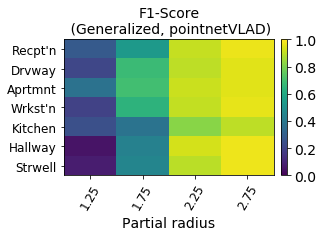

In [74]:
fig=plt.figure(figsize=(4,2.5))

RESULTS_FOLDER="testing_results/pointnetvlad_prod/"

with open(RESULTS_FOLDER + "summary_results.pickle",'rb') as f:
    [pointnetvlad_results, pointnetvlad_per_space_score] = pickle.load(f)

ax1 = fig.add_subplot(1,1,1)

im1 = ax1.imshow(
    pointnetvlad_per_space_score[4::2,0].T,
    vmin=0, vmax=1.0, aspect='auto',
    cmap = plt.cm.viridis
)

# Create divider for existing axes instance
divider1 = make_axes_locatable(ax1)
# Append axes to the right of ax3, with 20% width of ax3
cax1 = divider1.append_axes("right", size="3%", pad=0.1)

# Create colorbar in the appended axes
# Tick locations can be set with the kwarg `ticks`
# and the format of the ticklabels with kwarg `format`
cbar1 = plt.colorbar(im1, cax=cax1, ticks=np.arange(0,1.6,0.2), format="%.2f")
#cbar1.ax.set_ylabel("F1-score", fontsize = 14)
cbar1.ax.set_yticklabels(np.arange(0,1.6,0.2, dtype = np.float32),fontsize = 14)

#cbar = plt.colorbar(ticks = np.arange(0,1.1,0.2))
#cbar.ax.set_ylabel("F1-score", fontsize = 14)
#cbar.ax.set_yticklabels(np.arange(0,1.1,0.2, dtype = np.float32),fontsize = 14)

ax1.set_title('F1-Score\n (Generalized, pointnetVLAD)', fontsize = 14)
ax1.set_xticks(np.arange(4))
ax1.set_xticklabels(np.arange(1.25, 3.1, 0.5),rotation = 60,fontsize = 12)
ax1.set_xlabel('Partial radius', fontsize = 14)
ax1.set_yticks(np.arange(0,7,1))
#plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)
ax1.set_yticklabels(contiguous_names_short,fontsize = 12)
#plt.yticklabels(

#plt.xlabel('Partial radius', fontsize = 14)
#plt.xticks(np.arange(0,6),np.arange(0.25, 1.6, 0.25),fontsize = 14)
plt.show()


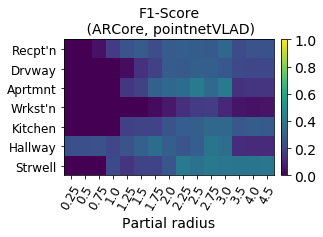

In [79]:
fig=plt.figure(figsize=(4,2.5))

with open("testing_results/pointnetvlad_arcore/" + "arcore_summary_results.pickle",'wb') as f:
    pickle.dump([arcore_pv_results, arcore_pv_per_space_score],f)

ax1 = fig.add_subplot(1,1,1)

im1 = ax1.imshow(
    arcore_pv_per_space_score[:,0].T,#arcore_pv_per_space_score[4::2,0].T,
    vmin=0, vmax=1.0, aspect='auto',
    cmap = plt.cm.viridis
)

# Create divider for existing axes instance
divider1 = make_axes_locatable(ax1)
# Append axes to the right of ax3, with 20% width of ax3
cax1 = divider1.append_axes("right", size="3%", pad=0.1)

# Create colorbar in the appended axes
# Tick locations can be set with the kwarg `ticks`
# and the format of the ticklabels with kwarg `format`
cbar1 = plt.colorbar(im1, cax=cax1, ticks=np.arange(0,1.6,0.2), format="%.2f")
#cbar1.ax.set_ylabel("F1-score", fontsize = 14)
cbar1.ax.set_yticklabels(np.arange(0,1.6,0.2, dtype = np.float32),fontsize = 14)

#cbar = plt.colorbar(ticks = np.arange(0,1.1,0.2))
#cbar.ax.set_ylabel("F1-score", fontsize = 14)
#cbar.ax.set_yticklabels(np.arange(0,1.1,0.2, dtype = np.float32),fontsize = 14)

ax1.set_title('F1-Score\n (ARCore, pointnetVLAD)', fontsize = 14)
ax1.set_xticks(np.arange(len(arcore_pv_results)))
ax1.set_xticklabels(arcore_pv_results[:,0],rotation = 60,fontsize = 12)
ax1.set_xlabel('Partial radius', fontsize = 14)
ax1.set_yticks(np.arange(0,7,1))
#plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)
ax1.set_yticklabels(contiguous_names_short,fontsize = 12)
#plt.yticklabels(

#plt.xlabel('Partial radius', fontsize = 14)
#plt.xticks(np.arange(0,6),np.arange(0.25, 1.6, 0.25),fontsize = 14)
plt.show()


# Looking into the impact of generalizations to Normal similarity

In [260]:
linewidth = 5

ransac_norm_cdf_values = []

neighbor_sizes = 50*2**np.arange(6)

t0 = time.time()
    
for trial in np.arange(5):

    per_trial_values = []

    with open("../ransac_pc/ransac_point_collection_{}.pickle".format(trial),'rb') as f:
        ransac_trial_point_collection = pickle.load(f)

    for obj_name, pointCloud, triangles in ransac_trial_point_collection:

        per_neighbor_values = []

        for i, neighbor_size in enumerate(neighbor_sizes):

            #neighbor_size = 30

            nbrs = NearestNeighbors(n_neighbors=neighbor_size, algorithm='kd_tree').fit(pointCloud[:,:3])
            distances, indices = nbrs.kneighbors(pointCloud[:,:3])

            try:
                nearby_normals = pointCloud[indices,3:6]
                refrnc_normals = np.reshape(np.repeat(pointCloud[:,3:6],neighbor_size,axis=0),nearby_normals.shape)

                normal_product = np.sum(np.multiply(refrnc_normals,nearby_normals),axis=2)
            except Exception as e1:
                print("Error while getting normals,", e1)

            color = np.mean(np.abs(normal_product))
            hist, values = np.histogram(np.mean(np.abs(normal_product),axis = 1), bins = np.arange(0,1.01,0.01))
            CY = np.cumsum(hist/np.sum(hist))

            per_neighbor_values.append([
                hist,
                CY,
                values,
                np.trapz(CY, values[1:]),
                neighbor_size
            ])

        per_trial_values.append([
            obj_name,
            per_neighbor_values
        ])

        print(trial,obj_name,"  Done with {} in {:.3f} seconds".format(neighbor_size,time.time()-t0))
        t0 = time.time()
        
    ransac_norm_cdf_values.append(per_trial_values)


0 Reception-Data61-L5.obj   Done with 1600 in 31.346 seconds
0 Driveway.obj   Done with 1600 in 43.981 seconds
0 Apartment.obj   Done with 1600 in 58.845 seconds
0 Workstations-Data61-L4.obj   Done with 1600 in 57.105 seconds
0 Kitchen-Data61-L4.obj   Done with 1600 in 78.468 seconds
0 HallWayToKitchen-Data61-L4.obj   Done with 1600 in 21.308 seconds
0 StairWell-Data61-L4.obj   Done with 1600 in 60.119 seconds
1 Reception-Data61-L5.obj   Done with 1600 in 31.431 seconds
1 Driveway.obj   Done with 1600 in 44.412 seconds
1 Apartment.obj   Done with 1600 in 57.846 seconds
1 Workstations-Data61-L4.obj   Done with 1600 in 57.362 seconds
1 Kitchen-Data61-L4.obj   Done with 1600 in 80.265 seconds
1 HallWayToKitchen-Data61-L4.obj   Done with 1600 in 21.113 seconds
1 StairWell-Data61-L4.obj   Done with 1600 in 60.476 seconds
2 Reception-Data61-L5.obj   Done with 1600 in 23.737 seconds
2 Driveway.obj   Done with 1600 in 42.397 seconds
2 Apartment.obj   Done with 1600 in 60.052 seconds
2 Workstat

In [262]:
len(ransac_norm_cdf_values)

with open("properties/ransac_cdf_values.pickle",'wb') as f:
    pickle.dump(ransac_norm_cdf_values,f)

In [259]:
#ransac_norm_cdf_values = norm_cdf_values

with open("properties/ransac_cdf_values.pickle",'rb') as f:
    ransac_norm_cdf_values = pickle.load(f)
    
len(ransac_norm_cdf_values)

1

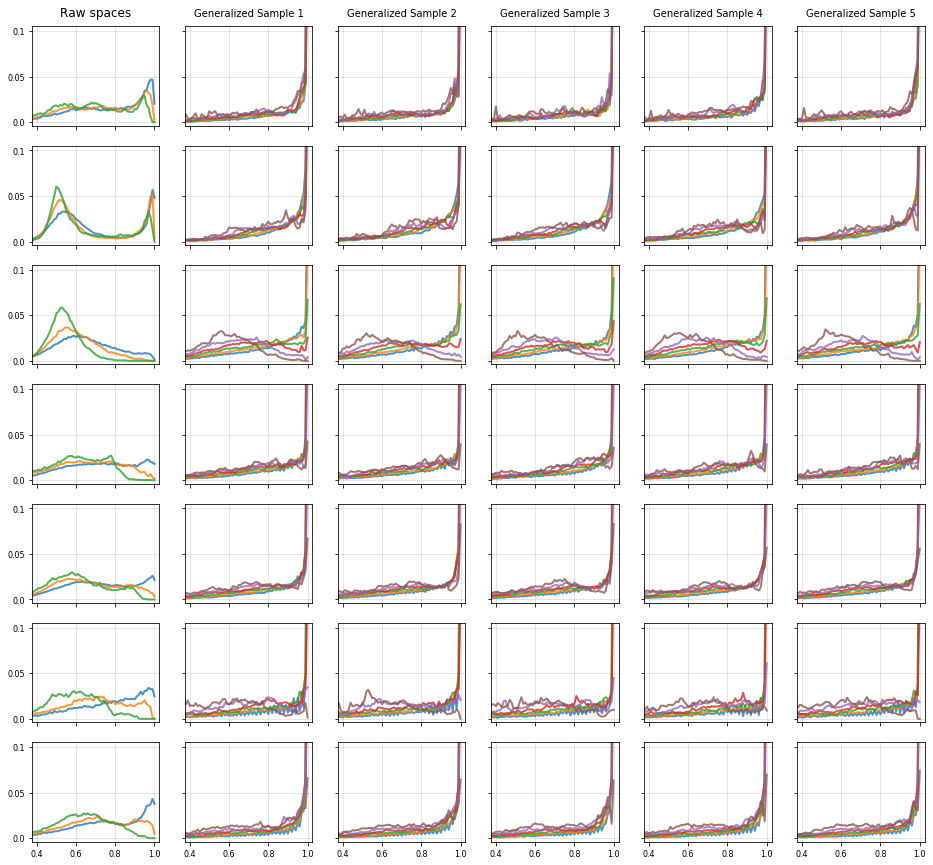

In [263]:
"""
Plotting the (estimate) PDF, i.e. normalized histogram, for Raw and Generalized spaces
"""

with open("properties/raw_cdf_values.pickle",'rb') as f:
    raw_norm_cdf_values = pickle.load(f)

fig=plt.figure(figsize=(16, 15)) ##fig=plt.figure(figsize=(80, 80))

linewidth = 5

figures_list = []

neighbor_sizes = 50*2**np.arange(6)

for n in np.arange(7):    
    figures_list.append([
        fig.add_subplot(7,6,n*6+1),
        fig.add_subplot(7,6,n*6+2),
        fig.add_subplot(7,6,n*6+3),
        fig.add_subplot(7,6,n*6+4),
        fig.add_subplot(7,6,n*6+5),
        fig.add_subplot(7,6,n*6+6),
    ])
    
for i_n, per_neighbor_values in enumerate(raw_norm_cdf_values[1::2]):

    per_neighbor_dist_values = []
    per_neighbor_legends = []
    
    for i_s, [hist, cum_y, values, auc] in enumerate(per_neighbor_values):
        
        ax1 = figures_list[i_s][0]

        #color = np.mean(np.abs(normal_product))
        ax1.plot(
            values[1:], 
            hist/np.sum(hist), 
            alpha = 0.8, 
            color = colors[i_n], #mpl.cm.viridis(color), 
            linewidth = 2,
            label = str(neighbor_sizes[i_n+2])
        )
        
        ax1.set_ylim(-0.004,0.105)
        ax1.set_xlim(0.375,1.025)
        
        if i_s == 0 and i_n == 0:
            ax1.text(
                0.5,1.1,
                "Raw spaces",
                horizontalalignment='center',
                fontsize = 12,
                transform=ax1.transAxes                
            )

        if i_n == len(neighbor_sizes)-3:
            ax1.text(
                .7,.8,contiguous_names[i_s],
                horizontalalignment='center',
                fontsize = 12,
                transform=ax1.transAxes
            )
        
        ax1.set_xticks(np.arange(0.4,1.1,0.2))
        ax1.set_yticks(np.arange(0.0,0.11,0.05))

        if i_s != 6: 
            ax1.set_xticklabels([])
        else:
            ax1.set_xticklabels(np.around(np.arange(0.4,1.1,0.2), decimals = 1), fontsize = 8)

        ax1.set_yticklabels(np.arange(0.0,0.11,0.05), fontsize = 8)
        
        ax1.grid(alpha=0.4)
            
        if i_n == len(neighbor_sizes)-3 and i_s == 0:
            ax1.legend(loc = "upper left", ncol = 1, fontsize = 8)#, bbox_to_anchor=(0, 1.3))
    

# RANSAC
ransac_sim_dist_values = [] # auc and sim dist ratio

"""
                hist,
                CY,
                values,
                np.trapz(CY, values[1:]),
                neighbor_size
"""

for i_t, per_trial_values in enumerate(ransac_norm_cdf_values):

    per_neighbor_dist_values = []
    
    for i_s, [o_, per_neighbor_values] in enumerate(per_trial_values):
        
        per_trial_dist_values = []
        
        ax = figures_list[i_s][i_t+1]

        for i_n, [hist, cum_y, values, auc, size] in enumerate(per_neighbor_values):
            
            per_trial_dist_values.append([
                np.sum(hist[90:])/np.sum(hist[:90]),
                np.sum(hist[95:])/np.sum(hist[:95]),
                np.sum(hist[95:])/np.sum(hist)
            ])
            
            #if size not in [100, 400, 1600]: continue

            #color = np.mean(np.abs(normal_product))
            ax.plot(
                values[1:], 
                hist/np.sum(hist), 
                alpha = 0.8, 
                #color = colors[i_n-2], #mpl.cm.viridis(color), 
                linewidth = 2,
                label = str(size)
            )
            
            ax.grid(alpha=0.4)
            ax.set_ylim(-0.004,0.105)
            ax.set_xlim(0.375,1.025)
            
            ax.set_xticks(np.arange(0.4,1.1,0.2))
            ax.set_yticks(np.arange(0.0,0.11,0.05))
            
            if i_s == 0 and i_n == 4:
                ax.text(
                    0.5,1.1,
                    "Generalized Sample "+str(i_t+1),
                    horizontalalignment='center',
                    fontsize = 10,
                    transform=ax.transAxes                
                )
            
            if i_s != 6: 
                ax.set_xticklabels([])
            else:
                ax.set_xticklabels(np.around(np.arange(0.4,1.1,0.2), decimals = 1), fontsize = 8)
                
            #ax.set_yticklabels(np.arange(0.0,0.11,0.05), fontsize = 8)
            ax.set_yticklabels([])
            
            """
            if i_n == len(neighbor_sizes)-1 and i_s == 0:
                ax1.legend(loc = "upper left", ncol = 8, fontsize = 10, bbox_to_anchor=(0, 1.3))
                #ax2.legend(loc = "upper left", ncol = 2, fontsize = 8)
            """
            
        per_neighbor_dist_values.append(per_trial_dist_values)
        
    ransac_sim_dist_values.append(per_neighbor_dist_values)
    
    #sim_dist_values.append(per_neighbor_dist_values)

plt.savefig('properties/generalized-norm-sim.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/generalized-norm-sim.png', format='png', dpi=300,bbox_inches = 'tight')

#plt.show()


In [264]:
raw_sim_dist_values = np.asarray(raw_sim_dist_values)
ransac_sim_dist_values = np.asarray(ransac_sim_dist_values)

raw_sim_dist_values.shape, ransac_sim_dist_values.shape

((7, 6, 3), (5, 7, 6, 3))

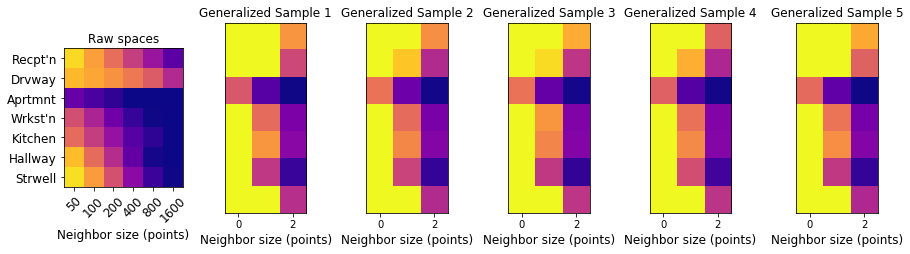

In [248]:
from matplotlib import gridspec

fig=plt.figure(figsize=(15,3.5))

ransac_sim_dist_values = np.asarray(ransac_sim_dist_values)
raw_sim_dist_values = np.asarray(raw_sim_dist_values)

gs = gridspec.GridSpec(1, 6, width_ratios=[1.01,1, 1, 1, 1, 1.085]) 

ax0 = plt.subplot(gs[0])#fig.add_subplot(1,6,1)

im0 = ax0.imshow(
    raw_sim_dist_values[:,:,-1], 
    cmap=mpl.cm.plasma,
    vmin=0.0, vmax=0.25# np.around(np.max(raw_sim_dist_values[:,:,0]),decimals = 1)
);

ax0.set_xticks(np.arange(len(neighbor_sizes)))
ax0.set_xticklabels(neighbor_sizes, rotation=45, fontsize = 12)
ax0.set_xlabel("Neighbor size (points)",fontsize = 12)
ax0.set_title("Raw spaces", fontsize = 12)

ax0.set_yticks(np.arange(len(contiguous_names)))
ax0.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);

for i_t in np.arange(ransac_sim_dist_values.shape[0]):
    
    ax = plt.subplot(gs[i_t+1])#fig.add_subplot(1,6,i_t+2)
    ax.set_aspect(1)

    im = ax.imshow(
        ransac_sim_dist_values[i_t,:,:,0], 
        cmap=mpl.cm.plasma,
        vmin=0.0, vmax=1.0 #np.around(np.max(raw_sim_dist_values[:,:,0]),decimals = 1)
    );
    
    #ax.set_xticks(np.arange(len(neighbor_sizes)))
    #ax.set_xticklabels(neighbor_sizes, rotation=45, fontsize = 12)
    ax.set_xlabel("Neighbor size (points)",fontsize = 12)
    
    ax.set_yticks([])
    ax.set_title("Generalized Sample "+str(i_t+1), fontsize = 12)

    """    
    if i_t == 0: 
        ax.set_yticks(np.arange(len(contiguous_names)))
        ax.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);
    
    
    #ax.set_title("Ratio of (high/low) AUC\n of Normal similarity", fontsize = 14)
    """
    if i_t == np.arange(ransac_sim_dist_values.shape[1])[-1]:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(im, cax = cax, format="%.1f")
        cbar.ax.set_yticklabels(np.append(np.arange(0,0.9,0.2, dtype = np.float32),'$\geq 1.0$'),fontsize = 12);

#plt.savefig('properties/ratio-norm-sim-v_f1-score.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
#plt.savefig('properties/ratio-norm-sim-v_f1-score.png', format='png', dpi=300,bbox_inches = 'tight')


"\nax2.set_xticks(np.arange(0,6))\nax2.set_xticklabels(np.arange(0.25, 3.0, 0.5),fontsize = 14)\nax2.set_xlabel('Partial radius', fontsize = 14)\nax2.set_yticks(np.arange(0,7,1))\n#plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)\nax2.set_yticklabels(contiguous_names_short,fontsize = 12)\n#plt.yticklabels(\n"

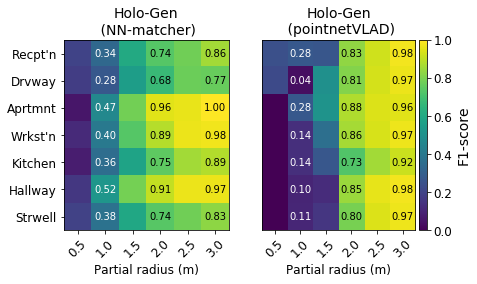

In [227]:
fig = plt.figure(figsize=(6.5,3.5))

with open("testing_results/pointnetvlad_arcore/" + "arcore_summary_results.pickle",'rb') as f:
    arcore_pv_results, arcore_pv_per_space_score, arcore_pv_perf_scores = pickle.load(f)
    
with open("testing_results/pointnetvlad_prod/" + "summary_results.pickle",'rb') as f:
    pointnetvlad_results, pointnetvlad_per_space_score, pointnetvlad_perf_scores = pickle.load(f)
    
with open("testing_results/partial/" + "summary_results_1000.pickle",'rb') as f:
    nn_results_partials, nn_per_space_score, nn_perf_scores = pickle.load(f)
    
with open("testing_results/nn_matcher_arcore/" + "summary_results.pickle",'rb') as f:
    arcore_results_partials, arcore_nn_per_space_score, arcore_nn_perf_scores = pickle.load(f)

#fig3 = plt.figure(constrained_layout=True)
#gs = fig3.add_gridspec(3, 3)
ax2 = fig.add_subplot(121)
ax3 = fig.add_subplot(122)
#fig.figsize(8,3.5)

im2 = ax2.imshow(
    nn_per_space_score[1:12:2,0].T,
    vmin=0.0, vmax=1.0, aspect='auto',
    cmap = plt.cm.viridis
)

for i, per_radius in enumerate(nn_per_space_score[3:12:4,0]):
    
    for j, value in enumerate(per_radius):
        
        color = 'black'
        
        if i == 0: color = 'white'

        ax2.text(
            i*2+1, j,
            ha="center", va="center",
            s = "{:.2f}".format(value),
            fontsize = 10,
            color = color
        )

ax2.set_title("Holo-Gen\n (NN-matcher)", fontsize = 14)
ax2.set_xticks(np.arange(6))
ax2.set_xticklabels(nn_perf_scores[1:12:2,0], rotation=45, fontsize = 12)
ax2.set_xlabel("Partial radius (m)",fontsize = 12)
ax2.set_yticks(np.arange(len(contiguous_names)))
ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);
#ax2.set_yticks([])
#ax2.set_yticklabels([])
#ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);

im3 = ax3.imshow(
    pointnetvlad_per_space_score[1:12:2,0].T,
    vmin=0.0, vmax=1.0, aspect='auto',
    cmap = plt.cm.viridis
)

for i, per_radius in enumerate(pointnetvlad_per_space_score[3:12:4,0]):
    
    for j, value in enumerate(per_radius):
        
        color = 'black'
        
        if i == 0: color = 'white'

        ax3.text(
            i*2+1, j,
            ha="center", va="center",
            s = "{:.2f}".format(value),
            fontsize = 10,
            color = color
        )

ax3.set_title("Holo-Gen\n (pointnetVLAD)", fontsize = 14)
ax3.set_xticks(np.arange(6))
ax3.set_xticklabels(pointnetvlad_perf_scores[1:12:2,0], rotation=45, fontsize = 12)
ax3.set_xlabel("Partial radius (m)",fontsize = 12)
ax3.set_yticks([])
ax3.set_yticklabels([])
#ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);

# Create divider for existing axes instance
divider3 = make_axes_locatable(ax3)
# Append axes to the right of ax3, with 20% width of ax3
cax3 = divider3.append_axes("right", size="5%", pad=0.05)

# Create colorbar in the appended axes
# Tick locations can be set with the kwarg `ticks`
# and the format of the ticklabels with kwarg `format`
cbar3 = plt.colorbar(im3, cax=cax3, ticks=np.arange(0.0,1.1,0.2), format="%.1f")
#cbar1.ax.set_ylabel("F1-score", fontsize = 14)

cbar3.ax.set_yticklabels(
    np.around(np.arange(0.0,1.1,0.2),decimals = 2),
#    np.concatenate((['≤ 0.4'],np.around(np.arange(0.5,1.1,0.1), decimals = 2))),
    fontsize = 12);
cbar3.ax.set_ylabel("F1-score", fontsize = 14)
"""
ax2.set_xticks(np.arange(0,6))
ax2.set_xticklabels(np.arange(0.25, 3.0, 0.5),fontsize = 14)
ax2.set_xlabel('Partial radius', fontsize = 14)
ax2.set_yticks(np.arange(0,7,1))
#plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)
ax2.set_yticklabels(contiguous_names_short,fontsize = 12)
#plt.yticklabels(
"""
#plt.xlabel('Partial radius', fontsize = 14)
#plt.xticks(np.arange(0,6),np.arange(0.25, 1.6, 0.25),fontsize = 14)
#plt.show()

#plt.savefig('properties/nnmatcher-f1-scores.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
#plt.savefig('properties/nnmatcher-f1-scores.png', format='png', dpi=300,bbox_inches = 'tight')


In [233]:
for i_r, per_radius in enumerate(pointnetvlad_per_space_score[3:12:4,0]):
            
    for i_n, neighbor_size in enumerate(neighbor_sizes):
        
        if neighbor_size not in neighbor_sizes[1::2]: continue
        print(neighbor_size,i_r+1,np.corrcoef(raw_sim_dist_values[:,i_n,-1],per_radius)[0,1])


100 1 -0.4581486304617804
400 1 -0.3520119753816785
1600 1 -0.32261362293130164
100 2 -0.36121475284383936
400 2 -0.2370088089991637
1600 2 -0.06336123352276762
100 3 0.438618219410386
400 3 0.340172794992174
1600 3 0.23935386169459313


In [234]:
for i_r, per_radius in enumerate(nn_per_space_score[3:12:4,0]):
            
    for i_n, neighbor_size in enumerate(neighbor_sizes):
        
        if neighbor_size not in neighbor_sizes[1::2]: continue
        print(neighbor_size,i_r+1,np.corrcoef(raw_sim_dist_values[:,i_n,-1],per_radius)[0,1])


100 1 -0.5228994982230474
400 1 -0.7516561900235147
1600 1 -0.7309288079688921
100 2 -0.797233024930382
400 2 -0.8356383619669341
1600 2 -0.6592772374227667
100 3 -0.8006785115563056
400 3 -0.8845130839366858
1600 3 -0.7438009722122796


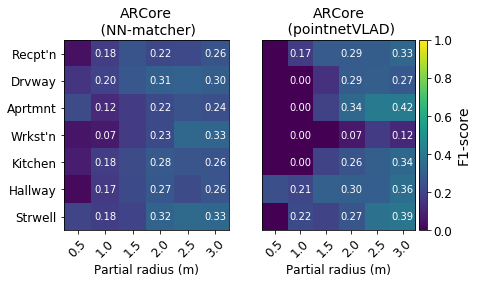

In [298]:
fig = plt.figure(figsize=(6.5,3.5))

with open("testing_results/pointnetvlad_arcore/" + "arcore_summary_results.pickle",'rb') as f:
    arcore_pv_results, arcore_pv_per_space_score, arcore_pv_perf_scores = pickle.load(f)
    
with open("testing_results/pointnetvlad_prod/" + "summary_results.pickle",'rb') as f:
    pointnetvlad_results, pointnetvlad_per_space_score, pointnetvlad_perf_scores = pickle.load(f)
    
with open("testing_results/partial/" + "summary_results_1000.pickle",'rb') as f:
    nn_results_partials, nn_per_space_score, nn_perf_scores = pickle.load(f)
    
with open("testing_results/nn_matcher_arcore/" + "summary_results.pickle",'rb') as f:
    arcore_results_partials, arcore_nn_per_space_score, arcore_nn_perf_scores = pickle.load(f)

#fig3 = plt.figure(constrained_layout=True)
#gs = fig3.add_gridspec(3, 3)
ax2 = fig.add_subplot(121)
ax3 = fig.add_subplot(122)
#fig.figsize(8,3.5)

im2 = ax2.imshow(
    arcore_nn_per_space_score[1:12:2,0].T,
    vmin=0.0, vmax=1.0, aspect='auto',
    cmap = plt.cm.viridis
)

for i, per_radius in enumerate(arcore_nn_per_space_score[3:12:4,0]):
    
    for j, value in enumerate(per_radius):
        
        color = 'white'
        
        if i == 0: color = 'white'

        ax2.text(
            i*2+1, j,
            ha="center", va="center",
            s = "{:.2f}".format(value),
            fontsize = 10,
            color = color
        )

ax2.set_title("ARCore\n (NN-matcher)", fontsize = 14)
ax2.set_xticks(np.arange(6))
ax2.set_xticklabels(arcore_nn_perf_scores[1:12:2,0], rotation=45, fontsize = 12)
ax2.set_xlabel("Partial radius (m)",fontsize = 12)
ax2.set_yticks(np.arange(len(contiguous_names)))
ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);
#ax2.set_yticks([])
#ax2.set_yticklabels([])
#ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);

im3 = ax3.imshow(
    arcore_pv_per_space_score[1:12:2,0].T,
    vmin=0.0, vmax=1.0, aspect='auto',
    cmap = plt.cm.viridis
)

for i, per_radius in enumerate(arcore_pv_per_space_score[3:12:4,0]):
    
    for j, value in enumerate(per_radius):
        
        color = 'white'
        
        if i == 0: color = 'white'

        ax3.text(
            i*2+1, j,
            ha="center", va="center",
            s = "{:.2f}".format(value),
            fontsize = 10,
            color = color
        )

ax3.set_title("ARCore\n (pointnetVLAD)", fontsize = 14)
ax3.set_xticks(np.arange(6))
ax3.set_xticklabels(arcore_pv_perf_scores[1:12:2,0], rotation=45, fontsize = 12)
ax3.set_xlabel("Partial radius (m)",fontsize = 12)
ax3.set_yticks([])
ax3.set_yticklabels([])
#ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);

# Create divider for existing axes instance
divider3 = make_axes_locatable(ax3)
# Append axes to the right of ax3, with 20% width of ax3
cax3 = divider3.append_axes("right", size="5%", pad=0.05)

# Create colorbar in the appended axes
# Tick locations can be set with the kwarg `ticks`
# and the format of the ticklabels with kwarg `format`
cbar3 = plt.colorbar(im3, cax=cax3, ticks=np.arange(0.0,1.1,0.2), format="%.1f")
#cbar1.ax.set_ylabel("F1-score", fontsize = 14)

cbar3.ax.set_yticklabels(
    np.around(np.arange(0.0,1.1,0.2),decimals = 2),
#    np.concatenate((['≤ 0.4'],np.around(np.arange(0.5,1.1,0.1), decimals = 2))),
    fontsize = 12);
cbar3.ax.set_ylabel("F1-score", fontsize = 14)
"""
ax2.set_xticks(np.arange(0,6))
ax2.set_xticklabels(np.arange(0.25, 3.0, 0.5),fontsize = 14)
ax2.set_xlabel('Partial radius', fontsize = 14)
ax2.set_yticks(np.arange(0,7,1))
#plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)
ax2.set_yticklabels(contiguous_names_short,fontsize = 12)
#plt.yticklabels(
"""
#plt.xlabel('Partial radius', fontsize = 14)
#plt.xticks(np.arange(0,6),np.arange(0.25, 1.6, 0.25),fontsize = 14)
#plt.show()

plt.savefig('properties/arcore-f1-scores-annotated.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/arcore-f1-scores-annotated.png', format='png', dpi=300,bbox_inches = 'tight')


In [301]:
for i_r, per_radius in enumerate(arcore_pv_per_space_score[3:12:4,0]):
            
    for i_n, neighbor_size in enumerate(neighbor_sizes):
        
        if neighbor_size not in neighbor_sizes[1::2]: continue
        print(neighbor_size,i_r+1,np.corrcoef(arcore_sim_dist_values[:,i_n,-1],per_radius)[0,1])


100 1 0.7349277846062267
400 1 0.7272523662103272
1600 1 0.706639858009685
100 2 0.2646601802377461
400 2 0.21180637642556127
1600 2 -0.06880930527758386
100 3 0.3607548355009835
400 3 0.3104453633629582
1600 3 0.12443640858930431


In [302]:
for i_r, per_radius in enumerate(arcore_nn_per_space_score[3:12:4,0]):
            
    for i_n, neighbor_size in enumerate(neighbor_sizes):
        
        if neighbor_size not in neighbor_sizes[1::2]: continue
        print(neighbor_size,i_r+1,np.corrcoef(arcore_sim_dist_values[:,i_n,-1],per_radius)[0,1])


100 1 0.712242934338191
400 1 0.6993712868597222
1600 1 0.4059363112318063
100 2 0.4033914627720891
400 2 0.5236671781116767
1600 2 0.3746483683695636
100 3 0.008000310619793045
400 3 0.0877686589028072
1600 3 0.20320536823939475


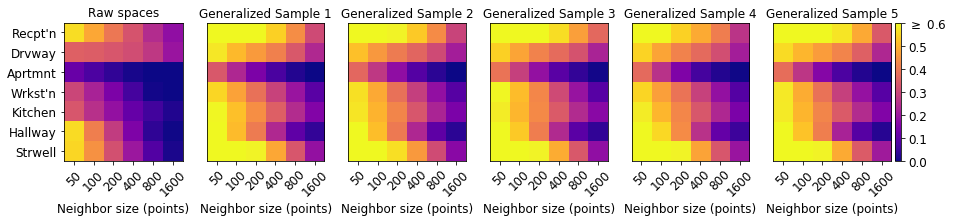

In [277]:
from matplotlib import gridspec

fig=plt.figure(figsize=(15,3.5))

ransac_sim_dist_values = np.asarray(ransac_sim_dist_values)
raw_sim_dist_values = np.asarray(raw_sim_dist_values)

gs = gridspec.GridSpec(1, 6, width_ratios=[1.01,1, 1, 1, 1, 1.085]) 

ax0 = plt.subplot(gs[0])#fig.add_subplot(1,6,1)

im0 = ax0.imshow(
    raw_sim_dist_values[:,:,0], 
    cmap=mpl.cm.plasma,
    vmin=0.0, vmax=0.6# np.around(np.max(raw_sim_dist_values[:,:,0]),decimals = 1)
);

ax0.set_xticks(np.arange(len(neighbor_sizes)))
ax0.set_xticklabels(neighbor_sizes, rotation=45, fontsize = 12)
ax0.set_xlabel("Neighbor size (points)",fontsize = 12)
ax0.set_title("Raw spaces", fontsize = 12)

ax0.set_yticks(np.arange(len(contiguous_names)))
ax0.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);

for i_t in np.arange(ransac_sim_dist_values.shape[0]):
    
    ax = plt.subplot(gs[i_t+1])#fig.add_subplot(1,6,i_t+2)
    ax.set_aspect(1)

    im = ax.imshow(
        ransac_sim_dist_values[i_t,:,:,-1], 
        cmap=mpl.cm.plasma,
        vmin=0.0, vmax=0.6 #np.around(np.max(raw_sim_dist_values[:,:,0]),decimals = 1)
    );
    
    ax.set_xticks(np.arange(len(neighbor_sizes)))
    ax.set_xticklabels(neighbor_sizes, rotation=45, fontsize = 12)
    ax.set_xlabel("Neighbor size (points)",fontsize = 12)
    
    ax.set_yticks([])
    ax.set_title("Generalized Sample "+str(i_t+1), fontsize = 12)

    """    
    if i_t == 0: 
        ax.set_yticks(np.arange(len(contiguous_names)))
        ax.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);
    
    
    #ax.set_title("Ratio of (high/low) AUC\n of Normal similarity", fontsize = 14)
    """
    if i_t == np.arange(ransac_sim_dist_values.shape[0])[-1]:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(im, cax = cax, format="%.1f")
        cbar.ax.set_yticklabels(np.append(np.arange(0,0.6,0.1, dtype = np.float32),'$\geq$ 0.6'),fontsize = 12);

plt.savefig('properties/generalized-high-norm-sim-all.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/generalized-high-norm-sim-all.png', format='png', dpi=300,bbox_inches = 'tight')


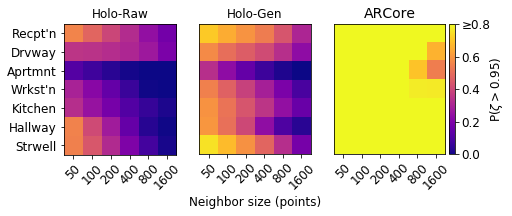

In [297]:
from matplotlib import gridspec

fig=plt.figure(figsize=(7,3.5))

ransac_sim_dist_values = np.asarray(ransac_sim_dist_values)
raw_sim_dist_values = np.asarray(raw_sim_dist_values)

gs = gridspec.GridSpec(1, 3, width_ratios=[1.01, 1, 1.085]) 

ax0 = plt.subplot(gs[0])#fig.add_subplot(1,6,1)

im0 = ax0.imshow(
    raw_sim_dist_values[:,:,0], 
    cmap=mpl.cm.plasma,
    vmin=0.0, vmax=0.8# np.around(np.max(raw_sim_dist_values[:,:,0]),decimals = 1)
);

ax0.set_xticks(np.arange(len(neighbor_sizes)))
ax0.set_xticklabels(neighbor_sizes, rotation=45, fontsize = 12)
#ax0.set_xlabel("Neighbor size (points)",fontsize = 12)
ax0.set_title("Holo-Raw", fontsize = 12)

ax0.set_yticks(np.arange(len(contiguous_names)))
ax0.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);

    
ax1 = plt.subplot(gs[1])#fig.add_subplot(1,6,i_t+2)
ax1.set_aspect(1)

im = ax1.imshow(
    ransac_sim_dist_values[0,:,:,-1], 
    cmap=mpl.cm.plasma,
    vmin=0.0, vmax=0.8 #np.around(np.max(raw_sim_dist_values[:,:,0]),decimals = 1)
);

ax1.set_xticks(np.arange(len(neighbor_sizes)))
ax1.set_xticklabels(neighbor_sizes, rotation=45, fontsize = 12)
ax1.set_xlabel("Neighbor size (points)",fontsize = 12)

ax1.set_yticks([])
ax1.set_title("Holo-Gen", fontsize = 12)

ax2 = plt.subplot(gs[2])#fig.add_subplot(1,6,i_t+2)

im2 = ax2.imshow(
    arcore_sim_dist_values[:,:,-1], 
    cmap=mpl.cm.plasma,
    vmin=0.0, vmax=0.8,#np.around(np.max(raw_sim_dist_values[:,:,1]),decimals = 1)
);
ax2.set_xticks(np.arange(len(neighbor_sizes)))
ax2.set_xticklabels(neighbor_sizes, rotation=45, fontsize = 12)
ax2.set_yticks([])
#ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);
#ax2.set_xlabel("Neighbor size (points)",fontsize = 12)
ax2.set_title("ARCore", fontsize = 14)

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar2 = plt.colorbar(im2, cax = cax2, format="%.1f")
cbar2.ax.set_yticklabels(
    np.concatenate((np.around(np.arange(0,0.8,0.2), decimals = 1),['≥0.8'])),
    fontsize = 12
);
cbar2.ax.set_ylabel("P($\zeta > 0.95$)", fontsize = 12, labelpad = -2.5)

plt.savefig('properties/heatmap-high-norm-sim.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/heatmap-high-norm-sim.png', format='png', dpi=300,bbox_inches = 'tight')


In [ ]:
    """    
    if i_t == 0: 
        ax.set_yticks(np.arange(len(contiguous_names)))
        ax.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);
    
    
    #ax.set_title("Ratio of (high/low) AUC\n of Normal similarity", fontsize = 14)
    """
    if i_t == np.arange(ransac_sim_dist_values.shape[0])[-1]:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(im, cax = cax, format="%.1f")
        cbar.ax.set_yticklabels(np.append(np.arange(0,0.6,0.1, dtype = np.float32),'$\geq$ 0.6'),fontsize = 12);

plt.savefig('properties/generalized-high-norm-sim-all.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/generalized-high-norm-sim-all.png', format='png', dpi=300,bbox_inches = 'tight')

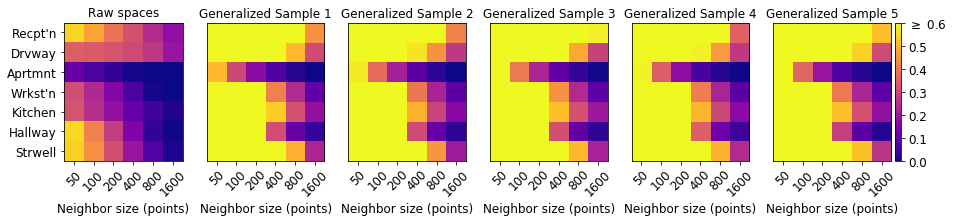

In [572]:
from matplotlib import gridspec

fig=plt.figure(figsize=(15,3.5))

ransac_sim_dist_values = np.asarray(ransac_sim_dist_values)
raw_sim_dist_values = np.asarray(raw_sim_dist_values)

gs = gridspec.GridSpec(1, 6, width_ratios=[1.01,1, 1, 1, 1, 1.085]) 

ax0 = plt.subplot(gs[0])#fig.add_subplot(1,6,1)

im0 = ax0.imshow(
    raw_sim_dist_values[:,:,0].T, 
    cmap=mpl.cm.plasma,
    vmin=0.0, vmax=0.6# np.around(np.max(raw_sim_dist_values[:,:,0]),decimals = 1)
);

ax0.set_xticks(np.arange(len(neighbor_sizes)))
ax0.set_xticklabels(neighbor_sizes, rotation=45, fontsize = 12)
ax0.set_xlabel("Neighbor size (points)",fontsize = 12)
ax0.set_title("Raw spaces", fontsize = 12)

ax0.set_yticks(np.arange(len(contiguous_names)))
ax0.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);

for i_t in np.arange(ransac_sim_dist_values.shape[1]):
    
    ax = plt.subplot(gs[i_t+1])#fig.add_subplot(1,6,i_t+2)
    ax.set_aspect(1)

    im = ax.imshow(
        ransac_sim_dist_values[:,i_t,:,1].T, 
        cmap=mpl.cm.plasma,
        vmin=0.0, vmax=0.6 #np.around(np.max(raw_sim_dist_values[:,:,0]),decimals = 1)
    );
    
    ax.set_xticks(np.arange(len(neighbor_sizes)))
    ax.set_xticklabels(neighbor_sizes, rotation=45, fontsize = 12)
    ax.set_xlabel("Neighbor size (points)",fontsize = 12)
    
    ax.set_yticks([])
    ax.set_title("Generalized Sample "+str(i_t+1), fontsize = 12)

    """    
    if i_t == 0: 
        ax.set_yticks(np.arange(len(contiguous_names)))
        ax.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);
    
    
    #ax.set_title("Ratio of (high/low) AUC\n of Normal similarity", fontsize = 14)
    """
    if i_t == np.arange(ransac_sim_dist_values.shape[1])[-1]:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(im, cax = cax, format="%.1f")
        cbar.ax.set_yticklabels(np.append(np.arange(0,0.6,0.1, dtype = np.float32),'$\geq$ 0.6'),fontsize = 12);

plt.savefig('properties/generalized-ratio-norm-sim.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/generalized-ratio-norm-sim.png', format='png', dpi=300,bbox_inches = 'tight')


[0.65242409 0.55173603 0.51170431 0.47712681 0.44983529 0.42835473
 0.4087256 ]
[0.36118218 0.34972496 0.34398905 0.34088661 0.33789278 0.33294308
 0.32914614]
[0.16234067 0.11777791 0.09214234 0.07525089 0.06248724 0.05325623
 0.0454278 ]
[0.39677967 0.31266136 0.26713396 0.23688612 0.21476332 0.19283468
 0.17693866]
[0.41529291 0.32744867 0.28111816 0.25173688 0.22974597 0.2118058
 0.19777853]
[0.70155988 0.55666942 0.46663704 0.41301788 0.36649757 0.33222306
 0.30579739]
[0.63541514 0.54370356 0.48335809 0.43942277 0.40368295 0.37150754
 0.33936799]


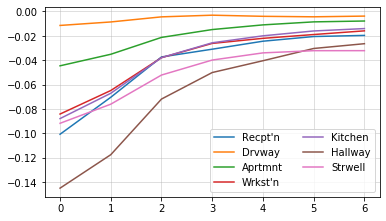

In [234]:
fig=plt.figure(figsize=(6,3.5))

plt.grid(alpha = 0.5)

for i, auc_ratio in enumerate(sim_dist_values[:,:,0].T):
    print(auc_ratio)
    plt.plot(
        np.gradient(auc_ratio),
        label = contiguous_names_short[i]
    )
    
plt.legend(ncol = 2)

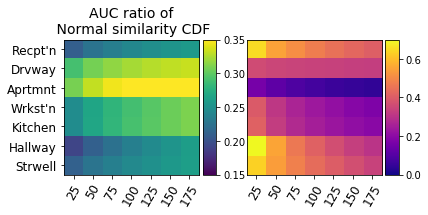

In [177]:
fig=plt.figure(figsize=(6,2.5))

ax1 = fig.add_subplot(1,2,1)

#auc_values = np.asarray(auc_values)

im1 = ax1.imshow(
    sim_dist_values[:,:,1].T, 
    cmap=mpl.cm.viridis,
    vmin=0.15, vmax=0.35
);
plt.xticks(np.arange(7),neighbor_sizes, rotation=60, fontsize = 12)
plt.yticks(np.arange(7),contiguous_names_short,rotation=0, fontsize = 12);

plt.title("AUC ratio of\n Normal similarity CDF", fontsize = 14)

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="10%", pad=0.05)

cbar1 = plt.colorbar(im1, cax = cax1)#, ticks=np.arange(0,1.1,0.2), format="%.2f")
#cbar.ax.set_ylabel("F1-score", fontsize = 14)

ax2 = fig.add_subplot(1,2,2)

#auc_values = np.asarray(auc_values)

im2 = ax2.imshow(
    sim_dist_values[:,:,0].T, 
    cmap=mpl.cm.plasma,
    vmin=0.0, vmax=0.7
);
plt.xticks(np.arange(7),neighbor_sizes, rotation=60, fontsize = 12)
plt.yticks([])#,rotation=0, fontsize = 12);

#plt.title("Normal similarity PDF Ratio", fontsize = 14)

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="10%", pad=0.05)

cbar2 = plt.colorbar(im2, cax = cax2)


Done with 10 in 2.558 seconds
Done with 30 in 4.732 seconds
Done with 50 in 6.779 seconds
Done with 70 in 9.088 seconds


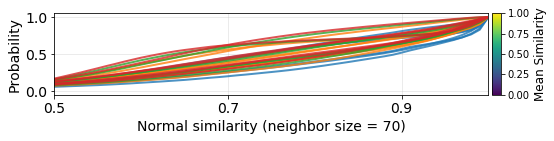

In [90]:
fig=plt.figure(figsize=(8, 1.5)) ##fig=plt.figure(figsize=(80, 80))

linewidth = 5

auc_values = []

for i, neighbor_size in enumerate([10,30,50,70]):
    
    t0 = time.time()
    #neighbor_size = 30

    per_neighbor_auc = []
    
    # Of all spaces
    for obj_name, pointCloud, triangles in new_contiguous_point_collection:

        nbrs = NearestNeighbors(n_neighbors=neighbor_size, algorithm='kd_tree').fit(pointCloud[:,:3])
        distances, indices = nbrs.kneighbors(pointCloud[:,:3])

        try:
            nearby_normals = pointCloud[indices,3:6]
            refrnc_normals = np.reshape(np.repeat(pointCloud[:,3:6],neighbor_size,axis=0),nearby_normals.shape)

            normal_product = np.sum(np.multiply(refrnc_normals,nearby_normals),axis=2)
        except Exception as e1:
            print("getLocalSelfSimilarity: Error while getting normals,", e1)

        color = np.mean(np.abs(normal_product))
        hist, values = np.histogram(np.mean(np.abs(normal_product),axis = 1), bins = np.arange(0,1.01,0.01))
        CY = np.cumsum(hist/np.sum(hist))
        plt.plot(
            values[1:], 
            CY, 
            alpha = 0.8, 
            color = colors[i], #mpl.cm.viridis(color), 
            linewidth = 2
        )
        
        per_neighbor_auc.append(np.trapz(CY, values[1:]))

    print("Done with {} in {:.3f} seconds".format(neighbor_size,time.time()-t0))
    
    auc_values.append(per_neighbor_auc)

plt.xlabel("Normal similarity (neighbor size = {})".format(neighbor_size), fontsize = 14)
plt.xlim(0.5,1)
plt.xticks(np.arange(0.5,1.0,0.2),fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(alpha=0.3)
#plt.legend([p1, p2],['Sphere','Cube'],fontsize = 14);
plt.ylabel('Probability', fontsize = 14)

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="2%", pad=0.05)    
cb1 = mpl.colorbar.ColorbarBase(ax_cb, cmap=mpl.cm.viridis, orientation='vertical')
cb1.set_label('Mean Similarity', fontsize = 12)
plt.gcf().add_axes(ax_cb)

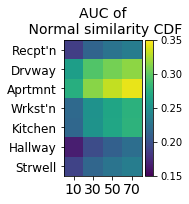

In [94]:
fig=plt.figure(figsize=(6,2.5))

ax = fig.add_subplot(1,2,1)

auc_values = np.asarray(auc_values)

im1 = ax.imshow(
    auc_values.T, 
    cmap=mpl.cm.viridis,
    vmin=0.15, vmax=0.35
);
plt.xticks([0,1,2,3],[10,30,50,70], fontsize = 14)
plt.yticks(np.arange(7),contiguous_names_short,rotation=0, fontsize = 12);

plt.title("AUC of\n Normal similarity CDF", fontsize = 14)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.05)

cbar = plt.colorbar(im1, cax = cax)#, ticks=np.arange(0,1.1,0.2), format="%.2f")
#cbar.ax.set_ylabel("F1-score", fontsize = 14)


# Performance Scores

In [95]:

with open('testing_results/partial/results_partials_nn_matcher.pickle', 'rb') as f:
    results_partials, raw_errors, ransac_errors = pickle.load(f)

per_space_score = []
perf_scores = []

#desired_r = [0.5, 1.0, 3.0]

for radius, partial_errors in ransac_errors:

    score_map = np.zeros((7,7))

    for score in partial_errors:
        score_map[int(score[0]),int(score[3])]+=1
        
    macro_score = f1_score(partial_errors[:,0],partial_errors[:,3],average='macro')
    micro_score = f1_score(partial_errors[:,0],partial_errors[:,3],average='micro')
    mcc = matthews_corrcoef(partial_errors[:,0],partial_errors[:,3])
    ave_prec_score = precision_score(partial_errors[:,0],partial_errors[:,3],average='macro')
    prec_score = precision_score(partial_errors[:,0],partial_errors[:,3],average=None)
    ave_recl_score = recall_score(partial_errors[:,0],partial_errors[:,3],average='macro')
    recl_score = recall_score(partial_errors[:,0],partial_errors[:,3],average=None)
    
    per_space_score.append([
        f1_score(partial_errors[:,0],partial_errors[:,3],average=None),
        prec_score,
        recl_score
    ])
    
    perf_scores.append([
        radius,
        macro_score,
        micro_score,
        mcc,
        (np.sum(score_map) - np.trace(score_map))/np.sum(score_map)
    ])
    
per_space_score = np.asarray(per_space_score)
perf_scores = np.asarray(perf_scores)

with open("testing_results/partial/" + "summary_results.pickle",'wb') as f:
    pickle.dump([results_partials, per_space_score, perf_scores],f)
    

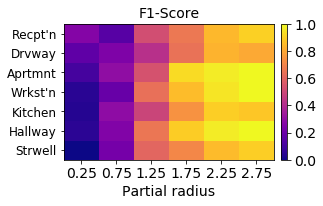

In [93]:
fig=plt.figure(figsize=(4,2.5))

ax1 = fig.add_subplot(1,1,1)

im1 = ax1.imshow(
    per_space_score[:,0].T,
    vmin=0, vmax=1.0, aspect='auto',
    cmap = plt.cm.plasma
)

# Create divider for existing axes instance
divider1 = make_axes_locatable(ax1)
# Append axes to the right of ax3, with 20% width of ax3
cax1 = divider1.append_axes("right", size="3%", pad=0.1)

# Create colorbar in the appended axes
# Tick locations can be set with the kwarg `ticks`
# and the format of the ticklabels with kwarg `format`
cbar1 = plt.colorbar(im1, cax=cax1, ticks=np.arange(0,1.6,0.2), format="%.2f")
#cbar1.ax.set_ylabel("F1-score", fontsize = 14)
cbar1.ax.set_yticklabels(np.arange(0,1.6,0.2, dtype = np.float32),fontsize = 14)

#cbar = plt.colorbar(ticks = np.arange(0,1.1,0.2))
#cbar.ax.set_ylabel("F1-score", fontsize = 14)
#cbar.ax.set_yticklabels(np.arange(0,1.1,0.2, dtype = np.float32),fontsize = 14)

ax1.set_title('F1-Score', fontsize = 14)
ax1.set_xticks(np.arange(0,6))
ax1.set_xticklabels(np.arange(0.25, 3.0, 0.5),fontsize = 14)
ax1.set_xlabel('Partial radius', fontsize = 14)
ax1.set_yticks(np.arange(0,7,1))
#plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)
ax1.set_yticklabels(contiguous_names_short,fontsize = 12)
#plt.yticklabels(

#plt.xlabel('Partial radius', fontsize = 14)
#plt.xticks(np.arange(0,6),np.arange(0.25, 1.6, 0.25),fontsize = 14)
plt.show()


# RANSAC Results

In [94]:
results_partials = [[],[]] 

raw_errors = []    
ransac_errors = []

for radius in np.arange(0.25, 3.1, 0.5):

    try:
        with bz2.BZ2File('testing_results/partial/ransac_{}_partial_scores_parallel_sample_points.pickle.bz2'.format(radius), 'r') as bz2_f:
            partial_scores_pool = pickle.load(bz2_f) 

    except:
        print("Error getting Raw scores for",radius)
        continue

    partial_errors_pool = NN_matcher(partial_scores_pool)
    correct_interspace_labels_idxs = np.where(partial_errors_pool[:,1]==0)[0]
    intraspace_errors  = partial_errors_pool[correct_interspace_labels_idxs,2]

    print(radius,"(Ransac) P1 Error Rate:",np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)) 
    print("   (Ransac) P2 Error Rate: {:.3f} (± {:.3f})".format(np.nanmean(intraspace_errors),np.nanstd(intraspace_errors))) 
    
    ransac_errors.append([
        radius,
        partial_errors_pool
    ])
    
    results_partials[1].append([
        radius,
        np.sum(partial_errors_pool[:,1])/len(partial_scores_pool),
        np.nanmean(intraspace_errors),
        np.nanstd(intraspace_errors)
    ])
    
    try:
        with bz2.BZ2File('testing_results/partial/raw_{}_partial_scores.pickle.bz2'.format(radius), 'r') as bz2_f:
            partial_scores_pool = pickle.load(bz2_f) 
            
    except:
        print("Error getting Raw scores for",radius)
        continue

    partial_errors_pool = NN_matcher(partial_scores_pool)
    correct_interspace_labels_idxs = np.where(partial_errors_pool[:,1]==0)[0]
    intraspace_errors  = partial_errors_pool[correct_interspace_labels_idxs,2]

    print(radius,"(Raw) P1 Error Rate:",np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)) 
    print("   (Raw) P2 Error Rate: {:.3f} (± {:.3f})".format(np.nanmean(intraspace_errors),np.nanstd(intraspace_errors))) 
    
    results_partials[0].append([
        radius,
        np.sum(partial_errors_pool[:,1])/len(partial_scores_pool),
        np.nanmean(intraspace_errors),
        np.nanstd(intraspace_errors)
    ])
    
    raw_errors.append([
        radius,
        partial_errors_pool
    ])
    
with open('testing_results/partial/results_partials_nn_matcher.pickle', 'wb') as f:
    pickle.dump([results_partials, raw_errors, ransac_errors],f)


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:690: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_match_threshold = good_match_threshold - 0.05
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.25 (Ransac) P1 Error Rate: 0.8383458646616542
   (Ransac) P2 Error Rate: 6.897 (± 2.967)
0.25 (Raw) P1 Error Rate: 0.8458646616541353
   (Raw) P2 Error Rate: 4.972 (± 1.552)
0.75 (Ransac) P1 Error Rate: 0.7593984962406015
   (Ransac) P2 Error Rate: 4.094 (± 3.706)
0.75 (Raw) P1 Error Rate: 0.6917293233082706
   (Raw) P2 Error Rate: 3.748 (± 3.658)
1.25 (Ransac) P1 Error Rate: 0.4473684210526316
   (Ransac) P2 Error Rate: 1.509 (± 1.841)
1.25 (Raw) P1 Error Rate: 0.05639097744360902
   (Raw) P2 Error Rate: 1.043 (± 1.182)
1.75 (Ransac) P1 Error Rate: 0.22556390977443608
   (Ransac) P2 Error Rate: 1.205 (± 1.277)
1.75 (Raw) P1 Error Rate: 0.0
   (Raw) P2 Error Rate: 0.897 (± 0.642)
2.25 (Ransac) P1 Error Rate: 0.09774436090225563
   (Ransac) P2 Error Rate: 1.253 (± 0.876)
Error getting Raw scores for 2.25
2.75 (Ransac) P1 Error Rate: 0.07518796992481203
   (Ransac) P2 Error Rate: 1.402 (± 0.825)
Error getting Raw scores for 2.75


In [97]:
# Results for ARCore dataset

arcore_results_partials = []

#raw_errors = []    
arcore_ransac_errors = []

with open('../../spatial-privacy/descriptors/chosen_arcore_res5_4by5_descriptors_complete.pickle','rb') as f:
    arcore_descriptors = pickle.load(f)

for radius in np.arange(0.25, 3.1, 0.25):

    try:
        with bz2.BZ2File("testing_results/nn_matcher_arcore/{}_partial_scores.pickle.bz2".format(radius), 'r') as bz2_f:
            partial_scores_pool = pickle.load(bz2_f) 

    except:
        print("Error getting arcore scores for",radius)
        continue

    partial_errors_pool = ARcore_NNMatcher(partial_scores_pool, descriptors)
    correct_interspace_labels_idxs = np.where(partial_errors_pool[:,1]==0)[0]
    intraspace_errors  = partial_errors_pool[correct_interspace_labels_idxs,2]

    print(radius,"(Ransac) P1 Error Rate:",np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)) 
    print("   (Ransac) P2 Error Rate: {:.3f} (± {:.3f})".format(np.nanmean(intraspace_errors),np.nanstd(intraspace_errors))) 

    arcore_results_partials.append([
        radius,
        np.sum(partial_errors_pool[:,1])/len(partial_scores_pool),
        np.nanmean(intraspace_errors),
        np.nanstd(intraspace_errors)
    ])
    
    arcore_ransac_errors.append([
        radius,
        partial_errors_pool
    ])
    
with open("testing_results/nn_matcher_arcore/results_partials_nn_matcher.pickle", 'wb') as f:
    pickle.dump([arcore_results_partials, arcore_ransac_errors],f)
    
arcore_nn_per_space_score = []
arcore_nn_perf_scores = []

#desired_r = [0.5, 1.0, 3.0]

for radius, partial_errors in arcore_ransac_errors:

    score_map = np.zeros((7,7))

    for score in partial_errors:
        score_map[int(score[0]),int(score[3])]+=1
        
    macro_score = f1_score(partial_errors[:,0],partial_errors[:,3],average='macro')
    micro_score = f1_score(partial_errors[:,0],partial_errors[:,3],average='micro')
    mcc = matthews_corrcoef(partial_errors[:,0],partial_errors[:,3])
    ave_prec_score = precision_score(partial_errors[:,0],partial_errors[:,3],average='macro')
    prec_score = precision_score(partial_errors[:,0],partial_errors[:,3],average=None)
    ave_recl_score = recall_score(partial_errors[:,0],partial_errors[:,3],average='macro')
    recl_score = recall_score(partial_errors[:,0],partial_errors[:,3],average=None)
    
    arcore_nn_per_space_score.append([
        f1_score(partial_errors[:,0],partial_errors[:,3],average=None),
        prec_score,
        recl_score
    ])
    
    arcore_nn_perf_scores.append([
        radius,
        macro_score,
        micro_score,
        mcc,
        (np.sum(score_map) - np.trace(score_map))/np.sum(score_map)
    ])
    
arcore_nn_per_space_score = np.asarray(arcore_nn_per_space_score)
arcore_nn_perf_scores = np.asarray(arcore_nn_perf_scores)

with open("testing_results/nn_matcher_arcore/" + "summary_results.pickle",'wb') as f:
    pickle.dump([arcore_results_partials, arcore_nn_per_space_score, arcore_nn_perf_scores],f)
    

NameError: name 'ARcore_NNMatcher' is not defined

# PointnetVLAD results

In [91]:
RESULTS_FOLDER="testing_results/pointnetvlad_prod/"
if not os.path.exists(RESULTS_FOLDER): os.mkdir(RESULTS_FOLDER)   
    
pickle_file = 'partial_results_updated_refs.pickle'

try:
    with open(RESULTS_FOLDER + pickle_file,'rb') as pickle_output:
        results_pickle = pickle.load(pickle_output)
except:
    print("No results.")
    
pointnetvlad_results = []
pointnetvlad_per_space_score = []
pointnetvlad_perf_scores= []

for radius, recall, intra_dist, test_recall in results_pickle:
    
    pointnetvlad_results.append([
        radius,
        recall[0],
        intra_dist[0]
    ])
    
    count_diff = 0

    errors_pool = []
    
    for m, n, top1_obj_cands in test_recall:
        
        if len(errors_pool) == 0:
            errors_pool = top1_obj_cands
        else:
            errors_pool = np.concatenate((errors_pool,top1_obj_cands), axis = 0)
            
        #print("  ",m,n,len(top1_obj_cands),len(errors_pool))
        
    macro_score = f1_score(errors_pool[:,0],errors_pool[:,1],average='macro')    
    micro_score = f1_score(errors_pool[:,0],errors_pool[:,1],average='micro')
    mcc = matthews_corrcoef(errors_pool[:,0],errors_pool[:,1])
    ave_prec_score = precision_score(errors_pool[:,0],errors_pool[:,1],average='macro')
    prec_score = precision_score(errors_pool[:,0],errors_pool[:,1],average=None)
    ave_recl_score = recall_score(errors_pool[:,0],errors_pool[:,1],average='macro')
    recl_score = recall_score(errors_pool[:,0],errors_pool[:,1],average=None)
    
    pointnetvlad_per_space_score.append([
        f1_score(errors_pool[:,0],errors_pool[:,1],average=None),
        prec_score,
        recl_score
    ])
    
    pointnetvlad_perf_scores.append([
        radius,
        macro_score,
        micro_score,
        mcc
        #(np.sum(score_map) - np.trace(score_map))/np.sum(score_map)
    ])

    1 - count_diff/len(test_recall)
    
    
pointnetvlad_results = np.asarray(pointnetvlad_results)
pointnetvlad_per_space_score = np.asarray(pointnetvlad_per_space_score)
pointnetvlad_perf_scores = np.asarray(pointnetvlad_perf_scores)

with open("testing_results/pointnetvlad_prod/" + "summary_results.pickle",'wb') as f:
    pickle.dump([pointnetvlad_results, pointnetvlad_per_space_score, pointnetvlad_perf_scores],f)
    

/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [92]:
#ARCORE REsults

RESULTS_FOLDER="testing_results/pointnetvlad_arcore/"
    
pickle_file = 'partial_results.pickle'

try:
    with open(RESULTS_FOLDER + pickle_file,'rb') as pickle_output:
        results_pickle = pickle.load(pickle_output)
except:
    print("No results.")
    
arcore_pv_results = []
arcore_pv_per_space_score = []
arcore_pv_perf_scores = []

for radius, recall, intra_dist, test_recall in results_pickle:
    
    arcore_pv_results.append([
        radius,
        recall[0],
        intra_dist[0]
    ])
    
    count_diff = 0

    errors_pool = []
    
    for m, n, top1_obj_cands in test_recall:
        if len(errors_pool) == 0:
            errors_pool = top1_obj_cands
        else:
            errors_pool = np.concatenate((errors_pool,top1_obj_cands), axis = 0)
            
        #print("  ",m,n,len(top1_obj_cands),len(errors_pool))
        
    macro_score = f1_score(errors_pool[:,0],errors_pool[:,1],average='macro')    
    micro_score = f1_score(errors_pool[:,0],errors_pool[:,1],average='micro')
    mcc = matthews_corrcoef(errors_pool[:,0],errors_pool[:,1])
    ave_prec_score = precision_score(errors_pool[:,0],errors_pool[:,1],average='macro')
    prec_score = precision_score(errors_pool[:,0],errors_pool[:,1],average=None)
    ave_recl_score = recall_score(errors_pool[:,0],errors_pool[:,1],average='macro')
    recl_score = recall_score(errors_pool[:,0],errors_pool[:,1],average=None)
    
    arcore_pv_per_space_score.append([
        f1_score(errors_pool[:,0],errors_pool[:,1],average=None),
        prec_score,
        recl_score
    ])
    
    arcore_pv_perf_scores.append([
        radius,
        macro_score,
        micro_score,
        mcc
        #(np.sum(score_map) - np.trace(score_map))/np.sum(score_map)
    ])

    1 - count_diff/len(test_recall)
    
    
arcore_pv_results = np.asarray(arcore_pv_results)
arcore_pv_per_space_score = np.asarray(arcore_pv_per_space_score)
arcore_pv_perf_scores = np.asarray(arcore_pv_perf_scores)

with open("testing_results/pointnetvlad_arcore/" + "arcore_summary_results.pickle",'wb') as f:
    pickle.dump([arcore_pv_results, arcore_pv_per_space_score, arcore_pv_perf_scores],f)
    

/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


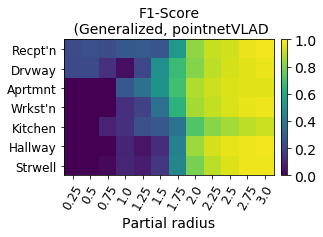

In [492]:
fig=plt.figure(figsize=(4,2.5))

with open(RESULTS_FOLDER + "summary_results.pickle",'rb') as f:
    [pointnetvlad_results, pointnetvlad_per_space_score] = pickle.load(f)

ax1 = fig.add_subplot(1,1,1)

im1 = ax1.imshow(
    pointnetvlad_per_space_score[:,0].T,
    vmin=0, vmax=1.0, aspect='auto',
    cmap = plt.cm.viridis
)

# Create divider for existing axes instance
divider1 = make_axes_locatable(ax1)
# Append axes to the right of ax3, with 20% width of ax3
cax1 = divider1.append_axes("right", size="3%", pad=0.1)

# Create colorbar in the appended axes
# Tick locations can be set with the kwarg `ticks`
# and the format of the ticklabels with kwarg `format`
cbar1 = plt.colorbar(im1, cax=cax1, ticks=np.arange(0,1.6,0.2), format="%.2f")
#cbar1.ax.set_ylabel("F1-score", fontsize = 14)
cbar1.ax.set_yticklabels(np.arange(0,1.6,0.2, dtype = np.float32),fontsize = 14)

#cbar = plt.colorbar(ticks = np.arange(0,1.1,0.2))
#cbar.ax.set_ylabel("F1-score", fontsize = 14)
#cbar.ax.set_yticklabels(np.arange(0,1.1,0.2, dtype = np.float32),fontsize = 14)

ax1.set_title('F1-Score\n (Generalized, pointnetVLAD', fontsize = 14)
ax1.set_xticks(np.arange(len(results_pickle)))
ax1.set_xticklabels(np.arange(0.25, 3.1, 0.25),rotation = 60,fontsize = 12)
ax1.set_xlabel('Partial radius', fontsize = 14)
ax1.set_yticks(np.arange(0,7,1))
#plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)
ax1.set_yticklabels(contiguous_names_short,fontsize = 12)
#plt.yticklabels(

#plt.xlabel('Partial radius', fontsize = 14)
#plt.xticks(np.arange(0,6),np.arange(0.25, 1.6, 0.25),fontsize = 14)
plt.show()


In [ ]:
# Using F1 scores

fig=plt.figure(figsize=(7.5, 7))

with open("testing_results/pointnetvlad_arcore/" + "arcore_summary_results.pickle",'rb') as f:
    arcore_pv_results, arcore_pv_per_space_score, arcore_pv_perf_scores = pickle.load(f)
    
with open("testing_results/pointnetvlad_prod/" + "summary_results.pickle",'rb') as f:
    pointnetvlad_results, pointnetvlad_per_space_score, pointnetvlad_perf_scores = pickle.load(f)
    
with open("testing_results/partial/" + "summary_results.pickle",'rb') as f:
    nn_results_partials, nn_per_space_score, nn_perf_scores = pickle.load(f)

RawNN = np.asarray(results_partials[0])
RansacNN = np.asarray(results_partials[1])
linewidth = 2.0
markersize = 2.0

ax2 = fig.add_subplot(212)#, sharex = ax1) 

ax2.grid(alpha = 0.7)
ax2.set_ylim(-0.25,10.25)
ax2.set_xlim(0,3)

ax2.set_ylabel("INTRA-space Privacy (m)", fontsize = 14);
ax2.set_xlabel("Partial Radius (m)", fontsize = 14);
#ax2.set_yticklabels(fontsize = 16)
#ax2.set_xticklabels(fontsize = 16)

#plt.minorticks_on()

ax2.plot(
    RawNN[:,0],
    RawNN[:,2], 
    linewidth = linewidth, 
    marker = 'o',fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "$\Pi_2$, Raw"
)
ax2.plot(
    RansacNN[:,0],
    RansacNN[:,2],
    '-.s',
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "$\Pi_2$, Generalized"
)

ax2.legend(loc = "upper right", ncol = 1, fontsize = 10);#, bbox_to_anchor=(1.1, 1.5));

ax1 = fig.add_subplot(211, sharex = ax2) 

ax1.grid(alpha = 0.7)
ax1.set_ylim(-0.025,1.025)
ax1.set_xlim(0,3.0)
ax1.set_ylabel("INTER-space Privacy", fontsize = 14);
#ax1.set_xlabel("Partial Radius", fontsize = 14);

markersize = 7
linewidth = 1.5

p1 = ax1.plot(
    RawNN[:,0],RawNN[:,1],
    ":o",
    linewidth = linewidth,fillstyle = 'left',
    mew = linewidth,markersize = markersize,
    label = "$\Pi_1$, Raw"
)
p2 = ax1.plot(
    RansacNN[:,0],
    RansacNN[:,1],
    "-s",
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "$\Pi_1$, Generalized"
)

ax1.legend(loc = "upper right", ncol = 1, fontsize = 10);# bbox_to_anchor=(1.1, 1.5));

plt.title("NN-matcher")

#plt.savefig('plots/one-time-partials-spaces.png', format='png', dpi=300,bbox_inches = 'tight')


Text(0.5, 1.0, 'NN-matcher')

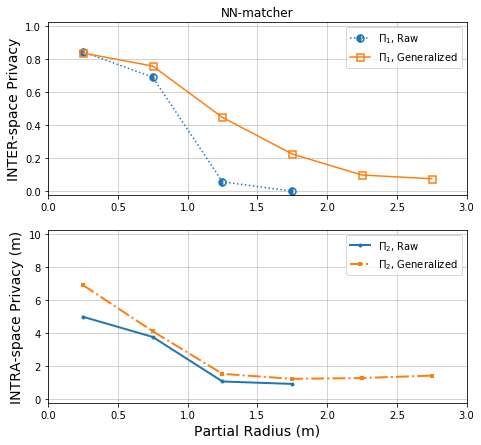

In [96]:
# Using privacy
fig=plt.figure(figsize=(7.5, 7))

with open('testing_results/partial/results_partials_nn_matcher.pickle', 'rb') as f:
    results_partials, _, _ = pickle.load(f)

RawNN = np.asarray(results_partials[0])
RansacNN = np.asarray(results_partials[1])
linewidth = 2.0
markersize = 2.0

ax2 = fig.add_subplot(212)#, sharex = ax1) 

ax2.grid(alpha = 0.7)
ax2.set_ylim(-0.25,10.25)
ax2.set_xlim(0,3)

ax2.set_ylabel("INTRA-space Privacy (m)", fontsize = 14);
ax2.set_xlabel("Partial Radius (m)", fontsize = 14);
#ax2.set_yticklabels(fontsize = 16)
#ax2.set_xticklabels(fontsize = 16)

#plt.minorticks_on()

ax2.plot(
    RawNN[:,0],
    RawNN[:,2], 
    linewidth = linewidth, 
    marker = 'o',fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "$\Pi_2$, Raw"
)
ax2.plot(
    RansacNN[:,0],
    RansacNN[:,2],
    '-.s',
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "$\Pi_2$, Generalized"
)

ax2.legend(loc = "upper right", ncol = 1, fontsize = 10);#, bbox_to_anchor=(1.1, 1.5));

ax1 = fig.add_subplot(211, sharex = ax2) 

ax1.grid(alpha = 0.7)
ax1.set_ylim(-0.025,1.025)
ax1.set_xlim(0,3.0)
ax1.set_ylabel("INTER-space Privacy", fontsize = 14);
#ax1.set_xlabel("Partial Radius", fontsize = 14);

markersize = 7
linewidth = 1.5

p1 = ax1.plot(
    RawNN[:,0],RawNN[:,1],
    ":o",
    linewidth = linewidth,fillstyle = 'left',
    mew = linewidth,markersize = markersize,
    label = "$\Pi_1$, Raw"
)
p2 = ax1.plot(
    RansacNN[:,0],
    RansacNN[:,1],
    "-s",
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "$\Pi_1$, Generalized"
)

ax1.legend(loc = "upper right", ncol = 1, fontsize = 10);# bbox_to_anchor=(1.1, 1.5));

plt.title("NN-matcher")

#plt.savefig('plots/one-time-partials-spaces.png', format='png', dpi=300,bbox_inches = 'tight')


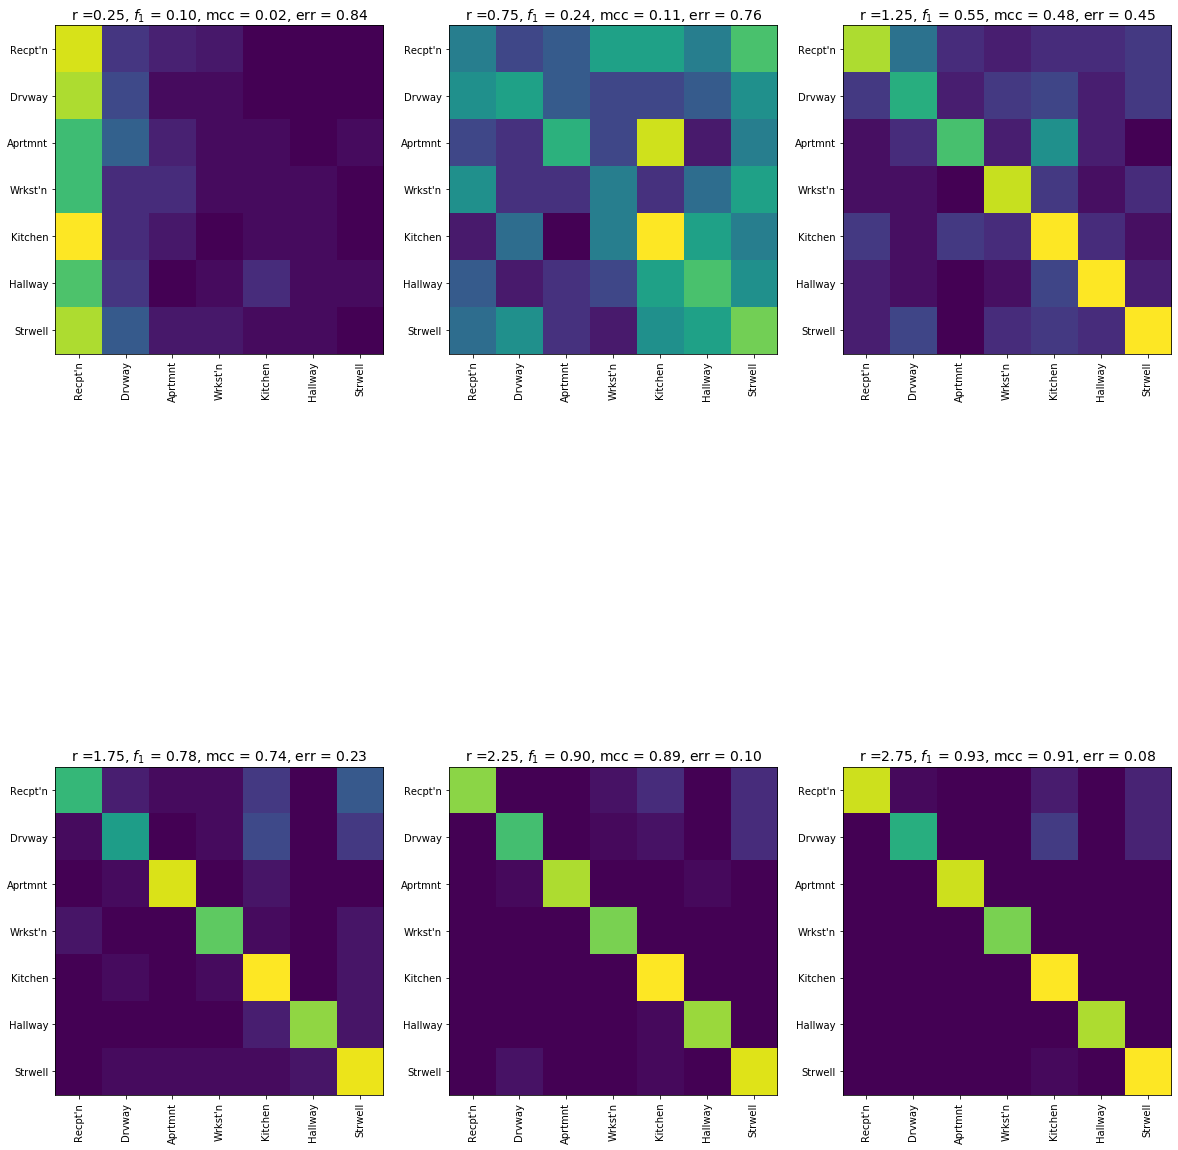

In [70]:
fig=plt.figure(figsize=(20, 25))

plot_count = 1

per_space_score = []
perf_scores = []

#desired_r = [0.5, 1.0, 3.0]

for radius, partial_errors in ransac_errors:

    score_map = np.zeros((7,7))

    for score in partial_errors:
        score_map[int(score[0]),int(score[3])]+=1
        
    macro_score = f1_score(partial_errors[:,0],partial_errors[:,3],average='macro')
    micro_score = f1_score(partial_errors[:,0],partial_errors[:,3],average='micro')
    mcc = matthews_corrcoef(partial_errors[:,0],partial_errors[:,3])
    ave_prec_score = precision_score(partial_errors[:,0],partial_errors[:,3],average='macro')
    prec_score = precision_score(partial_errors[:,0],partial_errors[:,3],average=None)
    ave_recl_score = recall_score(partial_errors[:,0],partial_errors[:,3],average='macro')
    recl_score = recall_score(partial_errors[:,0],partial_errors[:,3],average=None)
    
    per_space_score.append([
        f1_score(partial_errors[:,0],partial_errors[:,3],average=None),
        prec_score,
        recl_score
    ])
    
    perf_scores.append([
        radius,
        macro_score,
        micro_score,
        mcc,
        (np.sum(score_map) - np.trace(score_map))/np.sum(score_map)
    ])
    
    ax = fig.add_subplot(2,3,plot_count)
    #print(radius,plot_count)
    title = "r ={:.2f}, $f_1$ = {:.2f}, mcc = {:.2f}, err = {:.2f}".format(
        radius,macro_score,mcc,
        (np.sum(score_map) - np.trace(score_map))/np.sum(score_map)
    )
    ax.set_title(title, fontsize = 14)
    im = ax.imshow(score_map)#, aspect = 30)
    
    ax.set_yticks(np.arange(0,7,1))
    ax.set_yticklabels(contiguous_names_short,fontsize = 10)
    ax.set_xticks(np.arange(0,7,1))
    ax.set_xticklabels(contiguous_names_short,fontsize = 10, rotation = 90)
    
    plot_count +=1
    
per_space_score = np.asarray(per_space_score)
perf_scores = np.asarray(perf_scores)

#plt.savefig('plots/partials-Raw-heatmaps.pdf', format='pdf', dpi=300,bbox_inches = 'tight')

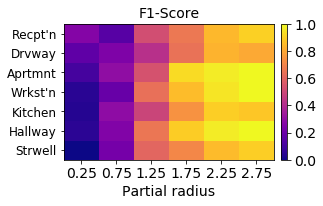

In [88]:
fig=plt.figure(figsize=(4,2.5))

ax1 = fig.add_subplot(1,1,1)

im1 = ax1.imshow(
    per_space_score[:,0].T,
    vmin=0, vmax=1.0, aspect='auto',
    cmap = plt.cm.plasma
)

# Create divider for existing axes instance
divider1 = make_axes_locatable(ax1)
# Append axes to the right of ax3, with 20% width of ax3
cax1 = divider1.append_axes("right", size="3%", pad=0.1)

# Create colorbar in the appended axes
# Tick locations can be set with the kwarg `ticks`
# and the format of the ticklabels with kwarg `format`
cbar1 = plt.colorbar(im1, cax=cax1, ticks=np.arange(0,1.6,0.2), format="%.2f")
#cbar1.ax.set_ylabel("F1-score", fontsize = 14)
cbar1.ax.set_yticklabels(np.arange(0,1.6,0.2, dtype = np.float32),fontsize = 14)

#cbar = plt.colorbar(ticks = np.arange(0,1.1,0.2))
#cbar.ax.set_ylabel("F1-score", fontsize = 14)
#cbar.ax.set_yticklabels(np.arange(0,1.1,0.2, dtype = np.float32),fontsize = 14)

ax1.set_title('F1-Score', fontsize = 14)
ax1.set_xticks(np.arange(0,6))
ax1.set_xticklabels(np.arange(0.25, 3.0, 0.5),fontsize = 14)
ax1.set_xlabel('Partial radius', fontsize = 14)
ax1.set_yticks(np.arange(0,7,1))
#plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)
ax1.set_yticklabels(contiguous_names_short,fontsize = 12)
#plt.yticklabels(

#plt.xlabel('Partial radius', fontsize = 14)
#plt.xticks(np.arange(0,6),np.arange(0.25, 1.6, 0.25),fontsize = 14)
plt.show()


([<matplotlib.axis.YTick at 0x7fb0f4022a50>,
 <a list of 7 Text yticklabel objects>)

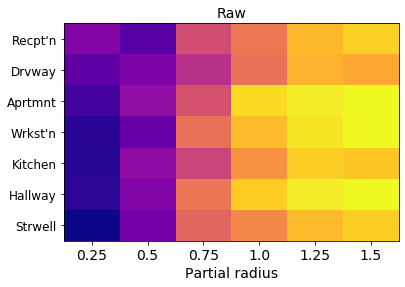

In [76]:
cax0 = divider1.append_axes("left", size="100%", pad=0.1)
p0 = plt.imshow(
    per_space_score[:,0].T,
    vmin=0, vmax=1.0, aspect='auto',
    cmap = plt.cm.plasma
)
plt.title('Raw', fontsize = 14)
plt.xlabel('Partial radius', fontsize = 14)
plt.xticks(np.arange(0,6),np.arange(0.25, 1.6, 0.25),fontsize = 14)
plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)

#plt.savefig('plots/partials-F1-score.pdf', format='pdf', dpi=300,bbox_inches = 'tight')

# Example spaces for presentation

4 (3424, 6) (5678, 3)


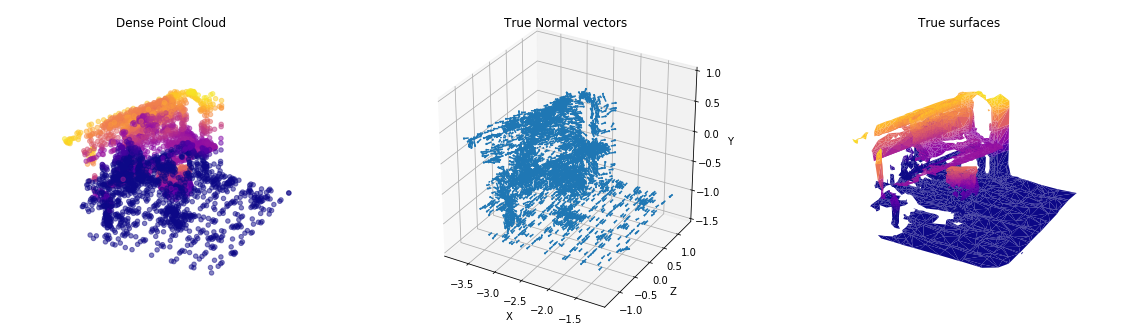

In [88]:
# pointCollection --> object_number, vertices, vertex normals, polygonswith open('many_ransac_generalizedPointCollection.pickle','rb') as f:

with open('../../mr-3d/centeredPointCollection.pickle','rb') as f:
    centeredPointCollection = pickle.load(f)
    
space = 3
sample = 9

fig=plt.figure(figsize=(20, 20)) ##fig=plt.figure(figsize=(80, 80))

descriptor_resolution = 10

ax0 = fig.add_subplot(3,3,1, projection='3d')
ax0.set_xlabel('X')
ax0.set_ylabel('Z')
ax0.set_zlabel('Y')
ax0.set_zlim(-1.5,1)
ax0.set_title('Dense Point Cloud')

ax1 = fig.add_subplot(3,3,3, projection='3d')
ax1.set_xlabel('X')
ax1.set_ylabel('Z')
ax1.set_zlabel('Y')
ax1.set_zlim(-1.5,1)
ax1.set_title('True surfaces')

ax4 = fig.add_subplot(3,3,2, projection='3d')
ax4.set_xlabel('X')
ax4.set_ylabel('Z')
ax4.set_zlabel('Y')
ax4.set_zlim(-1.5,1)
ax4.set_title('True Normal vectors')

object_name =  centeredPointCollection[space][0]
pointCloud = np.asarray(centeredPointCollection[space][1])
triangles = np.asarray(centeredPointCollection[space][2])

#pointCloud = np.concatenate((pointCloud,normals),axis = 1)

print(object_name,pointCloud.shape, triangles.shape)

t0 = time.time()

X = pointCloud[:,0]
Y = pointCloud[:,1]
Z = pointCloud[:,2]

ax0.set_xlim(min(X), max(X))
ax0.set_ylim(min(-Z), max(-Z))
ax1.set_xlim(min(X), max(X))
ax1.set_ylim(min(-Z), max(-Z))

try:
    imT = ax0.scatter(
        X,-Z,Y,
        c = Y,
        cmap = mpl.cm.plasma,
        vmin = -0.7, vmax = 0.35,
        alpha = 0.5
    )#,c=t_l_s_[:,-1])
    #imT.set_clim(0.0, 1.0)
    #cbarT = fig.colorbar(imT, ax=ax0)
    #cbarT.ax.set_ylabel('Local self-similarity ({} neighbors)'.format(len(t_k_[0])))

    ax1.plot_trisurf(
        X, -Z, Y, 
        triangles=triangles, 
        cmap=plt.cm.plasma,
        vmin = -0.7, vmax = 0.35
    )

    ax4.quiver(X, -Z, Y,
               pointCloud[:,3], -pointCloud[:,4], pointCloud[:,5],length=0.1)#, cmap=plt.cm.Spectral)

except Exception as ex:
    print(ex)
    pass

ax0.set_axis_off()
ax1.set_axis_off()


4 (2296, 6) (4349, 3)
vertical at 0.06
horizontal at 0.94 [-0.34 -0.94  0.01]
horizontal at 0.99 [-0.12  0.99  0.1 ]
horizontal at 1.0 [-0.03  1.   -0.01]
horizontal at 1.0 [ 0.   -1.   -0.04]
horizontal at 1.0 [ 0.03  1.   -0.03]
horizontal at 1.0 [ 0.03  1.   -0.01]
vertical at 0.15
horizontal at 0.97 [0.09 0.97 0.24]
horizontal at 1.0 [ 0.09  1.   -0.  ]
horizontal at 0.95 [0.27 0.95 0.13]
horizontal at 0.91 [ 0.39 -0.91 -0.13]
horizontal at 0.84 [ 0.51 -0.84  0.18]
vertical at 0.16
vertical at 0.05
vertical at 0.19
vertical at 0.02
vertical at 0.01


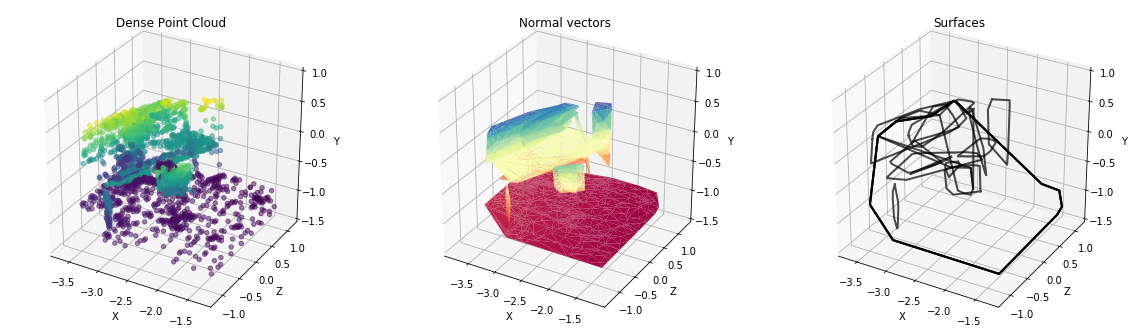

In [62]:
# Generalized

# pointCollection --> object_number, vertices, vertex normals, polygons
from scipy.spatial import ConvexHull, convex_hull_plot_2d

with open('../../mr-3d/many_ransac_generalizedPointCollection.pickle','rb') as f:
    many_ransac_generalizedPointCollection = pickle.load(f)
    
space = 3
sample = 5

fig=plt.figure(figsize=(20, 20)) ##fig=plt.figure(figsize=(80, 80))

descriptor_resolution = 10

ax0 = fig.add_subplot(3,3,1, projection='3d')
ax0.set_xlabel('X')
ax0.set_ylabel('Z')
ax0.set_zlabel('Y')
ax0.set_zlim(-1.5,1)
ax0.set_title('Dense Point Cloud')

ax1 = fig.add_subplot(3,3,3, projection='3d')
ax1.set_xlabel('X')
ax1.set_ylabel('Z')
ax1.set_zlabel('Y')
ax1.set_zlim(-1.5,1)
ax1.set_title('Surfaces')

ax4 = fig.add_subplot(3,3,2, projection='3d')
ax4.set_xlabel('X')
ax4.set_ylabel('Z')
ax4.set_zlabel('Y')
ax4.set_zlim(-1.5,1)
ax4.set_title('Normal vectors')

object_name =  many_ransac_generalizedPointCollection[space][0]
pointCloud = np.asarray(many_ransac_generalizedPointCollection[space][1][sample][0])
triangles = np.asarray(many_ransac_generalizedPointCollection[space][1][sample][1])

#pointCloud = np.concatenate((pointCloud,normals),axis = 1)

print(object_name,pointCloud.shape, triangles.shape)

t0 = time.time()

#pointCloud = getQuantizedPointCloudOnlyTEST(pointCloud, scale=100)

#print(pointCloud.shape)

X = pointCloud[:,0]
Y = pointCloud[:,1]
Z = pointCloud[:,2]

ax0.set_xlim(min(X), max(X))
ax0.set_ylim(min(-Z), max(-Z))
ax1.set_xlim(min(X), max(X))
ax1.set_ylim(min(-Z), max(-Z))

unique_normals = np.unique(np.around(pointCloud[:,3:],decimals = 2),axis = 0)

for normal in unique_normals:
    
    p_pointCloud = pointCloud[np.where(np.around(pointCloud[:,3:],decimals = 2) == normal)[0]]

    orientation  = np.abs(np.dot(normal,[0,1,0]))
    if orientation > 0.5 :
        print("horizontal at",orientation,normal)
        hull = ConvexHull(p_pointCloud[:,0:3:2])
    else:
        print("vertical at",orientation)
        hull = ConvexHull(p_pointCloud[:,0:2:1])
    
    #p_pointCloud = pointCloud[np.where(np.around(pointCloud[:,3:],decimals = 2) == normal)[0]]
    h_pointCloud = p_pointCloud[hull.vertices]

    PX = np.concatenate((h_pointCloud, [h_pointCloud[0]]), axis = 0)[:,0]
    PY = np.concatenate((h_pointCloud, [h_pointCloud[0]]), axis = 0)[:,1]
    PZ = np.concatenate((h_pointCloud, [h_pointCloud[0]]), axis = 0)[:,2]

    #ax0.plot3D(PX,-PZ,PY,'k-',alpha = 0.7)
    ax1.plot3D(
        PX,-PZ,PY,
        'k-', linewidth = 2,
        alpha = 0.7)

try:
    imT = ax0.scatter(
        X,-Z,Y,
        c = Y,
        cmap = mpl.cm.viridis,
        alpha = 0.5
    )#,c=t_l_s_[:,-1])
    
    ax4.plot_trisurf(X, -Z, Y, triangles=triangles, cmap=plt.cm.Spectral)

    #imT.set_clim(0.0, 1.0)
    #cbarT = fig.colorbar(imT, ax=ax0)
    #cbarT.ax.set_ylabel('Local self-similarity ({} neighbors)'.format(len(t_k_[0])))

    #ax1.plot_trisurf(X, -Z, Y, triangles=triangles, cmap=plt.cm.Spectral)

    #ax4.quiver(X, -Z, Y,
    #           pointCloud[:,3], -pointCloud[:,4], pointCloud[:,5],length=0.1)#, cmap=plt.cm.Spectral)

except Exception as ex:
    print(ex)
    pass

4 (2189, 6) (4349, 3) 6
Plane area 5.832; point density 132.554.
horizontal at 0.9995100371773098 []
Plane area 2.188; point density 174.609.
horizontal at 0.999660486258831 []
Plane area 0.662; point density 362.400.
horizontal at 0.9963730470230381 []
Plane area 0.314; point density 264.104.
vertical at 0.14983159313150674 []
Plane area 0.858; point density 34.962.
Plane area 0.352; point density 73.877.



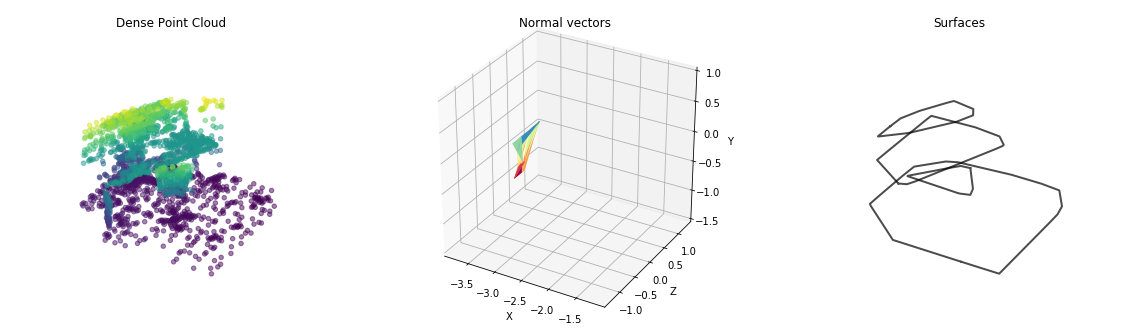

In [72]:
# Generalized

# pointCollection --> object_number, vertices, vertex normals, polygons
from scipy.spatial import ConvexHull, convex_hull_plot_2d

with open('../../mr-3d/many_ransac_generalizedPointCollection.pickle','rb') as f:
    many_ransac_generalizedPointCollection = pickle.load(f)
    
space = 3
sample = 5

fig=plt.figure(figsize=(20, 20)) ##fig=plt.figure(figsize=(80, 80))

descriptor_resolution = 10

ax0 = fig.add_subplot(3,3,1, projection='3d')
ax0.set_xlabel('X')
ax0.set_ylabel('Z')
ax0.set_zlabel('Y')
ax0.set_zlim(-1.5,1)
ax0.set_title('Dense Point Cloud')

ax1 = fig.add_subplot(3,3,3, projection='3d')
ax1.set_xlabel('X')
ax1.set_ylabel('Z')
ax1.set_zlabel('Y')
ax1.set_zlim(-1.5,1)
ax1.set_title('Surfaces')

ax4 = fig.add_subplot(3,3,2, projection='3d')
ax4.set_xlabel('X')
ax4.set_ylabel('Z')
ax4.set_zlabel('Y')
ax4.set_zlim(-1.5,1)
ax4.set_title('Normal vectors')

object_name =  many_ransac_generalizedPointCollection[space][0]
pointCloud = np.asarray(many_ransac_generalizedPointCollection[space][1][sample][0])
triangles = np.asarray(many_ransac_generalizedPointCollection[space][1][sample][1])

#pointCloud = np.concatenate((pointCloud,normals),axis = 1)

t0 = time.time()

pointCloud = getQuantizedPointCloudOnlyTEST(pointCloud, scale=100)
generalized_planes = getRansacPlanes2(pointCloud)

#print(pointCloud.shape)

X = pointCloud[:,0]
Y = pointCloud[:,1]
Z = pointCloud[:,2]

ax0.set_xlim(min(X), max(X))
ax0.set_ylim(min(-Z), max(-Z))
ax1.set_xlim(min(X), max(X))
ax1.set_ylim(min(-Z), max(-Z))

print(object_name,pointCloud.shape, triangles.shape, len(generalized_planes))

for plane_params, points, refpoint in generalized_planes:
    
    bestPlane = plane_params[0]
    phi = plane_params[1]
    density = plane_params[2]
    
    #triangles = plane_[2]
    triangles = getDelaunayTriangles(
        bestPlane, 
        points,
        #triangle_area_threshold = triangle_area_threshold,
        #phi = phi,
        #strict = strict,
        #verbose = verbose
    )

    if len(triangles) == 0:
        if verbose: print("No triangles at",bestPlane,len(planes),points.shape)
        continue

    PX = points[:,0]
    PY = points[:,1]
    PZ = points[:,2]

    #if strict:
    # Get area and point desity of the planes
    v1 = points[triangles[:,0],:3] - points[triangles[:,1],:3]
    v2 = points[triangles[:,2],:3] - points[triangles[:,1],:3]
    area = np.abs(LA.norm(np.cross(v1,v2), axis = 1))*0.5
    point_density = len(points)/np.nansum(area)

    #if verbose: 
    print("Plane area {:.3f}; point density {:.3f}.".format(np.nansum(area),point_density))

    if point_density < 100: #0.75*density:
        continue

    if phi > 0.5 :
        print("horizontal at",phi,bestPlane[3:])
        hull = ConvexHull(points[:,0:3:2])
    else:
        print("vertical at",phi,bestPlane[3:])
        hull = ConvexHull(points[:,0:2:1])
    
    #p_pointCloud = pointCloud[np.where(np.around(pointCloud[:,3:],decimals = 2) == normal)[0]]
    h_pointCloud = points[hull.vertices]

    PX = np.concatenate((h_pointCloud, [h_pointCloud[0]]), axis = 0)[:,0]
    PY = np.concatenate((h_pointCloud, [h_pointCloud[0]]), axis = 0)[:,1]
    PZ = np.concatenate((h_pointCloud, [h_pointCloud[0]]), axis = 0)[:,2]

    #ax0.plot3D(PX,-PZ,PY,'k-',alpha = 0.7)
    ax1.plot3D(
        PX,-PZ,PY,
        'k-', linewidth = 2,
        alpha = 0.7)

print()
try:
    imT = ax0.scatter(
        X,-Z,Y,
        c = Y,
        cmap = mpl.cm.viridis,
        alpha = 0.5
    )#,c=t_l_s_[:,-1])
    
    ax4.plot_trisurf(X, -Z, Y, triangles=triangles, cmap=plt.cm.Spectral)

    #imT.set_clim(0.0, 1.0)
    #cbarT = fig.colorbar(imT, ax=ax0)
    #cbarT.ax.set_ylabel('Local self-similarity ({} neighbors)'.format(len(t_k_[0])))

    #ax1.plot_trisurf(X, -Z, Y, triangles=triangles, cmap=plt.cm.Spectral)

    #ax4.quiver(X, -Z, Y,
    #           pointCloud[:,3], -pointCloud[:,4], pointCloud[:,5],length=0.1)#, cmap=plt.cm.Spectral)

except Exception as ex:
    print(ex)
    pass

ax0.set_axis_off()
ax1.set_axis_off()


In [66]:
def getRansacPlanes2(
    pointCloud,
    #triangles,
    planes_to_find = 30, # number of planes to find
    threshold = 0.05,     # the point-plane distance threshold
    trials = 100,       # the number of RANSAC trials
    #strict = False
    #plane_group = 200     # number of nearby points per plane
    verbose = False
):

    density = 0
    
    """
    if strict:
        v1 = pointCloud[triangles[:,0],:3] - pointCloud[triangles[:,1],:3]
        v2 = pointCloud[triangles[:,2],:3] - pointCloud[triangles[:,1],:3]
        area = np.abs(LA.norm(np.cross(v1,v2), axis = 1))*0.5
        density = len(pointCloud)/np.nansum(area)
    """
        
    planeCollection = []
    test_max = 10

    t0 = time.time()

    planes = []
    #plane_properties = []

    depletable_pc = np.copy(pointCloud)
    #print("true points",len(depletable_pc))

    zero_normals = 0
    added_zero_normals = 0
    
    # Getting the planes
    for i_plane in np.arange(planes_to_find):
        
        bestPoints = []
        trial = 0
        t1 = time.time()

        if len(depletable_pc) < 3:
            continue
            
        for i_trials in np.arange(trials):

            sample = np.random.randint(len(depletable_pc))

            testPlane = [depletable_pc[sample,:3],depletable_pc[sample,3:]]

            testPoints = []
            
            d = -testPlane[0].dot(testPlane[1])
            """
            for i, point in enumerate(depletable_pc): #[neighbours[sample]]
                if LA.norm(testPlane[1])*LA.norm(point[3:]) == 0:
                    zero_normals += 1
                    if abs((np.dot(testPlane[1],point[:3])+d)*1.0/LA.norm(testPlane[1],ord = 2)) < threshold:
                        # only add a point with zero_normal if very close to the plane
                        added_zero_normals += 1
                        testPoints.append(i)
                if abs(np.dot(testPlane[1],point[3:])/(LA.norm(testPlane[1])*LA.norm(point[3:]))) > max(0,(1-20*threshold)):
                    # if normals are close accept if near to the candidate plane
                    if abs((np.dot(testPlane[1],point[:3])+d)*1.0/LA.norm(testPlane[1],ord = 2)) < threshold:
                        testPoints.append(i)            
            """
            normal_mags = LA.norm(testPlane[1])*LA.norm(depletable_pc[:,3:], axis = 1)
            if verbose: print(depletable_pc.shape,normal_mags.shape)
            
            distance_from_plane = np.abs(np.dot(depletable_pc[:,:3]+d,testPlane[1])/LA.norm(testPlane[1],ord = 2))
            
            normal_inner_prod = np.dot(depletable_pc[:,3:],testPlane[1])/normal_mags
            if verbose: print(depletable_pc.shape,distance_from_plane.shape,normal_inner_prod.shape)
            #()
            # if normals are close accept if near to the candidate plane
            accepted_normals = np.where(normal_inner_prod > max(0,(1-20*threshold)))[0]
            
            accepted_distances = np.where(distance_from_plane < threshold)[0]
            
            testPoints = np.intersect1d(accepted_normals, accepted_distances)

            if len(testPoints) < 20:
                continue
            if len(testPoints) > len(bestPoints):#plane_group:
                trial += 1
                bestPlane = testPlane
                bestPoints = testPoints

        #print(object_name,i_plane,len(depletable_pc),bestPlane,depletable_pc[sample])
        #print("Added a ",bestPlane," in",time.time()-t1,"seconds")
        if trial > 1:
            d = -bestPlane[0].dot(bestPlane[1])

            PX = depletable_pc[bestPoints][:,0]
            PY = depletable_pc[bestPoints][:,1]
            PZ = depletable_pc[bestPoints][:,2]
            
            phi = math.fabs(bestPlane[1][1]* 1./LA.norm(bestPlane[1])) # y/r
            
            if math.degrees(math.acos(phi)) < 45 : # arc-cos(y/r) = phi < 45 --> horizontal
                # use floor (plane x-z) as origin mesh
                NPY = (-bestPlane[1][0] * PX - bestPlane[1][2] * PZ - d) * 1. /bestPlane[1][1]
                #orientation = 'horizontal'
                acceptable_move = np.where(np.abs(PY-NPY)<10*threshold)[0]
                NPY = NPY[acceptable_move]
                NPX = PX[acceptable_move]
                NPZ = PZ[acceptable_move]
            else:
                #use vertical wall x-y as origin mesh
                NPZ = (-bestPlane[1][0] * PX - bestPlane[1][1] * PY - d) * 1. /bestPlane[1][2]
                #orientation = 'vertical'
                acceptable_move = np.where(np.abs(PZ-NPZ)<10*threshold)[0]
                NPZ = NPZ[acceptable_move]
                NPX = PX[acceptable_move]
                NPY = PY[acceptable_move]

            if len(NPX) == 0:
                if verbose: print("Emptied after strict acceptable points",PX.shape,NPX.shape)
                continue
                
            # Add final candidate plane to list of planes
            planes.append([
                [bestPlane ,phi, density],
                #np.concatenate((np.stack((PX,PY,PZ)).T,depletable_pc[bestPoints][:,3:6]),axis=1),
                np.concatenate((np.stack((NPX,NPY,NPZ)).T,np.repeat([bestPlane[1]],len(NPX),axis = 0)),axis=1),
                depletable_pc[sample]
            ])

            # Remove points of final plane from remaining candidate points
            depletable_pc = np.delete(depletable_pc,bestPoints,0)

    #print(len(pointCloud),"points, Time to extract",len(planes),"planes: ", time.time() - t0)
    #print(len(depletable_pc),"remaining points")
    #print(zero_normals,"with zero normals")
    #print(added_zero_normals,"added zero normals")
    #planeCollection.append([object_name, planes])
    #plane_properties = np.asarray(plane_properties)
    return planes

In [67]:
generalized_planes2 = getRansacPlanes2(pointCloud, planes_to_find=5, trials=5)

# ARCore Spatial Properties

In [90]:
with open('../../spatial-privacy/point_collection/2_filled_quaternion_vertical_correction_arcore_point_cloud_collection_complete.pickle','rb') as f: 
    arcore_point_cloud_collection = pickle.load(f)
    
arcore_spaces = [[],[],[],[],[],[],[]]
    
for [obj_num, name, timestamp], t_pointCloud, triangles in arcore_point_cloud_collection:
    
    unique_normals = np.unique(np.around(t_pointCloud[:,3:],decimals = 2),axis = 0)
    
    print(obj_num, name, timestamp, len(unique_normals))
    try:
        arcore_spaces[int(obj_num)].append([
            [obj_num, name, timestamp],
            t_pointCloud, 
            triangles,
            len(unique_normals)
        ])
    except:
        continue
        
len(arcore_spaces)

2 apartment 2020.02.17.09.37.02 7
2 apartment 2020.02.17.09.38.32 6
2 apartment 2020.02.17.09.40.48 8
2 apartment 2020.02.17.09.43.11 5
2 apartment 2020.02.17.09.45.56 5
1 driveway 2020.02.17.09.47.33 2
1 driveway 2020.02.17.09.48.24 2
1 driveway 2020.02.17.09.49.29 3
1 driveway 2020.02.17.09.50.47 5
1 driveway 2020.02.17.09.52.08 8
5 hallway 2020.01.14.12.03.42 3
5 hallway 2020.01.14.12.04.42 1
5 hallway 2020.01.14.12.05.49 3
5 hallway 2020.01.14.12.07.30 2
5 hallway 2020.01.14.12.08.32 1
4 kitchen 2020.01.14.13.58.34 3
4 kitchen 2020.01.14.14.00.46 3
4 kitchen 2020.01.14.14.02.30 4
4 kitchen 2020.01.14.14.04.46 3
4 kitchen 2020.01.14.14.06.43 2
0 reception 2020.01.14.12.10.53 3
0 reception 2020.01.14.12.12.31 4
0 reception 2020.01.14.12.13.59 4
0 reception 2020.01.14.12.15.35 5
0 reception 2020.01.14.12.17.08 5
6 stairwell 2020.01.14.14.11.52 2
6 stairwell 2020.01.14.14.14.01 2
6 stairwell 2020.01.14.14.16.16 2
6 stairwell 2020.01.14.14.18.25 2
6 stairwell 2020.01.14.14.20.59 2
3 wor

7

In [40]:

"""
For the computation of normal vector similarity:
1. For every keypoint, we get the K nearest neighboring points of and 
2. compute the average cosine similarity of their normals with that of the keypoint.
3. We vary the neighbor size K to see how the normal similarity varies accordingly.
"""

arcore_norm_cdf_values = []

neighbor_sizes = 50*2**np.arange(0,6)

for space in arcore_spaces:
    
    per_space_values = []
    
    print(len(space))
    
    per_sample_most_planes = 0
    max_num_normals = 0

    for i_s, [[obj_num, obj_name, timestamp] , t_pointCloud, triangles, num_normals] in enumerate(space):
        
        per_sample_space_values = []

        pointCloud = getQuantizedPointCloudOnlyTEST(t_pointCloud,scale = 100)
        print("{}: from {} to {}.".format(obj_name+timestamp, t_pointCloud.shape, pointCloud.shape))

        if num_normals > max_num_normals: 
            max_num_normals = num_normals
            per_sample_most_planes = i_s

        for i, neighbor_size in enumerate(neighbor_sizes):

            t0 = time.time()

            nbrs = NearestNeighbors(n_neighbors=neighbor_size, algorithm='kd_tree').fit(pointCloud[:,:3])
            distances, indices = nbrs.kneighbors(pointCloud[:,:3])

            print("  Max dist of {} = {:.3f} m (± {:.3f} m)".format(
                neighbor_size,
                np.mean(np.amax(distances,axis =1)),
                np.std(np.amax(distances,axis =1))
            ))

            try:
                nearby_normals = pointCloud[indices,3:6]
                refrnc_normals = np.reshape(np.repeat(pointCloud[:,3:6],neighbor_size,axis=0),nearby_normals.shape)

                normal_product = np.sum(np.multiply(refrnc_normals,nearby_normals),axis=2)

                #print(nearby_normals.shape, refrnc_normals.shape, normal_product.shape)
            except Exception as e1:
                print("Error while getting normals,", e1)

            color = np.mean(np.abs(normal_product))
            hist, values = np.histogram(np.mean(np.abs(normal_product),axis = 1), bins = np.arange(0,1.01,0.01))
            CY = np.cumsum(hist/np.sum(hist))

            per_sample_space_values.append([
                hist,
                CY,
                values,
                np.trapz(CY, values[1:]),
                neighbor_size
            ])

        print("Done with {} in {:.3f} seconds".format(obj_name,time.time()-t0))
        
        per_space_values.append(per_sample_space_values)

    arcore_norm_cdf_values.append([
        [obj_num, obj_name],
        per_space_values,
        per_sample_most_planes
    ])

    with open("properties/arcore_cdf_values_sampled.pickle",'wb') as f:
        pickle.dump(arcore_norm_cdf_values,f)
    

5
reception2020.01.14.12.10.53: from (19768, 6) to (14056, 6).
  Max dist of 50 = 0.305 m (± 0.094 m)
  Max dist of 100 = 0.436 m (± 0.127 m)
  Max dist of 200 = 0.623 m (± 0.171 m)
  Max dist of 400 = 0.896 m (± 0.236 m)
  Max dist of 800 = 1.288 m (± 0.305 m)
  Max dist of 1600 = 1.874 m (± 0.398 m)
Done with reception in 5.656 seconds
reception2020.01.14.12.12.31: from (15860, 6) to (12211, 6).
  Max dist of 50 = 0.302 m (± 0.094 m)
  Max dist of 100 = 0.432 m (± 0.130 m)
  Max dist of 200 = 0.613 m (± 0.167 m)
  Max dist of 400 = 0.874 m (± 0.210 m)
  Max dist of 800 = 1.276 m (± 0.279 m)
  Max dist of 1600 = 1.907 m (± 0.401 m)
Done with reception in 4.834 seconds
reception2020.01.14.12.13.59: from (18088, 6) to (12513, 6).
  Max dist of 50 = 0.312 m (± 0.079 m)
  Max dist of 100 = 0.446 m (± 0.107 m)
  Max dist of 200 = 0.639 m (± 0.144 m)
  Max dist of 400 = 0.920 m (± 0.193 m)
  Max dist of 800 = 1.341 m (± 0.264 m)
  Max dist of 1600 = 2.011 m (± 0.370 m)
Done with reception i

  Max dist of 100 = 0.458 m (± 0.143 m)
  Max dist of 200 = 0.656 m (± 0.193 m)
  Max dist of 400 = 0.943 m (± 0.268 m)
  Max dist of 800 = 1.372 m (± 0.385 m)
  Max dist of 1600 = 1.996 m (± 0.542 m)
Done with kitchen in 7.622 seconds
kitchen2020.01.14.14.06.43: from (30756, 6) to (15603, 6).
  Max dist of 50 = 0.386 m (± 0.088 m)
  Max dist of 100 = 0.559 m (± 0.148 m)
  Max dist of 200 = 0.806 m (± 0.192 m)
  Max dist of 400 = 1.164 m (± 0.266 m)
  Max dist of 800 = 1.685 m (± 0.373 m)
  Max dist of 1600 = 2.468 m (± 0.512 m)
Done with kitchen in 6.223 seconds
5
hallway2020.01.14.12.03.42: from (7999, 6) to (4363, 6).
  Max dist of 50 = 0.381 m (± 0.196 m)
  Max dist of 100 = 0.547 m (± 0.212 m)
  Max dist of 200 = 0.800 m (± 0.242 m)
  Max dist of 400 = 1.208 m (± 0.311 m)
  Max dist of 800 = 1.958 m (± 0.580 m)
  Max dist of 1600 = 3.446 m (± 1.559 m)
Done with hallway in 1.577 seconds
hallway2020.01.14.12.04.42: from (10928, 6) to (8080, 6).
  Max dist of 50 = 0.283 m (± 0.081 m)

reception 3
driveway 4
apartment 2
workstation 4
kitchen 2
hallway 0
stairwell 0


/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in long_scalars
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in long_scalars


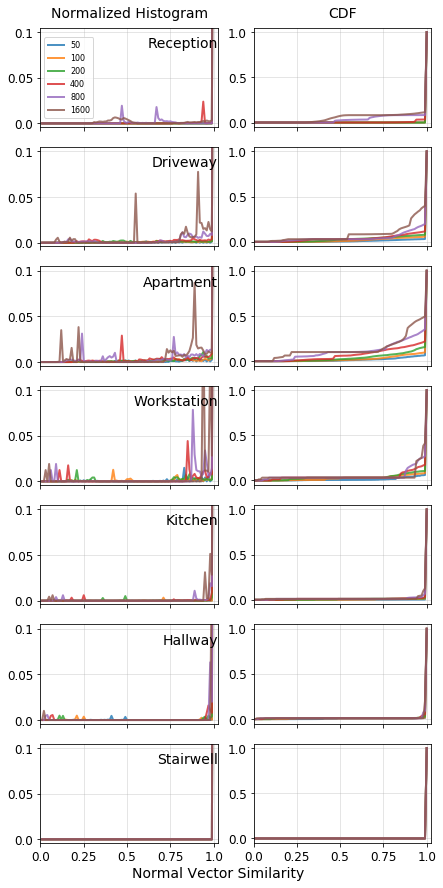

In [272]:
"""
Plotting the (estimate) PDF, i.e. normalized histogram, and CDF
"""

with open("properties/arcore_cdf_values_sampled.pickle",'rb') as f:
    norm_cdf_values = pickle.load(f)

fig=plt.figure(figsize=(7, 15)) ##fig=plt.figure(figsize=(80, 80))

linewidth = 5

figures_list = []

for n in np.arange(7):    
    figures_list.append([
        fig.add_subplot(7,2,n*2+1), # normalized histogram (estimate PDF)
        fig.add_subplot(7,2,n*2+2) # estimate CDF
    ])
    
arcore_sim_dist_values = [] # auc and sim dist ratio

for i, [[obj_num, obj_name], per_space_samples, ind_at_max] in enumerate(norm_cdf_values):
    
    print(obj_name,ind_at_max)
    per_space_values = per_space_samples[ind_at_max]
    
    ax1, ax2 = figures_list[i]

    per_space_dist_values = []
    
    ax1.text(
        1.0,.8,contiguous_names[i],
        horizontalalignment='right',
        fontsize = 14,
        transform=ax1.transAxes
    )
    
    ax1.set_ylim(-0.004,0.105)
    ax1.set_xlim(0.375,1.025)
    ax2.set_xlim(0.375,1.025)
    
    if i == 0:
        ax1.text(
            0.5,1.1,
            "Normalized Histogram",
            horizontalalignment='center',
            fontsize = 14,
            transform=ax1.transAxes                
        )
        ax2.text(
            0.5,1.1,                
            "CDF",
            horizontalalignment='center',
            fontsize = 14,
            transform=ax2.transAxes
        )

    ax1.set_xticks(np.arange(0,1.1,0.25))
    ax2.set_xticks(np.arange(0,1.1,0.25))
    ax1.set_yticks(np.arange(0.0,0.11,0.05))
    ax2.set_yticks(np.arange(0.0,1.1,0.5))

    if i!= 6:# and i_n != 0: 
        ax1.set_xticklabels([])
        ax2.set_xticklabels([])   
    else:
        ax1.set_xticklabels(np.around(np.arange(0,1.1,0.25), decimals = 2), fontsize = 12)
        ax2.set_xticklabels(np.around(np.arange(0,1.1,0.25), decimals = 2), fontsize = 12)
        ax1.text(
            1.0,-0.35,"Normal Vector Similarity",
            horizontalalignment='center',
            fontsize = 14,
            transform=ax1.transAxes
        )

    ax1.set_yticklabels(np.around(np.arange(0.0,0.11,0.05),decimals = 2), fontsize = 12)
    ax2.set_yticklabels(np.around(np.arange(0.0,1.1,0.5),decimals = 2), fontsize = 12)

    ax1.grid(alpha=0.4)
    ax2.grid(alpha=0.4)
    
    for hist, cum_y, values, auc, radius in per_space_values:
        
        #color = np.mean(np.abs(normal_product))
        ax1.plot(
            values[1:], 
            hist/np.sum(hist), 
            alpha = 0.8, 
            #color = colors[i_n], #mpl.cm.viridis(color), 
            linewidth = 2,
            label = str(radius)
        )
            
        ax2.plot(
            values[1:], 
            cum_y, 
            alpha = 0.8, 
            #color = colors[i_n], #mpl.cm.viridis(color), 
            linewidth = 2,
            label = str(radius)
        )
        
        per_space_dist_values.append([
            np.sum(hist[95:])/np.sum(hist[:95]),
            np.sum(hist[50:])/np.sum(hist[:50]),
            np.sum(hist[95:])/np.sum(hist)
        ])
        
    if i == 0:
        ax1.legend(loc = "center left", 
            ncol = 1, fontsize = 8)#bbox_to_anchor=(0.6, 1.03))

    #print("Done with {} in {:.3f} seconds".format(neighbor_size,time.time()-t0))
    
    arcore_sim_dist_values.append(per_space_dist_values)
    
#plt.show()
plt.savefig('properties/arcore-norm-sim-hist-cdf.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/arcore-norm-sim-hist-cdf.png', format='png', dpi=300,bbox_inches = 'tight')


(7, 6, 3)
Ratio at 50 inf 8.921507064364206
High 1.0 0.5465189873417722


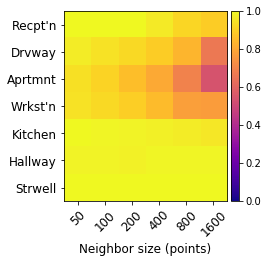

In [273]:
fig=plt.figure(figsize=(4,3.5))

arcore_sim_dist_values = np.asarray(arcore_sim_dist_values)
print(arcore_sim_dist_values.shape)
print("Ratio at 50",np.nanmax(arcore_sim_dist_values[:,:,1]),np.min(arcore_sim_dist_values[:,:,1]))
print("High",np.max(arcore_sim_dist_values[:,:,-1]),np.min(arcore_sim_dist_values[:,:,-1]))

#fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
ax1 = fig.add_subplot(111)
#fig.figsize(8,3.5)

im1 = ax1.imshow(
    arcore_sim_dist_values[:,:,-1], 
    cmap=mpl.cm.plasma,
    vmin=0.0, vmax=1.0,#np.around(np.max(raw_sim_dist_values[:,:,1]),decimals = 1)
);
ax1.set_xticks(np.arange(len(neighbor_sizes)))
ax1.set_xticklabels(neighbor_sizes, rotation=45, fontsize = 12)
ax1.set_yticks(np.arange(len(contiguous_names)))
ax1.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);
ax1.set_xlabel("Neighbor size (points)",fontsize = 12)
#ax1.set_title("Ratio of high-over-low\n Normal similarity", fontsize = 14)

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(im1, cax = cax1, format="%.1f")
#cbar1.ax.set_yticklabels(np.arange(0,np.around(np.nanmax(raw_sim_dist_values[:,:,1]),decimals = 1)+0.1,0.1, dtype = np.float32),fontsize = 12);

"""
ax2.set_xticks(np.arange(0,6))
ax2.set_xticklabels(np.arange(0.25, 3.0, 0.5),fontsize = 14)
ax2.set_xlabel('Partial radius', fontsize = 14)
ax2.set_yticks(np.arange(0,7,1))
#plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)
ax2.set_yticklabels(contiguous_names_short,fontsize = 12)
#plt.yticklabels(
"""
#plt.xlabel('Partial radius', fontsize = 14)
#plt.xticks(np.arange(0,6),np.arange(0.25, 1.6, 0.25),fontsize = 14)
#plt.show()
plt.savefig('properties/arcore-high-norm-sim.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/arcore-high-norm-sim.png', format='png', dpi=300,bbox_inches = 'tight')


# Area and other structural properties

In [92]:
# pointCollection --> object_number, vertices, vertex normals, polygons
from scipy.spatial import ConvexHull, convex_hull_plot_2d

def PolyArea2D(pts):
    lines = np.hstack([pts,np.roll(pts,-1,axis=0)])
    area = 0.5*abs(sum(x1*y2-x2*y1 for x1,y1,x2,y2 in lines))
    return area

overall_surface_area = 0
overall_floor_area = 0

for obj_name, pointCloud, triangles in new_contiguous_point_collection:

    obj_area = getPointCloudArea(pointCloud, triangles)
        
    floor_pointcloud = 0.25*100*np.around((0.01/0.25)*pointCloud[:,[0,2]],decimals=2)
    unq_floor_pointcloud = np.unique(floor_pointcloud,axis = 0)
    
    hull = ConvexHull(unq_floor_pointcloud)
    
    floor_area = PolyArea2D(unq_floor_pointcloud[hull.vertices])
    
    overall_surface_area += obj_area
    overall_floor_area += floor_area
    
    print(obj_name,"has surface area of {:.3f} sqm and floor area of {:.3f} sqm".format(obj_area, floor_area))

    
print("\nTotal surface area of {:.3f} sqm".format(overall_surface_area))
print("\nTotal floor area of {:.3f} sqm".format(overall_floor_area))


Reception-Data61-L5.obj has surface area of 114.832 sqm and floor area of 115.750 sqm
Driveway.obj has surface area of 142.982 sqm and floor area of 130.188 sqm
Apartment.obj has surface area of 203.758 sqm and floor area of 59.406 sqm
Workstations-Data61-L4.obj has surface area of 251.308 sqm and floor area of 130.906 sqm
Kitchen-Data61-L4.obj has surface area of 354.955 sqm and floor area of 204.438 sqm
HallWayToKitchen-Data61-L4.obj has surface area of 110.762 sqm and floor area of 63.781 sqm
StairWell-Data61-L4.obj has surface area of 256.074 sqm and floor area of 209.375 sqm

Total surface area of 1434.671 sqm

Total floor area of 913.844 sqm


In [93]:
# ARCore

arcore_overall_surface_area = 0
arcore_overall_floor_area = 0

for space in arcore_spaces:
    
    overall_surface_area = 0
    overall_floor_area = 0

    for i_s, [[obj_num, obj_name, timestamp] , t_pointCloud, triangles, num_normals] in enumerate(space):

        obj_area = getPointCloudArea(t_pointCloud, triangles)

        floor_pointcloud = 0.25*100*np.around((0.01/0.25)*t_pointCloud[:,[0,2]],decimals=2)
        unq_floor_pointcloud = np.unique(floor_pointcloud,axis = 0)

        hull = ConvexHull(unq_floor_pointcloud)

        floor_area = PolyArea2D(unq_floor_pointcloud[hull.vertices])

        overall_surface_area += obj_area
        overall_floor_area += floor_area

    arcore_overall_surface_area +=overall_surface_area/len(space)
    arcore_overall_floor_area += overall_floor_area/len(space)
    print(obj_name,"has average surface area of {:.3f} sqm and floor area of {:.3f} sqm".format(overall_surface_area/len(space), overall_floor_area/len(space)))
    
print("\nTotal surface area of {:.3f} sqm".format(arcore_overall_surface_area))
print("\nTotal floor area of {:.3f} sqm".format(arcore_overall_floor_area))


reception has average surface area of 82.729 sqm and floor area of 86.675 sqm
driveway has average surface area of 76.894 sqm and floor area of 88.938 sqm
apartment has average surface area of 31.189 sqm and floor area of 29.494 sqm
workstation has average surface area of 16.310 sqm and floor area of 17.068 sqm
kitchen has average surface area of 131.285 sqm and floor area of 133.981 sqm
hallway has average surface area of 39.256 sqm and floor area of 46.469 sqm
stairwell has average surface area of 168.710 sqm and floor area of 160.281 sqm

Total surface area of 546.373 sqm

Total floor area of 562.905 sqm


In [90]:
# Generalized

# pointCollection --> object_number, vertices, vertex normals, polygons
from scipy.spatial import ConvexHull, convex_hull_plot_2d

def PolyArea2D(pts):
    lines = np.hstack([pts,np.roll(pts,-1,axis=0)])
    area = 0.5*abs(sum(x1*y2-x2*y1 for x1,y1,x2,y2 in lines))
    return area

overall_surface_area = 0
overall_floor_area = 0

for obj_name, pointCloud, triangles in new_contiguous_point_collection:

    obj_area = getPointCloudArea(pointCloud, triangles)
        
    floor_pointcloud = 0.25*100*np.around((0.01/0.25)*pointCloud[:,[0,2]],decimals=2)
    unq_floor_pointcloud = np.unique(floor_pointcloud,axis = 0)
    
    hull = ConvexHull(unq_floor_pointcloud)
    
    floor_area = PolyArea2D(unq_floor_pointcloud[hull.vertices])
    
    overall_surface_area += obj_area
    overall_floor_area += floor_area
    
    print(obj_name,"has surface area of {:.3f} sqm and floor area of {:.3f} sqm".format(obj_area, floor_area))

    
print("\nTotal surface area of {:.3f} sqm".format(overall_surface_area))
print("\nTotal floor area of {:.3f} sqm".format(overall_floor_area))


Reception-Data61-L5.obj has surface area of 114.832 sqm and floor area of 115.750 sqm
Driveway.obj has surface area of 142.982 sqm and floor area of 130.188 sqm
Apartment.obj has surface area of 203.758 sqm and floor area of 59.406 sqm
Workstations-Data61-L4.obj has surface area of 251.308 sqm and floor area of 130.906 sqm
Kitchen-Data61-L4.obj has surface area of 354.955 sqm and floor area of 204.438 sqm
HallWayToKitchen-Data61-L4.obj has surface area of 110.762 sqm and floor area of 63.781 sqm
StairWell-Data61-L4.obj has surface area of 256.074 sqm and floor area of 209.375 sqm

Total surface area of 1434.671 sqm

Total floor area of 913.844 sqm


In [ ]:
with open('../../mr-3d/many_ransac_generalizedPointCollection.pickle','rb') as f:
    many_ransac_generalizedPointCollection = pickle.load(f)
    
space = 3
sample = 5

fig=plt.figure(figsize=(20, 20)) ##fig=plt.figure(figsize=(80, 80))

descriptor_resolution = 10

ax0 = fig.add_subplot(3,3,1, projection='3d')
ax0.set_xlabel('X')
ax0.set_ylabel('Z')
ax0.set_zlabel('Y')
ax0.set_zlim(-1.5,1)
ax0.set_title('Dense Point Cloud')

ax1 = fig.add_subplot(3,3,3, projection='3d')
ax1.set_xlabel('X')
ax1.set_ylabel('Z')
ax1.set_zlabel('Y')
ax1.set_zlim(-1.5,1)
ax1.set_title('Surfaces')

ax4 = fig.add_subplot(3,3,2, projection='3d')
ax4.set_xlabel('X')
ax4.set_ylabel('Z')
ax4.set_zlabel('Y')
ax4.set_zlim(-1.5,1)
ax4.set_title('Normal vectors')

object_name =  many_ransac_generalizedPointCollection[space][0]
pointCloud = np.asarray(many_ransac_generalizedPointCollection[space][1][sample][0])
triangles = np.asarray(many_ransac_generalizedPointCollection[space][1][sample][1])

#pointCloud = np.concatenate((pointCloud,normals),axis = 1)

t0 = time.time()

pointCloud = getQuantizedPointCloudOnlyTEST(pointCloud, scale=100)
generalized_planes = getRansacPlanes2(pointCloud)

#print(pointCloud.shape)

X = pointCloud[:,0]
Y = pointCloud[:,1]
Z = pointCloud[:,2]

ax0.set_xlim(min(X), max(X))
ax0.set_ylim(min(-Z), max(-Z))
ax1.set_xlim(min(X), max(X))
ax1.set_ylim(min(-Z), max(-Z))

print(object_name,pointCloud.shape, triangles.shape, len(generalized_planes))

for plane_params, points, refpoint in generalized_planes:
    
    bestPlane = plane_params[0]
    phi = plane_params[1]
    density = plane_params[2]
    
    #triangles = plane_[2]
    triangles = getDelaunayTriangles(
        bestPlane, 
        points,
        #triangle_area_threshold = triangle_area_threshold,
        #phi = phi,
        #strict = strict,
        #verbose = verbose
    )

    if len(triangles) == 0:
        if verbose: print("No triangles at",bestPlane,len(planes),points.shape)
        continue

    PX = points[:,0]
    PY = points[:,1]
    PZ = points[:,2]

    #if strict:
    # Get area and point desity of the planes
    v1 = points[triangles[:,0],:3] - points[triangles[:,1],:3]
    v2 = points[triangles[:,2],:3] - points[triangles[:,1],:3]
    area = np.abs(LA.norm(np.cross(v1,v2), axis = 1))*0.5
    point_density = len(points)/np.nansum(area)

    #if verbose: 
    print("Plane area {:.3f}; point density {:.3f}.".format(np.nansum(area),point_density))

    if point_density < 100: #0.75*density:
        continue

    if phi > 0.5 :
        print("horizontal at",phi,bestPlane[3:])
        hull = ConvexHull(points[:,0:3:2])
    else:
        print("vertical at",phi,bestPlane[3:])
        hull = ConvexHull(points[:,0:2:1])
    
    #p_pointCloud = pointCloud[np.where(np.around(pointCloud[:,3:],decimals = 2) == normal)[0]]
    h_pointCloud = points[hull.vertices]

    PX = np.concatenate((h_pointCloud, [h_pointCloud[0]]), axis = 0)[:,0]
    PY = np.concatenate((h_pointCloud, [h_pointCloud[0]]), axis = 0)[:,1]
    PZ = np.concatenate((h_pointCloud, [h_pointCloud[0]]), axis = 0)[:,2]

    #ax0.plot3D(PX,-PZ,PY,'k-',alpha = 0.7)
    ax1.plot3D(
        PX,-PZ,PY,
        'k-', linewidth = 2,
        alpha = 0.7)

print()
try:
    imT = ax0.scatter(
        X,-Z,Y,
        c = Y,
        cmap = mpl.cm.viridis,
        alpha = 0.5
    )#,c=t_l_s_[:,-1])
    
    ax4.plot_trisurf(X, -Z, Y, triangles=triangles, cmap=plt.cm.Spectral)

    #imT.set_clim(0.0, 1.0)
    #cbarT = fig.colorbar(imT, ax=ax0)
    #cbarT.ax.set_ylabel('Local self-similarity ({} neighbors)'.format(len(t_k_[0])))

    #ax1.plot_trisurf(X, -Z, Y, triangles=triangles, cmap=plt.cm.Spectral)

    #ax4.quiver(X, -Z, Y,
    #           pointCloud[:,3], -pointCloud[:,4], pointCloud[:,5],length=0.1)#, cmap=plt.cm.Spectral)

except Exception as ex:
    print(ex)
    pass

ax0.set_axis_off()
ax1.set_axis_off()